# **Redes Neuronales para PLN - Práctica Final**
## Notebook 1 - Análisis, exploración y pre-procesamiento de datos
### Alumno: Alvarez Lacasa, Lucas Alfredo

En esta primera notebook, nos enfocaremos en el análisis de los datos y representación de textos. 
Más concretamente, estaremos abocados a tareas como:
- **Análisis exploratorio inicial de los datos**, que incluya visualizaciones sencillas de los datos, análisis de los textos, nivel de balanceo de las clases, 
  problemas encontrados, solución de los mismos, etc.
- **Limpieza y el pre-procesado de los textos**, a través de técnicas para la normalización del texto que faciliten su procesado posterior por cualquier 
  sistema de aprendizaje automático.
- **Representación textual**,  donde se valorará la utilización de diversas técnicas de representación del texto en espacios vectoriales (vectores one-hot, 
  esquemas de pesado, embeddings, etc.).

De forma de ser eficiente, iré volcando en esta notebook como output la salida de diversas versiones del dataset, que iré utilizando para entrenar los modelos
presentes en notebooks posteriores. Identificaremos cada versión del dataset con un sufijo de version, como lo hemos hecho en prácticas anteriores e incluiremos al final de esta notebook una tabla que resume todas las versiones generadas así como una descripción del tratamiento que cada una de ellas tiene. A modo de ejemplo, `v1` se corresponderá con la primera versión, `v2` con la segunda y así.

# Imports globales

Los imports son declarados en esta primera sección de la notebook

In [1]:
import abc
import bz2
import gzip
import json
import os
import random
import re
import string
import unicodedata
from collections import Counter
from collections import defaultdict
from dataclasses import dataclass, field
from enum import Enum
from typing import cast

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from bs4 import BeautifulSoup
from imblearn.over_sampling import RandomOverSampler, SMOTE
from langchain_core.prompts import PromptTemplate
from nltk import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from openai import OpenAI
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from spacy import Language
from tqdm import tqdm

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/lucas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Funciones y clases auxiliares

Definiré un conjunto de funciones y clases utilitarias para evitar duplicación de código, haciendo que la notebook sea más mantenible y sencilla de volver a ejecutar. Creo que en general se trata de una buena práctica sobre todo en notebooks largas para poder aislar ejecución de código de forma de que sea menos probable cometer errores.

La gran mayoría de funciones y clases utilitarias (sin importar para qué sección del índice correspondan) serán listadas aquí por una cuestión de simplicidad y de poder re-cargar la notebook más fácilmente mientras desarrollo.

In [2]:
"""
=========================
Route resolution class

EDIT THIS CLASS depending on where you will be running this notebook!
=========================
"""

COLAB_BASE_MOUNT_POINT: str = "/content/drive"


@dataclass
class RouteConfig:
    notebook_name: str
    run_in_colab: bool = False
    # TODO: Change this to your base Colab path!!! =========>
    colab_base_mount_point: str = COLAB_BASE_MOUNT_POINT
    colab_practice_base_dir: str = f"{COLAB_BASE_MOUNT_POINT}/My Drive/UNED/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge"
    local_practice_base_dir: str = "/home/lucas/Desktop/Personal/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge"
    # ======================================================>
    dataset_rel_folder_path: str = os.path.join("data", "dataset", "OffendES")
    dataset_train_file_name: str = "train.csv"
    dataset_test_file_name: str = "test.csv"
    exp_output_rel_folder_path: str = "experiment_output"


class RouteResolver:
    """ This object abstracts the retrieval of the files used in this notebook by only editing the RouteConfig class received """

    def __init__(self, route_config: RouteConfig) -> None:
        if route_config.run_in_colab:
            # Import and mount into the base mount path for Google Colab
            from google.colab import drive
            drive.mount(route_config.colab_base_mount_point)

        self._config: RouteConfig = route_config

        # Create experiment output folder for this notebook
        exp_output_notebook_folder: str = self.current_exp_output_folder()
        if not os.path.isdir(exp_output_notebook_folder):
            print(f"Experiment output folder for this notebook does not exist. Creating...")
            os.mkdir(exp_output_notebook_folder)

    def base_folder_path(self) -> str:
        """Returns the base path depending if you're running in Colab or not"""
        return self._config.colab_practice_base_dir if self._config.run_in_colab else self._config.local_practice_base_dir

    def get_datasets_folder(self) -> str:
        """Returns the dataset folder"""
        return os.path.join(self.base_folder_path(), self._config.dataset_rel_folder_path)

    def get_training_dataset_path(self) -> str:
        """Returns path to the original training dataset file."""
        return os.path.join(self.get_datasets_folder(), self._config.dataset_train_file_name)

    def get_testing_dataset_path(self) -> str:
        """Returns path to the original test dataset file."""
        return os.path.join(self.get_datasets_folder(), self._config.dataset_test_file_name)

    def get_exp_output_folder(self) -> str:
        """Returns the path to the experiment outputs folder"""
        return os.path.join(self.base_folder_path(), self._config.exp_output_rel_folder_path)

    def get_exp_output_notebook_folder(self, flow_number: int) -> str:
        """Given flow number if returns the experiment output folder for it"""
        notebook_name: str = f"PracticaFinal_AlvarezLacasaLucas_{str(flow_number)}"
        exp_output_notebook_folder: str = os.path.join(self.get_exp_output_folder(), notebook_name)
        validate_condition(condition=os.path.isdir(exp_output_notebook_folder),
                           msg=f"Can't find experiment output for flow: {notebook_name}")
        return exp_output_notebook_folder

    def current_exp_output_folder(self) -> str:
        """Returns experiment output folder for current notebook being ran"""
        return os.path.join(self.get_exp_output_folder(), self._config.notebook_name)

    def dump_registered_paths(self) -> None:
        running_env: str = "COLAB" if self._config.run_in_colab else "LOCAL"
        print("Registered application paths ========")
        print(f"Running environment: {running_env}")
        print(f"Experiment output for this notebook is located in: {self.current_exp_output_folder()}")
        print(f"Original Training dataset file is located in: {self.get_training_dataset_path()}")
        print(f"Original Test dataset file is located in: {self.get_testing_dataset_path()}")

In [3]:
"""
=========================================
General utility functions
=========================================
"""


class ExtendedEnum(Enum):
    """
    Extended class of enum with some utility methods
    """

    @classmethod
    def options(cls) -> list[Enum]:
        return list(cls)

    @classmethod
    def values(cls) -> list[str]:
        return [e.value for e in cls.options()]


class HateSpeechConfig:
    """ Helper class to manage labels info for our datasets """

    def __init__(self):
        self.labels: list[str] = ["NO", "NOM", "OFP", "OFG"]
        self.binary_labels: list[str] = ["no_hate", "hate"]
        self._label2binlabel: dict[str, str] = {
            "NO": "no_hate",
            "NOM": "no_hate",
            "OFP": "hate",
            "OFG": "hate"
        }

    def map_to_binary_label(self, label: str) -> str:
        """Maps fine-grained label to binary label"""
        return self._label2binlabel[label]

    def map_to_label_index(self, label: str) -> int:
        if label in self.labels:
            return self.labels.index(label)
        return self.binary_labels.index(label)

    def labels2index(self, binary: bool = False) -> dict[str, int]:
        proper_list: list[str] = self.labels if not binary else self.binary_labels
        return {l: idx for idx, l in enumerate(proper_list)}

    def random_hate_speech_label(self, labels: list[str] | None = None) -> str:
        """
        Randomly takes an element from a list
        Typically used for models that have more options than "hate" or "no_hate"
        '"""
        # List of possible outcomes
        options: list[str] = list(self.labels) if not labels else labels
        # Randomly select one of the outcomes
        return random.choice(options)


def validate_condition(condition: bool, msg: str, exc_type: type[Exception] = ValueError) -> None:
    """
    If condition is not met, it will raise a ValueError with the arguments provided
    :param condition: condition to validate
    :param msg: string to display in the error
    :param exc_type: type of exception we want to raise. ValueError by default
    :return: ValueError in case condition is not met, None otherwise
    """
    if not condition:
        raise exc_type(msg)


def create_dir_if_not_exists(folder: str) -> None:
    # Create a directory if it does not exist already
    if not os.path.isdir(folder):
        os.mkdir(folder)


def fopen(filename, mode='rt', encoding='utf-8', **kwargs):
    """Wrapper for built-in open() to handle .gz and .bz2 files transparently.
    Opens file with utf-8 encoding by default."""
    if re.search("\.gz$", filename) is not None:
        _fopen = gzip.open
        if 'b' not in mode and 't' not in mode:
            mode = mode + 't'  # 'rb' is the default for gzip and bz2
    elif re.search("\.bz2$", filename) is not None:
        _fopen = bz2.open
        if 'b' not in mode and 't' not in mode:
            mode = mode + 't'
    else:
        _fopen = open
    if 'b' in mode:
        return _fopen(filename, mode=mode, **kwargs)
    else:
        return _fopen(filename, mode=mode, encoding=encoding, **kwargs)


def write_json_to_file(file_out: str, content: dict | list, indent: int = 2) -> None:
    with fopen(file_out, "w") as f_out:
        f_out.write(json.dumps(content, indent=indent, ensure_ascii=False))


def load_json_from_file(file_in: str) -> any:
    with fopen(file_in, "r") as f_in:
        return json.load(f_in)

In [4]:
"""
=========================
Functions for datasets
=========================
"""


def get_more_common_tokens_by_class(df: pd.DataFrame,
                                    tokenizer=WhitespaceTokenizer(),
                                    text_column_name: str = "comment",
                                    label_column_name: str = "label",
                                    top_more_popular_tokens: int = 25) -> dict[str, pd.DataFrame]:
    """ Retrieves a dictionary that goes from the class name to the pandas dataframe that contains the distribution of the top_k more popular tokens in it """
    df: pd.DataFrame = pd.DataFrame(
        {text_column_name: df[text_column_name], label_column_name: df[label_column_name]})  # Auxiliary df

    grouped = df.groupby([label_column_name]).apply(
        lambda x: x[text_column_name].sum(), include_groups=False)  # Concatenate all texts for each class
    grouped_df = pd.DataFrame({"sentiment": grouped.index,
                               text_column_name: grouped.values})  # Build new df that only contains the class and all text
    result: dict[str, pd.DataFrame] = {}

    for ii, text in enumerate(grouped_df[text_column_name]):
        proc_text: str = text.strip().lower()  # light normalization to get a better notion of results
        top_more_pop_tokens_df = pd.DataFrame(tokenizer.tokenize(proc_text)).value_counts().reset_index().head(
            top_more_popular_tokens)
        top_more_pop_tokens_df.columns = ["token", "count"]
        class_label: str = grouped_df.sentiment[ii]
        result[class_label] = top_more_pop_tokens_df

    return result


def is_ascii(input_value: str) -> bool:
    """ Determines if a given string contains all ascii characters or not """
    return input_value.isascii()


def contains_digits(input_value: str) -> bool:
    """ Determines if a string contains digits or not """
    pattern = r'[0-9]'
    return True if re.findall(pattern, input_value) else False


def contains_url(input_value: str) -> bool:
    """Determines if there is at least one URL in a string"""
    return len(find_urls(input_value)) > 0


url_pattern = re.compile(
    r'http[s]?://'  # http:// or https://
    r'(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|'  # domain...
    r'(?:%[0-9a-fA-F][0-9a-fA-F]))+'  # ...and/or port
    r'(?:/[a-zA-Z0-9$-_@.&+!*\\(\\),%]*)*'  # path
)


def find_urls(text: str) -> list[str]:
    """Find all URLS present in a string"""
    return url_pattern.findall(text)


def does_not_contain_digits(input_value: str) -> bool:
    return not contains_digits(input_value)


def extract_html_tags(html_str: str) -> list[str]:
    soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')
    return [str(tag) for tag in soup.find_all()]


def contains_html_tags(input_value: str) -> bool:
    return True if len(extract_html_tags(input_value)) > 0 else False


def extract_non_valid_characters_from_df(df: pd.DataFrame, column_name: str = "comment",
                                         validation_function=is_ascii) -> \
        list[list[str]]:
    """ Loops over the given column and proceeds to apply a validation function to each character. If it does not pass it, it includes it as the result """
    non_valid_chars_list: list[list[str]] = []

    # Iterate through each row in the DataFrame
    for _index, row in df.iterrows():
        column: str = row[column_name]
        weird_chars: list[str] = []

        # Iterate through each character in the given column
        for char in column:
            if not validation_function(char):
                weird_chars.append(char)

        # Append the set of weird characters to the list
        non_valid_chars_list.append(weird_chars)

    return non_valid_chars_list


def detect_column_duplicates(df: pd.DataFrame, column_name: str = "comment", set: str = "training",
                             label_field: str = "label") -> pd.DataFrame:
    """ Detects the duplicates of a given certain column. Returns the dataframe with this information in case it wants to be used outside """
    all_duplicates: pd.DataFrame = df[df.duplicated(subset=column_name, keep=False)][[column_name, label_field]]
    grouped_df: pd.DataFrame = all_duplicates.groupby(column_name).agg(count=(column_name, 'size'), labels=(
        label_field, lambda x: list(x))).reset_index()

    print(f"Total unique '{column_name}' with the same content for {set} set: {len(grouped_df)}")
    print(f"Total '{column_name}' with the same content for {set} set: {sum(grouped_df['count'])}")

    return grouped_df


def extract_html_tags_from_df(df: pd.DataFrame, column_name: str = "comment") -> list[list[str]]:
    """ Loops over a given column and proceeds to extract html tags from it """
    html_tags: list[list[str]] = []

    for _index, row in df.iterrows():
        column: str = row[column_name]
        html_tags.append(extract_html_tags(column))

    return html_tags

In [5]:
"""
===========================
Visualization functions
===========================
"""


def draw_barplot(x: any, y: any, title: str, x_label: str, y_label: str = "Count",
                 figsize: tuple[int, int] = (7, 5), **kwargs) -> None:
    """ Utility function to plot a bar plot given data """
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=x, y=y)
    # Set counts on each token on top of bar plot
    for i in ax.containers:
        ax.bar_label(i, )
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    plt.show()


def draw_pie_chart(counts: list[int], labels: list[str], title: str, figsize=(7, 7), **kwargs) -> None:
    """ Utility function to plot a pie chart """
    # define Seaborn color palette to use
    colors = sns.color_palette('pastel')[0:5]
    plt.title(title)
    plt.pie(counts, labels=labels, colors=colors, autopct='%.0f%%')
    fig = plt.gcf()
    fig.set_size_inches(figsize)
    plt.show()


def draw_histogram(data: pd.DataFrame, title: str, x_label: str, y_label: str = "Count", log_scale: bool = False,
                   figsize: tuple[int, int] = (7, 5), **kwargs) -> None:
    """ Utility function to plot a histogram from data. """
    f, ax = plt.subplots(figsize=figsize)
    sns.histplot(
        data,
        #palette="light:m_r",
        edgecolor=".6",
        linewidth=.5,
        log_scale=log_scale,
        kde=True,
        **kwargs
    )
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    plt.show()

# Resolución de rutas

Utilizaremos una clase `RouteResolver` para resolver las rutas, de forma de aislar esa información allí y poder modificarla en un único punto del notebook.

Verificar el output de la siguiente celda en caso de querer re-ejecutar la notebook para asegurarse de que las rutas apuntan al lugar correcto. Esta vez utilicé `run_in_colab=False` ya que todo el procesamiento pude hacerlo en mi portatil personal.

In [6]:
# Routes
route_resolver: RouteResolver = RouteResolver(
    RouteConfig(run_in_colab=False, notebook_name="1_data_exploration"))
route_resolver.dump_registered_paths()

Registered application paths ========
Running environment: LOCAL
Experiment output for this notebook is located in: /home/lucas/Desktop/Personal/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge/experiment_output/PracticaFinal_AlvarezLacasaLucas_1
Original Training dataset file is located in: /home/lucas/Desktop/Personal/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge/data/dataset/OffendES/train.csv
Original Test dataset file is located in: /home/lucas/Desktop/Personal/master_nlp/RedesNeuronalesNLP/Practica_Final/challenge/data/dataset/OffendES/test.csv


# Exploración inicial de los datos

La idea de esta sección es poder cargar los datos que tenemos de nuestro dataset y realizar una exploración inicial para saber con qué información nos encontramos. Cosas que nos interesan determinar aquí tienen que ver con entender qué datos podemos usar para entrenar y cuáles para testear nuestro modelo.

Como se trata de archivos con extensión *".csv"*, podemos hacerlo de forma simple a través de [Pandas](https://pandas.pydata.org/).

## Carga de los datasets

In [7]:
hs_config: HateSpeechConfig = HateSpeechConfig()

# Data loading
train_set_file_path: str = route_resolver.get_training_dataset_path()
test_set_file_path: str = route_resolver.get_testing_dataset_path()

train_df: pd.DataFrame = pd.read_csv(train_set_file_path, quotechar='"', header=0, sep=",")
test_df: pd.DataFrame = pd.read_csv(test_set_file_path, quotechar='"', header=0, sep=",")

In [97]:
train_df.head(3)

,comment_id,comment,label
0,2081,Dalas: hace una pregunta retórica Turbobo: *...,NO
1,21214,Por qué no solamente le diste a una fundación ...,NO
2,40888,Te ves guapísima y brillante con ese nuevo loo...,NO


In [98]:
test_df.head(3)

,comment_id,comment,label
0,30327,Eres el mejor Dalas no hagas caso a los haters...,NO
1,32217,La ballena blanca es el único mamífero que a c...,NO
2,799,"Sisi,yo ya estoy harta de él,y pensar que me g...",NO


A primera vista, vemos que el dataset tiene las siguientes columnas:
- **comment_id**: identificador de cada uno de los comentarios. No tiene demasiada utilidad para nuestro caso de uso.
- **comment**: contiene el texto asociado al comentario, el cual usaremos como entrada de nuestros modelos.
- **label**: la categoría o *label* bajo la cual el documento ha sido anotado. Veremos todos los valores posibles a continuación.

In [99]:
# Display basic info about both dataframes
print("Train dataframe info ====")
train_df.info()

Train dataframe info ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13368 entries, 0 to 13367
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  13368 non-null  int64 
 1   comment     13368 non-null  object
 2   label       13368 non-null  object
dtypes: int64(1), object(2)
memory usage: 313.4+ KB


In [100]:
print("Train dataframe missing values ====")
train_df.isnull().sum()

Train dataframe missing values ====


comment_id    0
comment       0
label         0
dtype: int64

In [101]:
print("Train dataframe describe info ====")
train_df.describe()

Train dataframe describe info ====


,comment_id
count,13368.000000
mean,30587.136520
std,17526.839616
min,0.000000
25%,15469.750000
50%,30764.000000
75%,45992.750000
max,59998.000000


In [102]:
print("Test dataframe info ====")
test_df.info()

Test dataframe info ====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3342 entries, 0 to 3341
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  3342 non-null   int64 
 1   comment     3342 non-null   object
 2   label       3342 non-null   object
dtypes: int64(1), object(2)
memory usage: 78.5+ KB


In [103]:
print("Test dataframe missing values ====")
test_df.isnull().sum()

Test dataframe missing values ====


comment_id    0
comment       0
label         0
dtype: int64

In [104]:
print("Test dataframe describe info ====")
test_df.describe()

Test dataframe describe info ====


,comment_id
count,3342.000000
mean,30448.902454
std,17606.958016
min,24.000000
25%,14893.000000
50%,31041.000000
75%,46061.250000
max,59994.000000


In [105]:
test_set_perc: float = round((test_df.shape[0] / (train_df.shape[0] + test_df.shape[0])) * 100, 3)
print(f"Test set represents: {test_set_perc}% of the data")

Test set represents: 20.0% of the data


Algunos findings interesantes:
- Los comentarios están en español.
- No hay información en los datos brindados que nos permita conocer qué usuario generó qué comentarios. Esto es bastante criticado en los datasets para hate speech detection, ya que no es posible saber si hay muy pocos usuarios que están generando una gran parte de los mensajes de odio por ejemplo. Si este fuera el caso, el modelo que entrenemos podría terminar aprendiendo a reconocer el estilo de escritura de esos pocos usuarios (asumiendo que los mensajes hayan sido sacados de alguna red social como Twitter) y no realmente la clase en cuestión. Esto se termina traduciendo en una capacidad de generalización a datasets de discurso de odio diferentes muy pobre.
- Tenemos **13368 elementos para train** y **3342 para test**.
- Los elementos del test representan un **20%** del total de los datos.
- No tenemos elementos vacios ni en train ni en test.
- La media del campo `comment` es muy parecida para train y para test. 

## Distribución de clases para los documentos

Comenzaremos inspeccionando las clases que tenemos tanto en nuestros train y test sets.

Podemos usar el método `describe` para obtener estadísticas rápidas de la columna deseada y ver si tenemos valores que escapen a los que ya esperamos. De acuerdo a la práctica, estos son:
 - `OFP` -> Ofensivo, el objetivo es una persona.
 - `OFG` -> Ofensivo, el objetivo es un grupo de personas o colectivo.
 - `NOM` -> No ofensivo, aunque con lenguaje inapropiado o insultante.
 - `NO` -> No ofensivo.

Este método también nos indicará cuál es la clase que predomina en cada una y con qué cantidad.

In [106]:
train_df["label"].describe().reset_index()

,index,label
0,count,13368
1,unique,4
2,top,NO
3,freq,10570


In [107]:
test_df["label"].describe().reset_index()

,index,label
0,count,3342
1,unique,4
2,top,NO
3,freq,2642


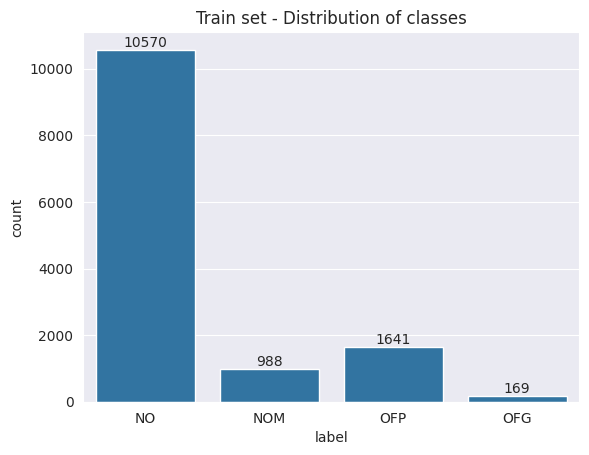

In [108]:
# Train distribution of labels
ax = sns.countplot(train_df, x="label")
ax.set_title("Train set - Distribution of classes")
ax.bar_label(ax.containers[0])
plt.show()

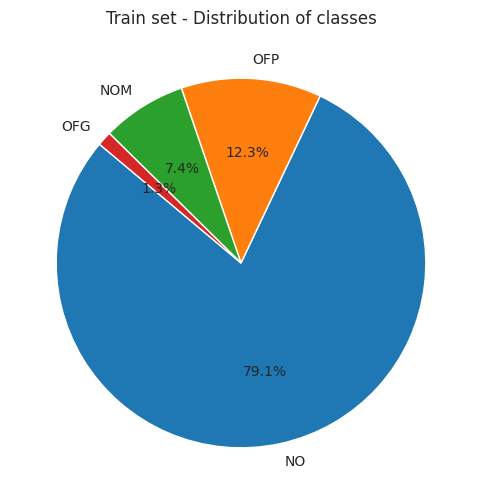

In [109]:
# Train pie chart for all labels
label_counts = train_df["label"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Train set - Distribution of classes')
plt.show()

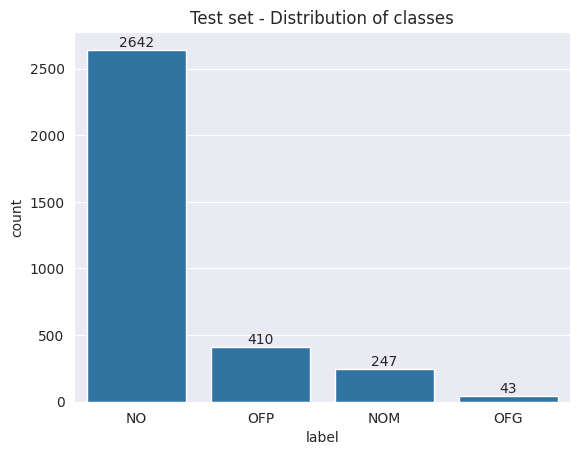

In [110]:
# Test distribution of labels
ax = sns.countplot(test_df, x="label")
ax.set_title("Test set - Distribution of classes")
ax.bar_label(ax.containers[0])
plt.show()

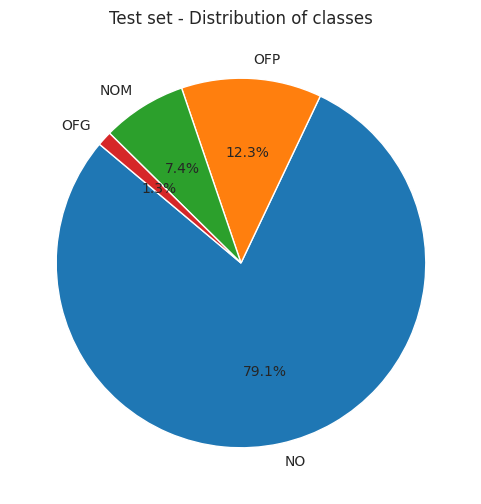

In [111]:
# Test pie chart for all labels
label_counts = test_df["label"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Test set - Distribution of classes')
plt.show()

Agregaremos una columna más que almacene el valor para la clasificación binaria de esta tarea. El mapping es como indicamos arriba:
- `OFP` -> hate
- `OFG` -> hate
- `NOM` -> no_hate
- `NO` -> no_hate

In [112]:
train_df["label_binary"] = train_df["label"].map(hs_config.map_to_binary_label)
test_df["label_binary"] = test_df["label"].map(hs_config.map_to_binary_label)

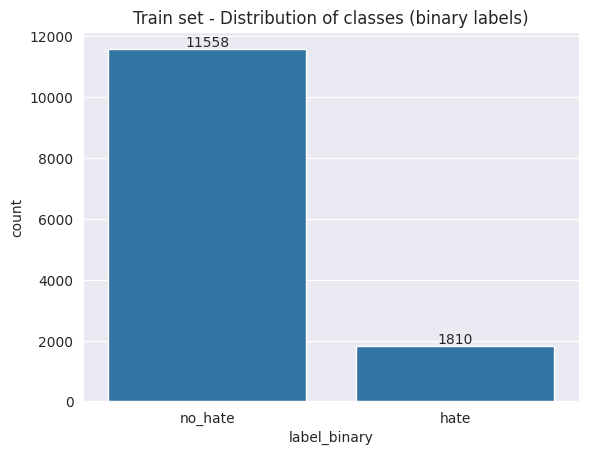

In [113]:
# Training distribution of binary labels
ax = sns.countplot(train_df, x="label_binary")
ax.set_title("Train set - Distribution of classes (binary labels)")
ax.bar_label(ax.containers[0])
plt.show()

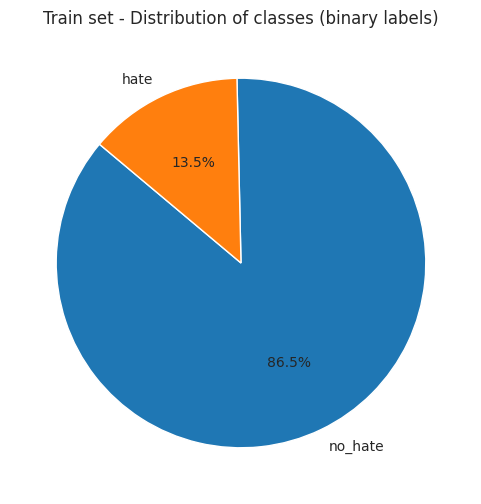

In [114]:
# Training pie chart for binary labels
label_counts = train_df["label_binary"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Train set - Distribution of classes (binary labels)')
plt.show()

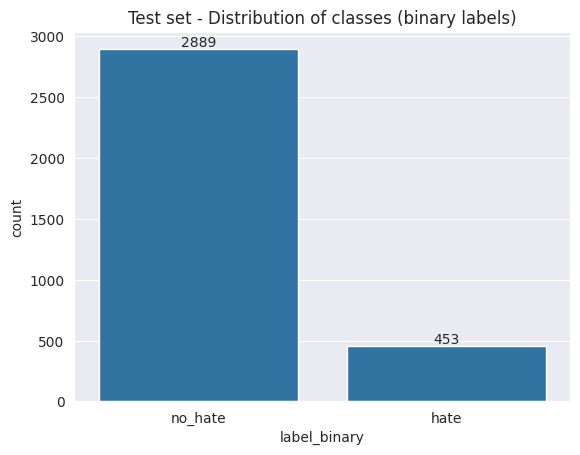

In [115]:
# Testing distribution of binary labels
ax = sns.countplot(test_df, x="label_binary")
ax.set_title("Test set - Distribution of classes (binary labels)")
ax.bar_label(ax.containers[0])
plt.show()

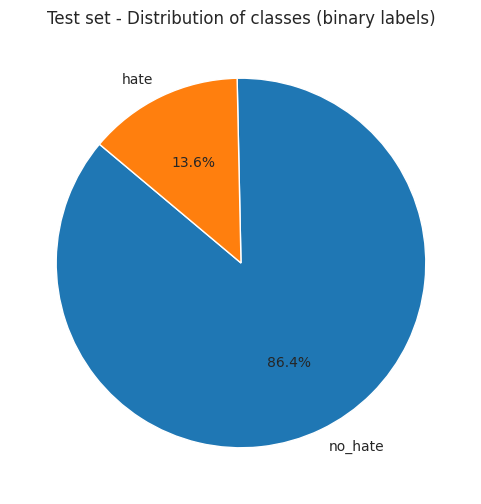

In [116]:
# Test pie chart for binary labels
label_counts = test_df["label_binary"].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Test set - Distribution of classes (binary labels)')
plt.show()

Podemos comprobar que la distribución que tenemos para las distintas clases está bastante desbalanceada.
Esto es un problema bastante común según he visto cuando investigué el tema de discurso del odio para la materia `Introducción a la Investigación en PLN` del este mismo Máster.
En general, siempre suele darse el caso que terminamos teniendo un número mucho más alto de ejemplos para la clase de `no-hate` que para la de `hate`. Esto puede observarse claramente cuando mapeamos las labels fine-grained a las course-grained y las volcamos en los gráficos previos.

Mirando las 4 labels, vemos que la clase `OFG`, asociada a texto ofensivo pero que ataca a un grupo de personas o colectividad suele ser la menos representada. Esto naturalmente puede traernos problemas, ya que el modelo al ser entrenado ve muy pocos ejemplos de estas clases más minoritarias y hay que ver si esto es suficiente para que luego pueda aprender a generalizar. 
Por otro lado, al momento de testear, como tenemos un test set también desbalanceado, tenemos que guiarnos por métricas macro, que den el mismo peso a cada clase (tanto para el caso binario como para el caso multi-class). De no hacerlo y usar `micro` averages, podríamos terminar teniendo la ilusión de una buena performance con un modelo que siempre predice `no-hate`. Debemos ayudarnos también por métricas como `precision`, `recall` y `f1` para seleccionar los mejores candidatos.

Como posibles soluciones al problema del desbalance, tenemos:
- Recortar ejemplos del train set para lograr una distribución más homogénea. Esto suele conocerse como _down sampling_ -> para el problema de clasificación binaria (`hate` vs `no_hate`) ṕodría servirnos, ya que terminaríamos los ejemplos de `no_hate` a 1810, que es lo que tenemos para `hate`. Ahora, para el problema multi-class, no lo veo viable, ya que tenemos la clase `OFG` con sólo 169 ejemplos, con lo cual el recorte sería demasiado agresivo. <br>Desde mi punto de vista, esta estrategia no es algo que me gustaría explorar, porque de una forma u otra  estaríamos descartando datos de entrenamiento que deberían servirnos para que el modelo pueda aprender bien la tarea. <br>

- Aumentar ejemplos correspondientes a las clases minoriarias del train set una vez hecho el split (muy bien marcado por [Arango et al. 2019 Hate Speech Detection is Not as Easy as You May Think](https://www.researchgate.net/publication/334580382_Hate_Speech_Detection_is_Not_as_Easy_as_You_May_Think_A_Closer_Look_at_Model_Validation). Esto implicaría hacer el train-val split (ya el de test lo tenemos y no podemos modificarlo), y para los datos resultantes de training aumentar las clases minoritarias para lograr un mejor balance. Notar que el data augmentation tenemos que hacerlo sí o sí luego de haber hecho el split. Si lo hiciéramos antes y después hacemos el split, podríamos terminar con los mismos samples en el conjunto de train y de validation a la vez, sesgando así la performance y los resultados de la curva de validación. Estaríamos haciendo trampa porque el validation set, al tener ejemplos del train set, no sería un verdadero validation set al final de todo.
  <br>Como alternativas para aumentar podríamos:
  - Usar Large Language Models (LLMs) y zero-shot/few-shot learning para que generen ejemplos similares. Esta tarea es mucho más fácil de hacer para el problema de clasificación binaria. Para el multi-class, tenemos que comprobar más exhaustivamente que las prompts que usemos funcionen bien de forma de generar ejemplos que realmente pertenezcan a cada categoría. 
  - Usar LLMs para que hagan paraphrasing sobre los ejemplos existentes.
  - Usar back translation o reemplazo de sinónimos.
  - Aumentar n-veces los ejemplos de las clases minoritarias para lograr un mejor balance (sin perturbación alguna de los ejemplos).
  - Aumentar n-veces los ejemplos de las clases minoritarias para lograr un mejor balance (agregando algún tipo de ruido a cada sample con librerías como [nlpaug](https://github.com/makcedward/nlpaug).
  - 💡 Notar que en los casos de aumentación, también existiría la posibilidad de aplicarlos pero parcialmente, es decir, sin llegar a nivelar exactamente la cantidad de samples que deseamos de alguna clase. Cualquier tipo de data augmentation (parcial o total), debería servirnos para mejorar los resultados. 

- No hacer nada. En caso de optar por no balancear el dataset (el cual sería otra opción a considerar de baseline), es importante que hagamos un [stratified split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) cuando separemos train y val, de forma de asegurarnos de que todas las clases van a tener algún representante en ambos sets. Esto tenemos que considerarlo igualmente para el caso en donde hagamos data augmentation.

Resulta particularmente interesante generar al menos dos variaciones del dataset. 
Una que realice algún tipo de data augmentation para lidiar con este problema, y otra que no, de forma de comparar cómo los modelos performan contra el test set en ambos casos. 
Podemos intentar sacar algún tipo de conclusión de esto en función de los resultados que tengamos en el próximo notebook (en donde entrenamos viriantes ligeras basadas en Machine Learning) y ya luego fijar el dataset para los modelos posteriores basados en Deep Learning. De esta manera, podemos optimizar un poco más el uso de los recursos.

Personalmente, la alternativa que más interesaría explorar es la de aumentar el dataset con LLMs y zero-shot/few-shot learning. Siento que es la que sin dudas nos podría traer mejores resultados. Por cuestiones de tiempo y de intentar terminar con la práctica, optaré por hacer algo más fácil inicialmente, que es simplemente extender las clases minoritarias duplicándolas tal y como están, para ver qué resultados nos da.

## Análisis del texto de cada una de las clases

Si queremos que nuestros modelos sean capaces de aprender a través de las palabras que cada documento tiene a predecir la clase asociada, necesitamos verificar cuáles son las más frecuentes para cada clase en nuestro set de training.

En caso de que el overlap entre las palabras más comunes de las distintas clases sea muy grande, esto podría complejizar el entrenamiento del modelo, ya que vería que las palabras más representativas ocurren de forma similar para las clases de los discursos del odio. Esto es cierto si pensamos en un pesado basado en el conteo por frecuencia. Si utilizamos tf-idf no es necesariamente así, ya que el peso que tendrá una palabra en un review no sólo dependerá de cuántas veces dicha palabra aparezca en el review, si no de las veces que ocurre en el resto de los documentos también.

Por otro lado, también tenemos que verificar cuáles son esas palabras más comunes en cada clase, como para ver si realmente son representativas e indicativas de las mismas o no tienen nada que ver.

Todas las clases de hate-speech

In [117]:
top_more_popular_tokens: int = 25
train_set_more_pop_tokens_by_class: dict[str, pd.DataFrame] = get_more_common_tokens_by_class(df=train_df,
                                                                                              text_column_name="comment",
                                                                                              label_column_name="label",
                                                                                              top_more_popular_tokens=top_more_popular_tokens)

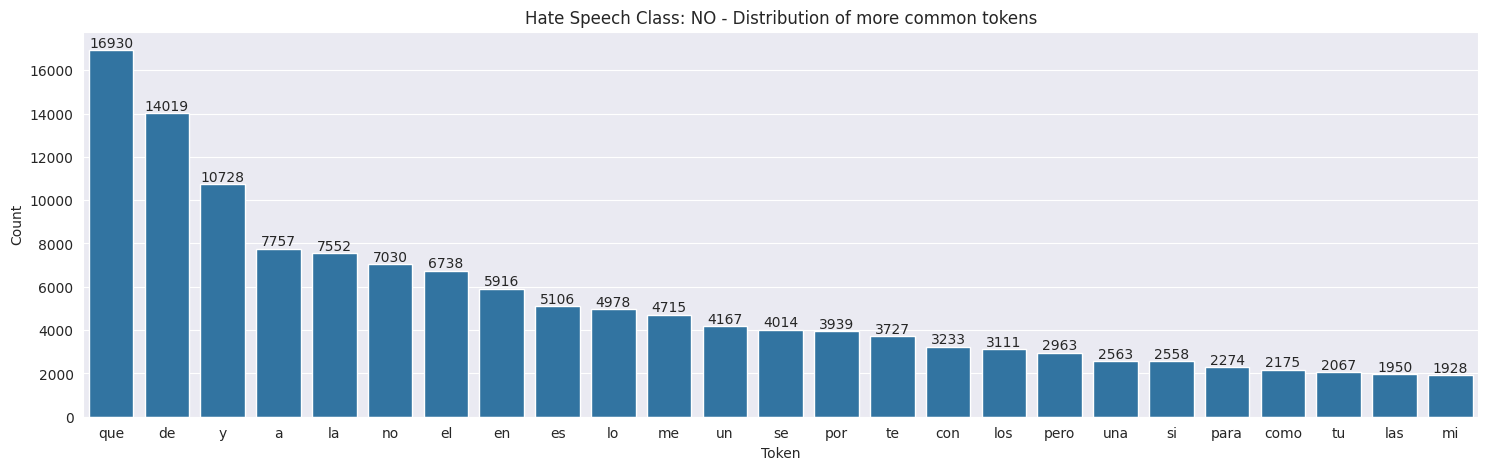

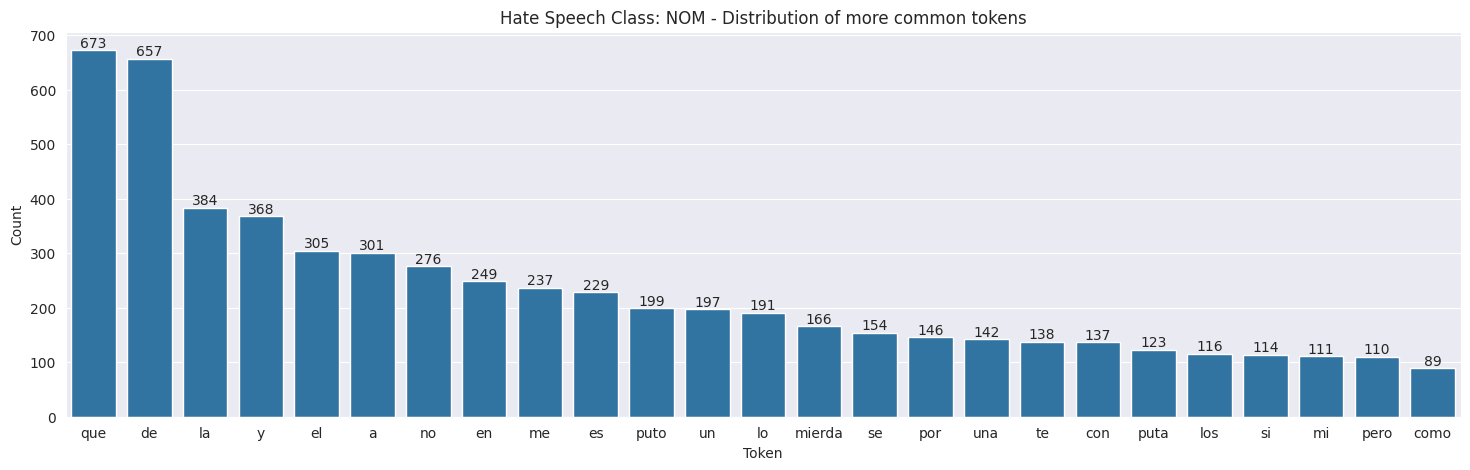

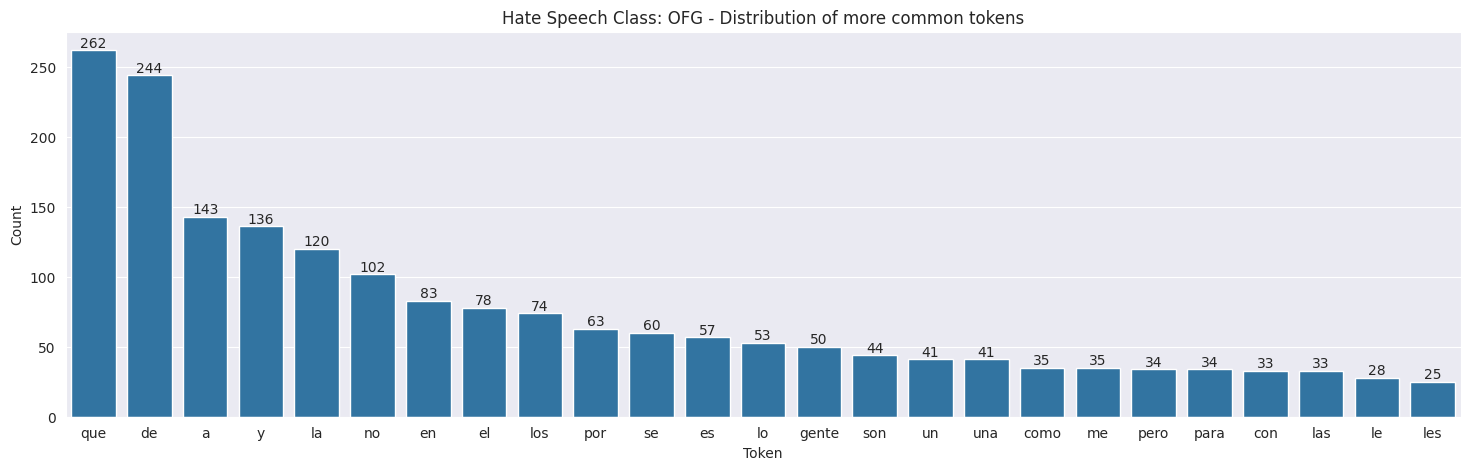

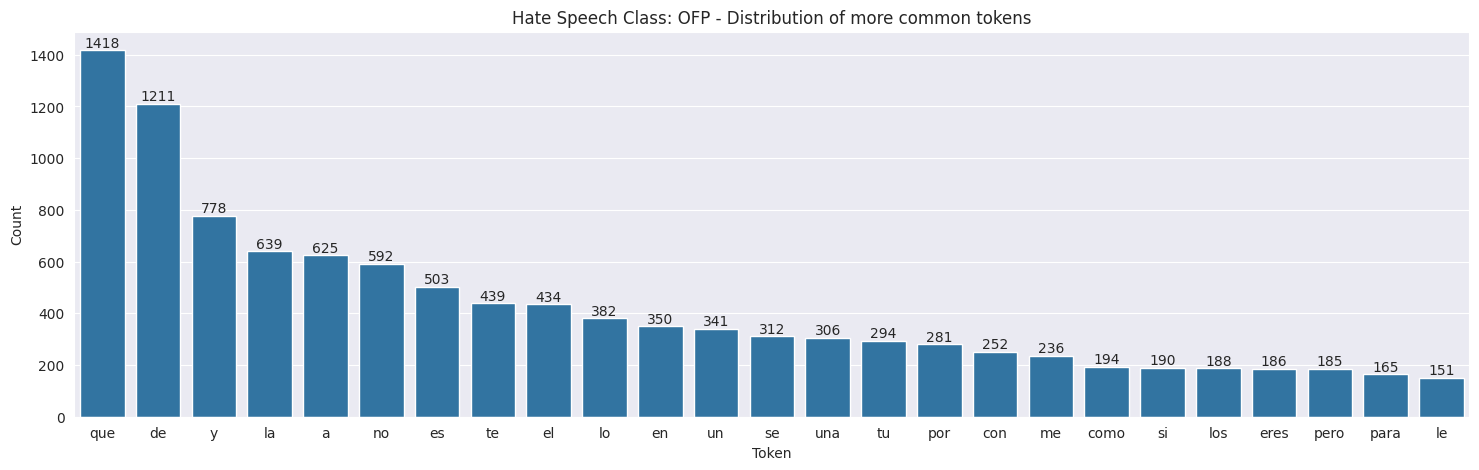

In [118]:
for class_label in list(train_set_more_pop_tokens_by_class.keys()):
    draw_barplot(x=train_set_more_pop_tokens_by_class[class_label]["token"],
                 y=train_set_more_pop_tokens_by_class[class_label]["count"],
                 figsize=(18, 5), x_label="Token",
                 title=f"Hate Speech Class: {class_label} - Distribution of more common tokens")

Clases de hate-speech en forma binaria

In [119]:
train_set_more_pop_tokens_by_binary_class: dict[str, pd.DataFrame] = get_more_common_tokens_by_class(df=train_df,
                                                                                                     text_column_name="comment",
                                                                                                     label_column_name="label_binary",
                                                                                                     top_more_popular_tokens=top_more_popular_tokens)

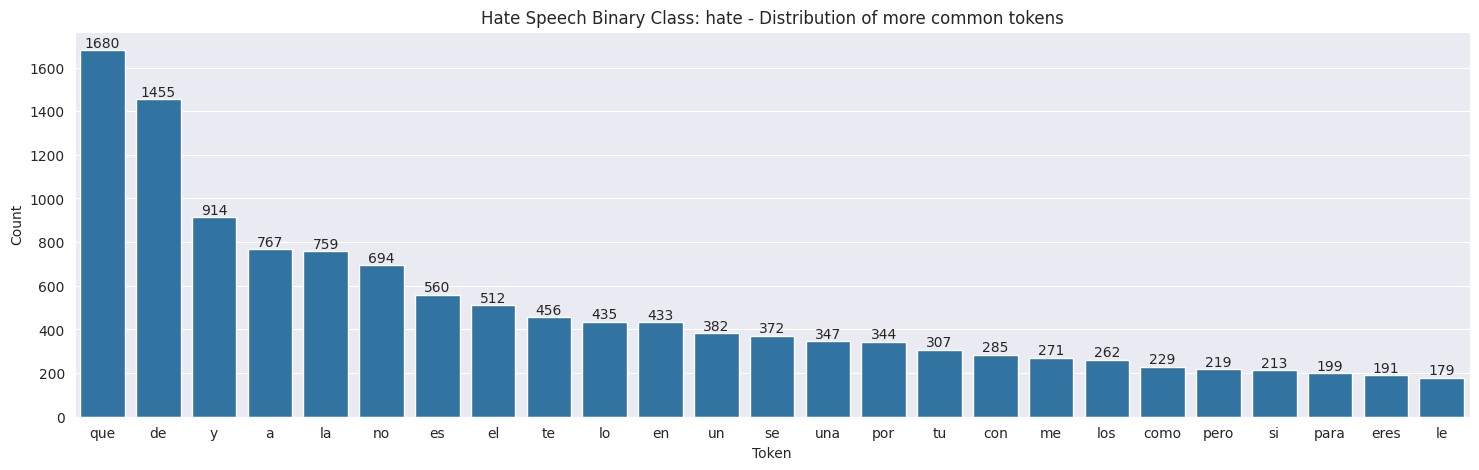

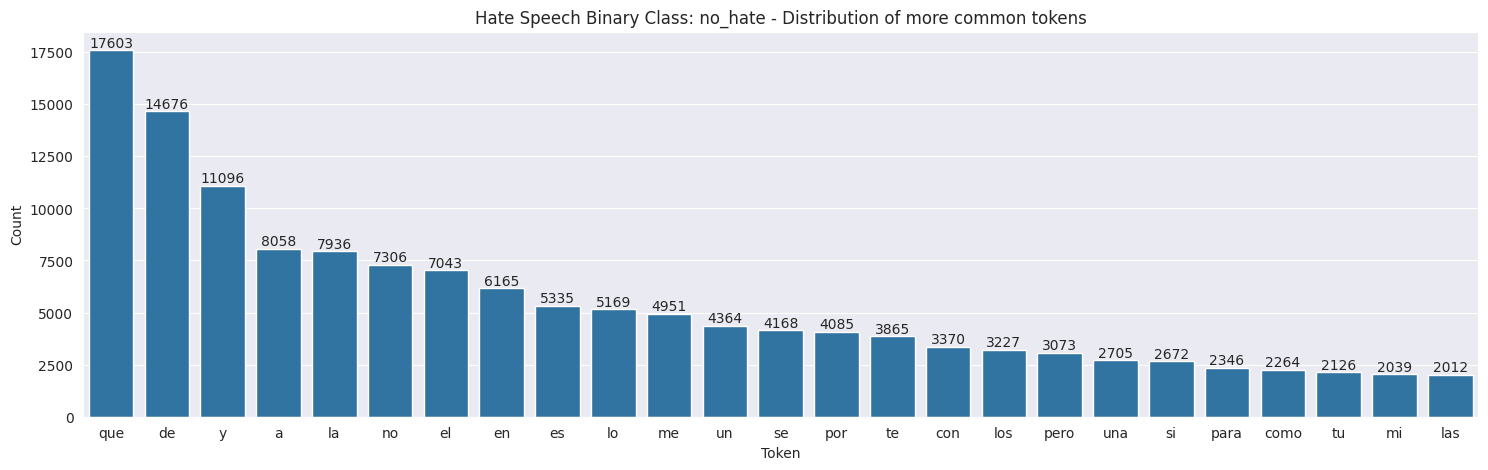

In [120]:
for class_label in list(train_set_more_pop_tokens_by_binary_class.keys()):
    draw_barplot(x=train_set_more_pop_tokens_by_binary_class[class_label]["token"],
                 y=train_set_more_pop_tokens_by_binary_class[class_label]["count"],
                 figsize=(18, 5), x_label="Token",
                 title=f"Hate Speech Binary Class: {class_label} - Distribution of more common tokens")

In [121]:
# Compute overlap between more common tokens for hate and no_hate
more_pop_tokens_hate: set[str] = set(train_set_more_pop_tokens_by_binary_class["hate"]["token"])
more_pop_tokens_no_hate: set[str] = set(train_set_more_pop_tokens_by_binary_class["no_hate"]["token"])
intersection_set: set[str] = more_pop_tokens_hate.intersection(more_pop_tokens_no_hate)

print(
    f"Total different tokens that intersect between 'hate' and 'no-hate' classes in top {top_more_popular_tokens}: {len(intersection_set)}")
print(
    f"Intersection set between top {top_more_popular_tokens} more popular tokens for 'hate' and 'no-hate' classes: \n{intersection_set}")
print(
    f"Difference in top {top_more_popular_tokens} more popular tokens between 'hate' and 'no-hate': \n {more_pop_tokens_hate.difference(more_pop_tokens_no_hate)}")
print(
    f"Difference in top {top_more_popular_tokens} more popular tokens between 'hate' and 'no-hate': \n {more_pop_tokens_no_hate.difference(more_pop_tokens_hate)}")

Total different tokens that intersect between 'hate' and 'no-hate' classes in top 25: 23
Intersection set between top 25 more popular tokens for 'hate' and 'no-hate' classes: 
{'no', 'para', 'lo', 'es', 'en', 'y', 'un', 'la', 'pero', 'me', 'si', 'de', 'que', 'se', 'el', 'por', 'a', 'te', 'como', 'tu', 'con', 'una', 'los'}
Difference in top 25 more popular tokens between 'hate' and 'no-hate': 
 {'le', 'eres'}
Difference in top 25 more popular tokens between 'hate' and 'no-hate': 
 {'mi', 'las'}


In [122]:
train_set_more_pop_tokens_by_binary_class["hate"]

,token,count
0,que,1680
1,de,1455
2,y,914
3,a,767
4,la,759
5,no,694
6,es,560
7,el,512
8,te,456
9,lo,435


Tal y como podemos observar con estos gráficos, observamos conjuntos muy parecidos tanto cuando analizamos las 4 labels como las formas binarias.
Se puede ver algún caso interesante que por ejemplo aparece para `NOM` con palabras como "puta" o "mierda", que yo personalmente me las esperaba en clases de odio.  
Por otro lado, las palabras más populares ofrecen muy poca información, en ambas clases. Se trata de **stopwords**, no relacionadas con las clases, y que pueden afectar al rendimiento del clasificador. Por tanto, debemos eliminarlas. Es cierto que cuando usemos modelos más avanzados el modelo no va a mirar palabras por separado, si no que va a mirar secuencias de palabras, prestar atención cuando analiza una palabra a las anteriores y demás.


💡 Notar que al obtener los tokens más populares realicé un ligero cleanup de los comentarios. Simplemente los pasé a lowercase para tener estadísticas más claras y le apliqué striping.

## Distribución de la cantidad de tokens en la columna review

Procederemos a analizar la distribución de la cantidad de palabras que tenemos en cada uno de nuestros sets (debería ser similar). Algo intuitivamente ya mismo con la media a nivel de caracteres.

Deberíamos comprobar la distribución de palabras en training y en test.

Y después dentro de training, podríamos mirar la distribución de cantidad de palabras para cada clase

In [123]:
tokenizer = WhitespaceTokenizer()
train_df["tokens_count"] = train_df["comment"].apply(lambda x: len(tokenizer.tokenize(x)))
test_df["tokens_count"] = test_df["comment"].apply(lambda x: len(tokenizer.tokenize(x)))

In [124]:
train_df.head()

,comment_id,comment,label,label_binary,tokens_count
0,2081,Dalas: hace una pregunta retórica Turbobo: *...,NO,no_hate,25
1,21214,Por qué no solamente le diste a una fundación ...,NO,no_hate,42
2,40888,Te ves guapísima y brillante con ese nuevo loo...,NO,no_hate,27
3,40790,Se esta hablando de que Ariana Grande esta rel...,NO,no_hate,44
4,55889,¡¡HAGO REVIEWS DE SERIES Y PELIS!! ¿ Quieres e...,NO,no_hate,27


In [125]:
train_df[("tokens_count")].describe().reset_index()

,index,tokens_count
0,count,13368.000000
1,mean,32.108992
2,std,33.934407
3,min,1.000000
4,25%,16.000000
5,50%,25.000000
6,75%,37.000000
7,max,1285.000000


In [126]:
test_df[("tokens_count")].describe().reset_index()

,index,tokens_count
0,count,3342.000000
1,mean,32.628965
2,std,39.915310
3,min,1.000000
4,25%,16.000000
5,50%,26.000000
6,75%,37.000000
7,max,1532.000000


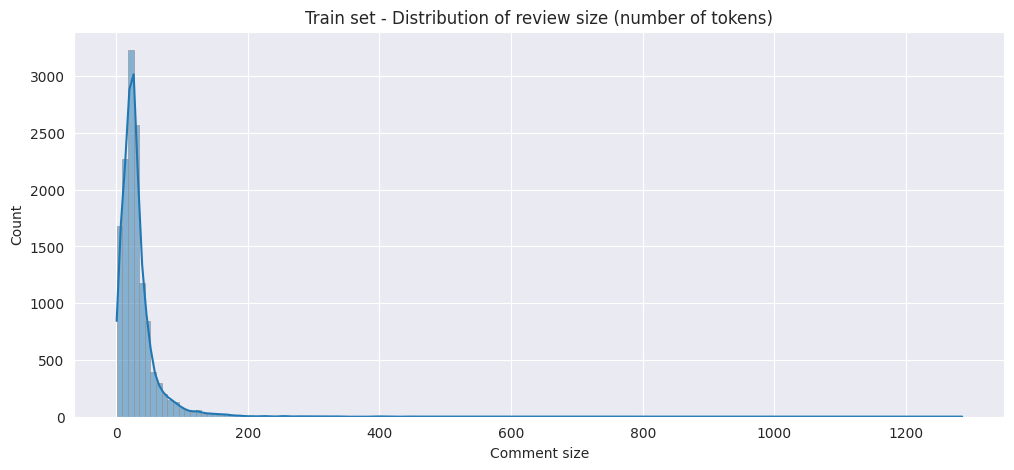

In [127]:
# Plot Train tokens distribution
draw_histogram(data=train_df["tokens_count"],
               title="Train set - Distribution of review size (number of tokens)", x_label="Comment size",
               figsize=(12, 5), bins=150)

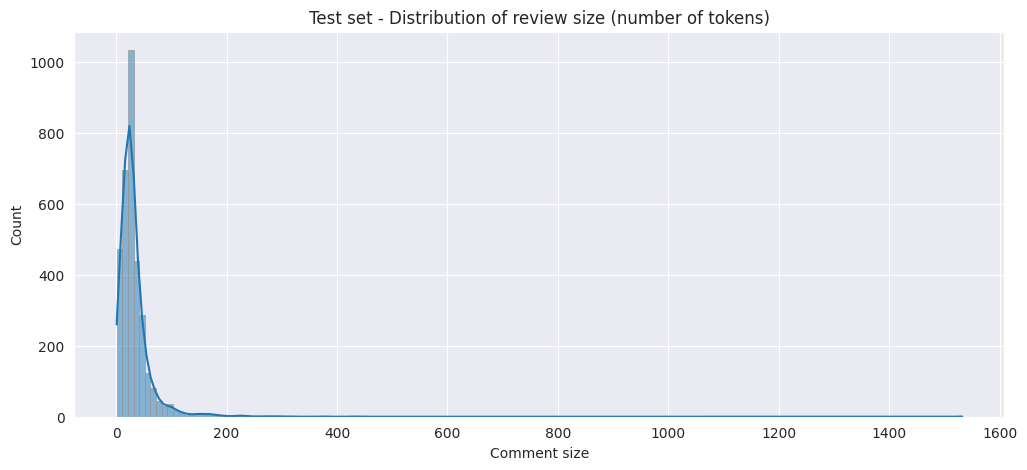

In [128]:
# Plot Test tokens distribution
draw_histogram(data=test_df["tokens_count"],
               title="Test set - Distribution of review size (number of tokens)", x_label="Comment size",
               figsize=(12, 5),
               bins=150)

Podemos comprobar que las distribuciones en cuanto a la cantidad de palabras del campo `comment` es bastante similar en train y test sets respectivamente.

Tenemos algunos que otro comentario en ambos casos que exceden las 1200 palabras, bastante por fuera de la media obtenida.

Podemos zoomear las distribuciones filtrando un poco para ver con más detalle los bins.

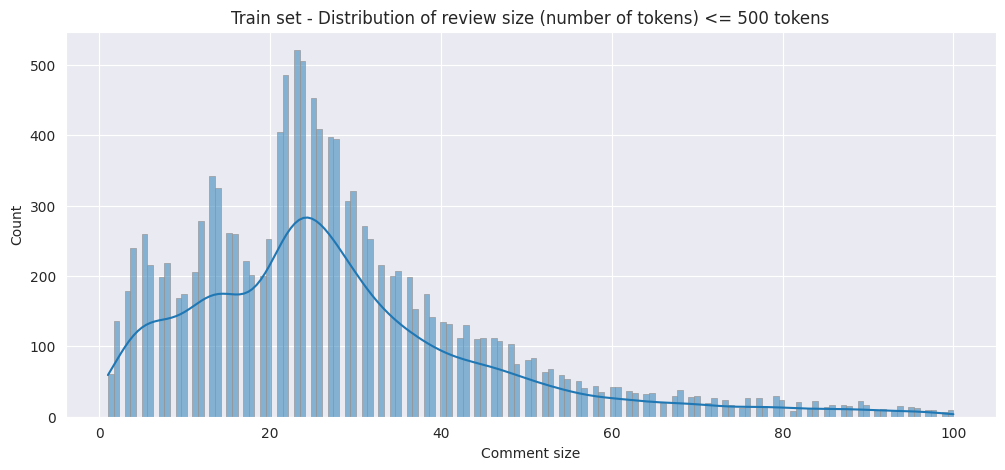

In [129]:
draw_histogram(data=train_df[train_df["tokens_count"] <= 100]["tokens_count"],
               title="Train set - Distribution of review size (number of tokens) <= 100 tokens", x_label="Comment size",
               figsize=(12, 5), bins=150)

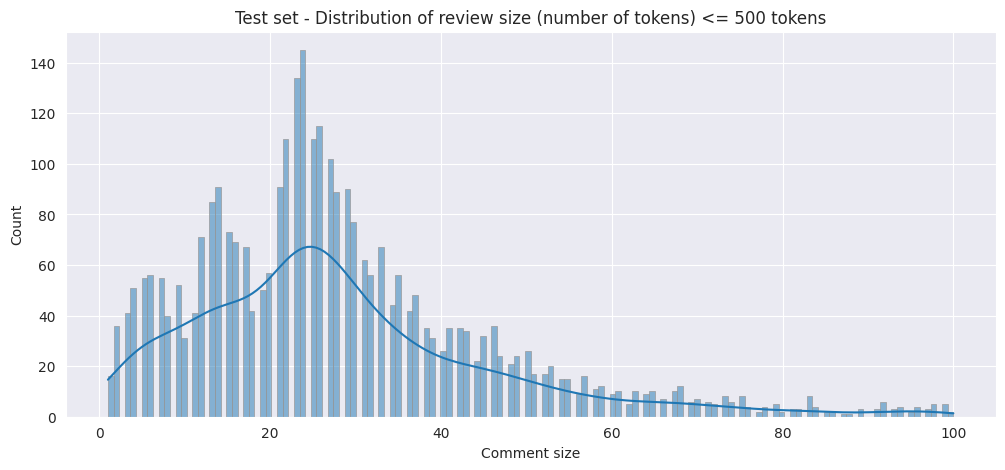

In [130]:
draw_histogram(data=test_df[test_df["tokens_count"] <= 100]["tokens_count"],
               title="Test set - Distribution of review size (number of tokens) <= 100 tokens", x_label="Comment size",
               figsize=(12, 5), bins=150)

Analizaremos ahora la misma distribución pero por clase, y enfocándonos solamente en el training set.

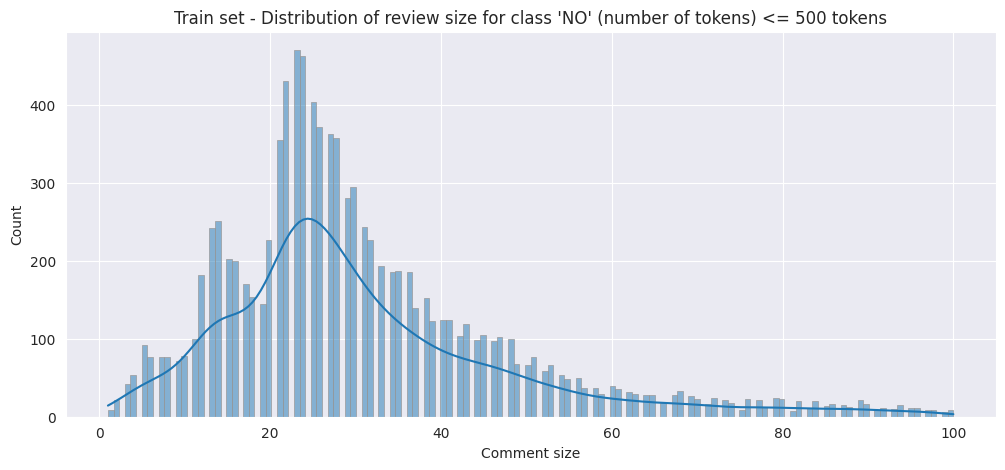

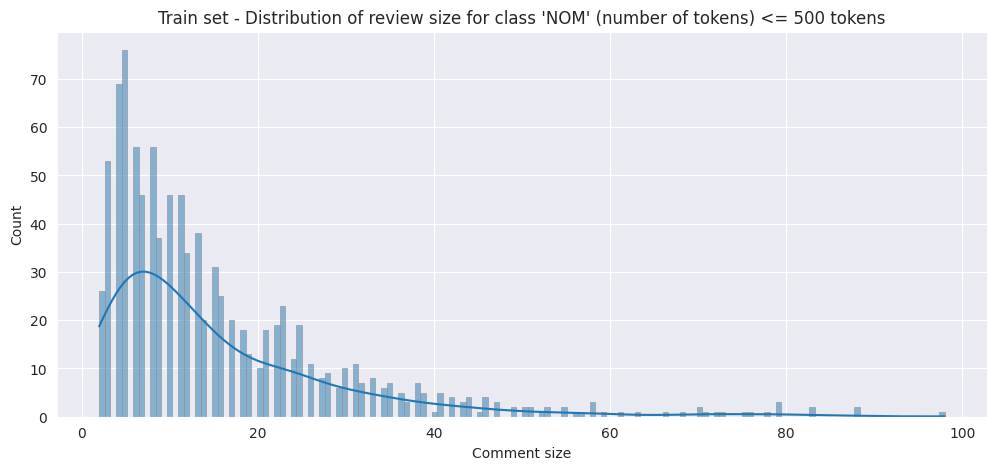

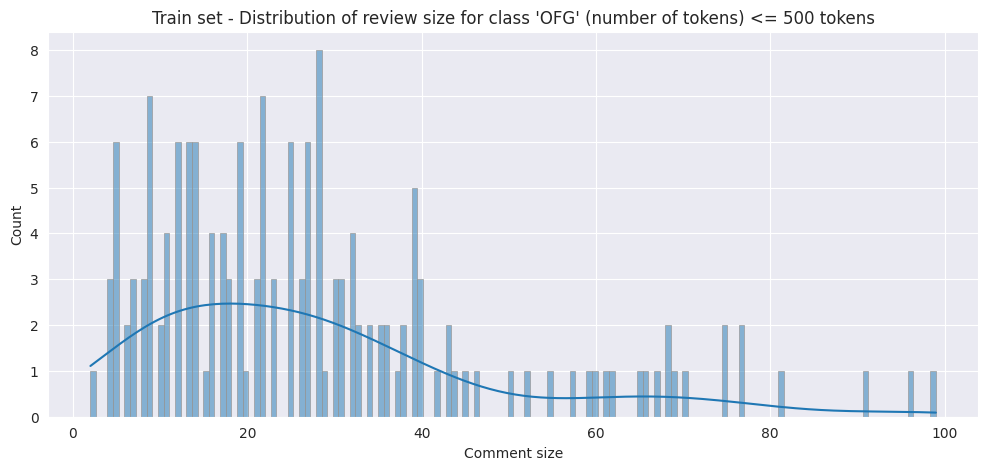

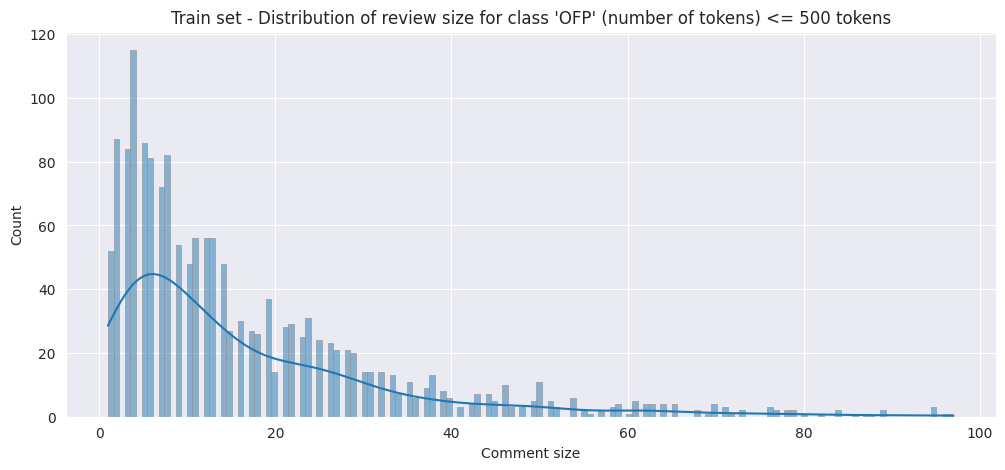

In [131]:
for class_label in sorted(set(train_df["label"])):
    draw_histogram(
        data=train_df[(train_df["label"] == class_label) & (train_df["tokens_count"] <= 100)]["tokens_count"],
        title=f"Train set - Distribution of review size for class '{class_label}' (number of tokens) <= 100 tokens",
        x_label="Comment size",
        figsize=(12, 5), bins=150)

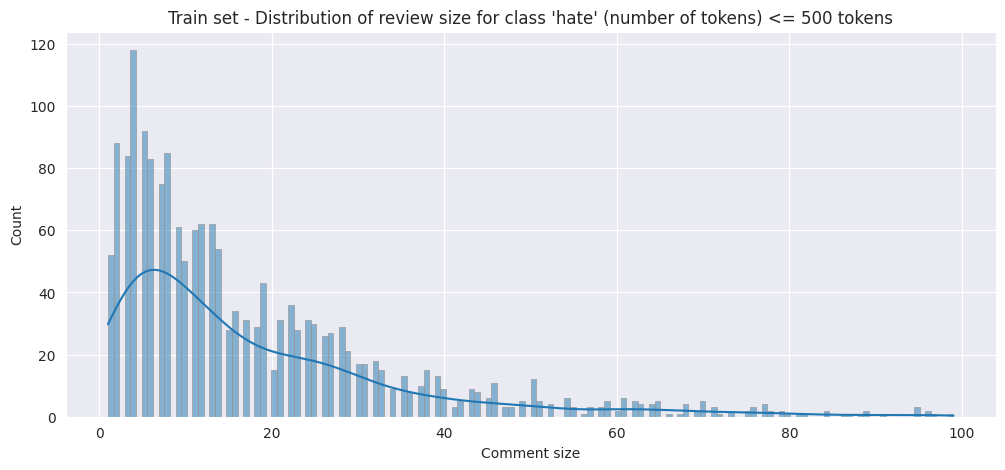

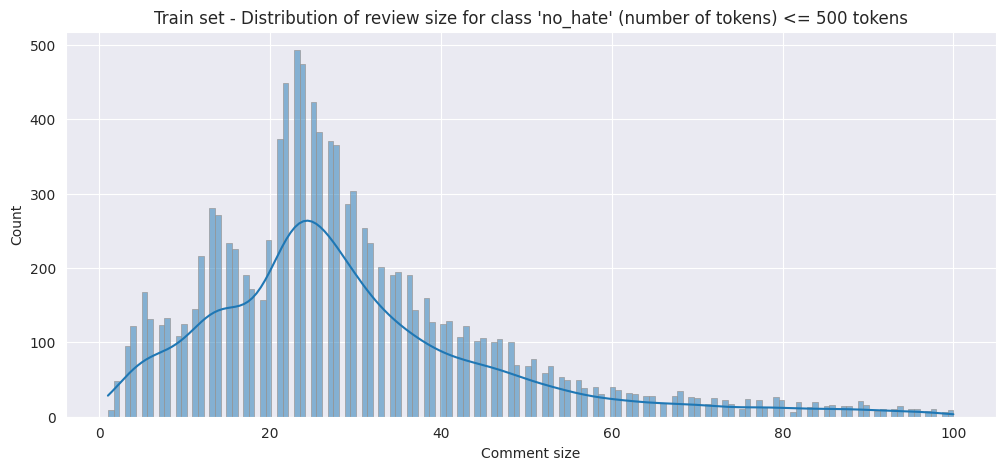

In [132]:
for class_label in sorted(set(train_df["label_binary"])):
    draw_histogram(
        data=train_df[(train_df["label_binary"] == class_label) & (train_df["tokens_count"] <= 100)]["tokens_count"],
        title=f"Train set - Distribution of review size for class '{class_label}' (number of tokens) <= 100 tokens",
        x_label="Comment size",
        figsize=(12, 5), bins=150)

In [133]:
train_df[train_df["label_binary"] == "hate"]["tokens_count"].describe()

count    1810.000000
mean       20.235359
std        26.051950
min         1.000000
25%         6.000000
50%        12.000000
75%        25.000000
max       414.000000
Name: tokens_count, dtype: float64

In [134]:
train_df[train_df["label_binary"] == "no_hate"]["tokens_count"].describe()

count    11558.000000
mean        33.968420
std         34.642729
min          1.000000
25%         19.000000
50%         26.000000
75%         38.000000
max       1285.000000
Name: tokens_count, dtype: float64

Con estas gráficas podemos ver que los comentarios asociados a discursos `no_hate` suelen ser un poco más largos que los asociados a `hate`.

### Validación de comentarios largos y cortos

Exploraremos un poco más reviews cortos y largos, para tener un idea del tipo de mensajes que el test set almacena.

In [135]:
sorted_train_df: pd.DataFrame = train_df.sort_values(by="tokens_count")

In [136]:
sorted_train_df[sorted_train_df["label_binary"] == "hate"].head(20)

,comment_id,comment,label,label_binary,tokens_count
7561,56922,Nazi,OFP,hate,1
7588,53990,Patético.,OFP,hate,1
6879,27611,Foca,OFP,hate,1
9296,19748,IDIOTA,OFP,hate,1
5266,59851,RACISTA,OFP,hate,1
5303,27352,Imbecil.,OFP,hate,1
8930,54082,GORDO!!!!!!!!!!!!,OFP,hate,1
11101,15616,Mentirosa,OFP,hate,1
8639,45907,Ridicula,OFP,hate,1
12645,20435,Tonta,OFP,hate,1


In [137]:
sorted_train_df[sorted_train_df["label_binary"] == "no_hate"].head(30)

,comment_id,comment,label,label_binary,tokens_count
218,54677,Pato,NO,no_hate,1
9239,21364,Verga,NO,no_hate,1
3475,2859,Pamplinas,NO,no_hate,1
801,53944,Travesti,NO,no_hate,1
12974,50447,Marron,NO,no_hate,1
7662,20427,https://www.ecartelera.com/personas/soy-una-pr...,NO,no_hate,1
10179,49111,Mono,NO,no_hate,1
7126,55820,Gay,NO,no_hate,1
11663,55898,blanco✨,NO,no_hate,1
6324,22876,Pato asado?,NO,no_hate,2


Hay algunas anotaciones que son discutibles. Tenemos ejemplos como "Travesti", "Gay" o "Feo 🤣" que están catalogados como `no_hate`.

Los que pudimos ver de `hate`, son claramente pertenecientes a esa clase.

In [138]:
sorted_train_df[sorted_train_df["label_binary"] == "hate"].tail(10)

,comment_id,comment,label,label_binary,tokens_count
5034,44529,jajajajajaja mira que jpelirrojo me da igual p...,OFP,hate,167
5449,11510,No eres mas tonta porque no tienes mas tiempo ...,OFP,hate,170
10522,4489,"Oscuro , oscuro tenes el cerebro eso es lo mas...",OFP,hate,174
813,41968,Mira yo me considero una buena rutilofila y qu...,OFP,hate,174
9791,34138,"Haber,no soy gachatuber emputado como los otro...",OFP,hate,190
6749,42844,rata rata ratarata rata ratarata rata ratarata...,OFP,hate,192
6118,32754,"La gente es realmente estúpida, yo soy volunt...",OFG,hate,223
9381,53747,"Me reí tanto con tu publicación en twitter, so...",OFP,hate,225
9756,22010,"¿De verdad? Lo admito, soy muy intolerante a l...",OFP,hate,232
12459,40214,Yo también era seguidora de él y me empezó a a...,OFP,hate,414


In [139]:
list(sorted_train_df[sorted_train_df["label_binary"] == "hate"].tail(10)["comment"])

['jajajajajaja mira que jpelirrojo me da igual pero bueno, se que el formato que el gusta es el video blog diario igual que a ti te gusta criticar a los demas aunque tienes pinta de no aceptar criticas. no voy a meterme mucho pero es muy grotesco verte, tu manera de expresarte, ruidos de fondo, criticas, insultos, y no digas nada de gym cuando tu forma fisica es la que es. tus videos los ve la gente porque criticas insultando y mira que eres un blanco facil, pero claro si digo que tu forma fisica no es saludable soy un machista... o con no pensar como tu soy un machista bueno lo que si me voy a meter es con las mierdas de pintadas que tienes en los brazos, en lo poco que vocalizas, en tus gafas de plastico malo y la camisa fea que llevas. me recuerdas de un modo grotesco a agatha ruiz de la prada. Tus opiniones son algo penosas y tristes simplemente grotesco',
 'No eres mas tonta porque no tienes mas tiempo chica, dejar los estudios y casarte con 20 años?? jajajaja Ya sea risto o el ve

In [140]:
sorted_train_df[sorted_train_df["label_binary"] == "no_hate"].tail(10)

,comment_id,comment,label,label_binary,tokens_count
591,44166,Para empezar el swating es algo que se conoce ...,NO,no_hate,415
6020,15311,En el pasado yo creía que era un Youtuber Game...,NO,no_hate,444
66,45789,"En mi opinion, ninguna de estas filtraciones y...",NO,no_hate,445
3473,53229,Yo te esperare No sentaremos juntos frente al ...,NO,no_hate,458
11860,12157,una cosa que si me molesta de youtube es que n...,NO,no_hate,468
4789,24603,"4:26 WildHater, aquí te dejo un Tweet oficial ...",NO,no_hate,495
12769,29747,Veo los comentarios y lo único que interpreto ...,NO,no_hate,501
10950,46554,"Uyy Javi, te sigo desde hace tiempo, pero teng...",NO,no_hate,646
2032,43057,Quiero aprovechar para mandar un saludo a mi m...,NO,no_hate,718
11162,48973,2018-Mi hermana de 10 años~ 2019- Mi hermana d...,NO,no_hate,1285


In [141]:
list(sorted_train_df[sorted_train_df["label_binary"] == "no_hate"].tail(10)["comment"])

['Para empezar el swating es algo que se conoce de hace mucho tiempo y el fbi ha acogido ese termino desde 2008, e incluido en el OxfordDictionaries.com desde 2015, sacarlo ahora para atraer la atención de los visualizadores de youtube. Segundo lo que cuentas paso hace un mes, y ahora ves un vídeo de playground y decides hacer un vídeo como dije anteriormente para ganar atención, e incluso das detalles de la escena que no se pueden encontrar en internet. (como las sirenas en el jardín y coches a mansalva o gritos) Hay que decir también que comparar y decir que forma parte de un engranaje que forma el todo con el cambio climático el cambio global o la deforestan y el empobrecimiento, le quitan peso a una causa mucho mas importante. Y por ultimo decir que la pronunciación de tu "sguating" da mucho que pensar en lo que te has informado sobre este tema, con ver un par de vídeo sobre youtubers dando su opinión, o varios medios deberías tener una mejor pronunciación lingüística de ese termin

### Validación de comentarios duplicados

Veamos si hay comentarios duplicados en el train o test set. Únicamente usaré lowercasing y stripping para comparar.

In [142]:
detect_column_duplicates(df=train_df)

Total unique 'comment' with the same content for training set: 0
Total 'comment' with the same content for training set: 0


,comment,count,labels


In [143]:
detect_column_duplicates(df=test_df)

Total unique 'comment' with the same content for training set: 0
Total 'comment' with the same content for training set: 0


,comment,count,labels


### Caracteres por fuera del conjunto ASCII

Comenzaremos analizando qué caracteres caen por fuera del conjunto [ASCII](https://www.w3schools.com/charsets/ref_html_ascii.asp#:~:text=ASCII%20is%20a%207%2Dbit,are%20all%20based%20on%20ASCII.).

In [144]:
train_df["ascii_only"] = train_df["comment"].apply(lambda x: is_ascii(x))
train_df["non_ascii_chars"] = extract_non_valid_characters_from_df(df=train_df)
train_df["ascii_only"].describe().reset_index()

,index,ascii_only
0,count,13368
1,unique,2
2,top,False
3,freq,9841


In [145]:
test_df["ascii_only"] = test_df["comment"].apply(lambda x: is_ascii(x))
test_df["non_ascii_chars"] = extract_non_valid_characters_from_df(df=test_df)
test_df["ascii_only"].describe().reset_index()

,index,ascii_only
0,count,3342
1,unique,2
2,top,False
3,freq,2454


In [146]:
print(
    f"Total rows in training set that contain non-ascii characters: {len(train_df) - len(train_df[train_df['ascii_only'] == True])}/{len(train_df)}")
print(
    f"Total rows in test set that contain non-ascii characters: {len(test_df) - len(test_df[test_df['ascii_only'] == True])}/{len(test_df)}")

Total rows in training set that contain non-ascii characters: 9841/13368
Total rows in test set that contain non-ascii characters: 2454/3342


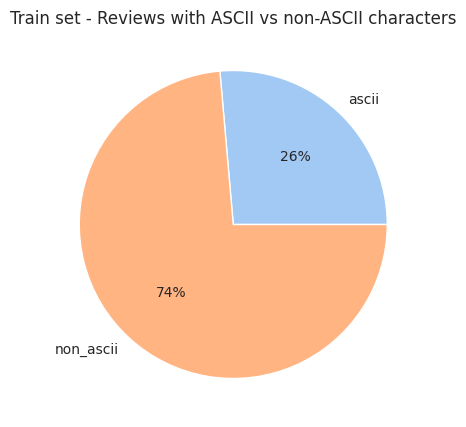

In [147]:
draw_pie_chart(counts=[len(train_df[train_df['ascii_only'] == True]),
                       len(train_df[train_df['ascii_only'] == False])],
               labels=["ascii", "non_ascii"],
               title="Train set - Reviews with ASCII vs non-ASCII characters",
               figsize=(5, 5))

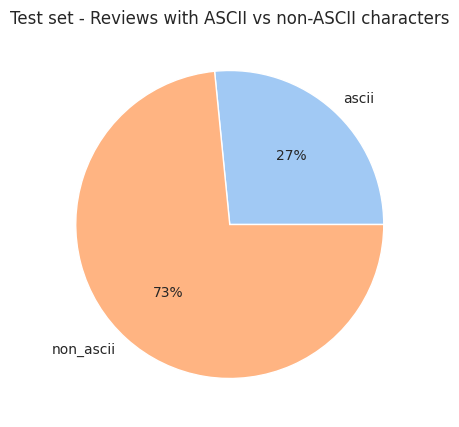

In [148]:
draw_pie_chart(counts=[len(test_df[test_df['ascii_only'] == True]),
                       len(test_df[test_df['ascii_only'] == False])],
               labels=["ascii", "non_ascii"],
               title="Test set - Reviews with ASCII vs non-ASCII characters",
               figsize=(5, 5))

Con estas métricas, podemos observar que hay **9841 filas en nuestro training set y 2454 en nuestro test set que contienen caracteres por fuera del conjunto ASCII** como parte de la columna `review`.

Visualizaremos algunos ejemplos.

In [149]:
# In theory, with this code we should be able to run a font that supports emojis into matplotlib, but it's not working for me :(
# from matplotlib import font_manager

# font_path = '/usr/share/fonts/truetype/noto/NotoColorEmoji.ttf'
# font_manager.fontManager.addfont(font_path)
# plt.rcParams['font.family'] = 'Noto Color Emoji'

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128150 (\N{SPARKLING HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128149 (\N{TWO HEARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:1

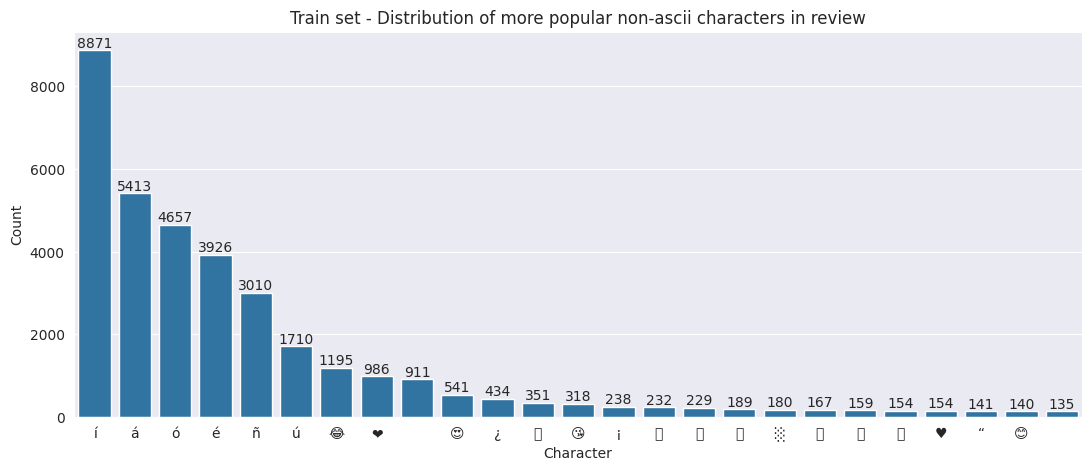

/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129315 (\N{ROLLING ON THE FLOOR LAUGHING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127799 (\N{TULIP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/lucas/anaconda3/envs/master_nlp/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: User

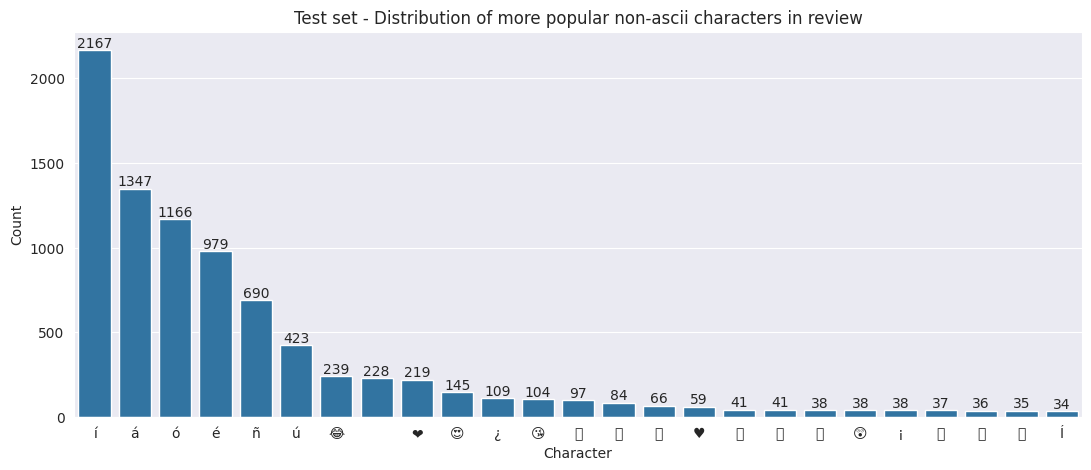

In [150]:
# Compute the distribution of the most common non-ascii characters in the train and test sets
for df, df_label in zip([train_df, test_df], ["Train", "Test"]):
    non_ascii_char_list = [char for sublist in df['non_ascii_chars'] for char in sublist]
    non_ascii_char_count: Counter = Counter(non_ascii_char_list)
    non_ascii_char_count_df: pd.DataFrame = pd.DataFrame(non_ascii_char_count.items(), columns=['char', 'count'])
    non_ascii_char_count_df = non_ascii_char_count_df.sort_values(by='count', ascending=False).head(25)

    draw_barplot(x=non_ascii_char_count_df["char"], y=non_ascii_char_count_df["count"],
                 title=f"{df_label} set - Distribution of more popular non-ascii characters in review",
                 x_label="Character", figsize=(13, 5))

Como conclusion a esta sección, podemos decidir qué es lo que queremos hacer con los caracteres no ASCII. Hay muchos de ellos que se corresponden a diacríticas, diéresis o algún otro tipo de acento y otros que no podemos visualizar (probablemente por el encoding). Intenté para visualizar los emoticones más elegantemente modificar el tipo de font que usa matplotlib, pero no tuve éxito (dejé el código comentado más arriba).

Podríamos optar al momento de hacer el pre-processing por remover las diacríticas para no perder absolutamente todo el caracter. Es decir, transformar `é`en `e` en vez de perderlo por completo.

### Caracteres numéricos

Un análisis adicional que considero válido antes de hacer el cleanup de los comentarios es ver en qué contextos se usan típicamente los números dentro de los mismos.

In [151]:
train_df["contains_digits"] = train_df["comment"].apply(lambda x: contains_digits(x))
train_df["digit_chars"] = extract_non_valid_characters_from_df(df=train_df,
                                                               validation_function=does_not_contain_digits)
train_df["contains_digits"].describe().reset_index()

,index,contains_digits
0,count,13368
1,unique,2
2,top,False
3,freq,10991


In [152]:
test_df["contains_digits"] = test_df["comment"].apply(lambda x: contains_digits(x))
test_df["digit_chars"] = extract_non_valid_characters_from_df(df=test_df,
                                                              validation_function=does_not_contain_digits)
test_df["contains_digits"].describe().reset_index()

,index,contains_digits
0,count,3342
1,unique,2
2,top,False
3,freq,2743


In [153]:
print(
    f"Total rows in training set that contain digits: {len(train_df[train_df['contains_digits'] == True])}/{len(train_df)}")
print(
    f"Total rows in test set that contain digits: {len(test_df[test_df['contains_digits'] == True])}/{len(test_df)}")

Total rows in training set that contain digits: 2377/13368
Total rows in test set that contain digits: 599/3342


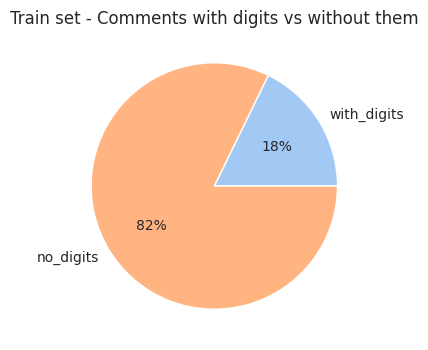

In [154]:
draw_pie_chart(counts=[len(train_df[train_df['contains_digits'] == True]),
                       len(train_df[train_df['contains_digits'] == False])],
               labels=["with_digits", "no_digits"],
               title="Train set - Comments with digits vs without them",
               figsize=(4, 4))

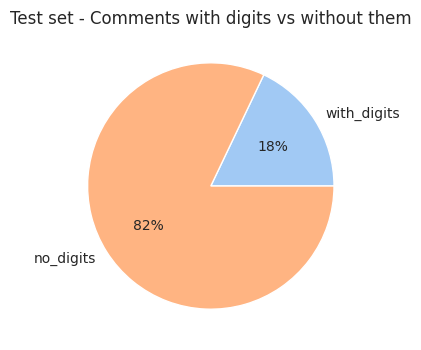

In [155]:
draw_pie_chart(counts=[len(test_df[test_df['contains_digits'] == True]),
                       len(test_df[test_df['contains_digits'] == False])],
               labels=["with_digits", "no_digits"],
               title="Test set - Comments with digits vs without them",
               figsize=(4, 4))

In [156]:
samples: pd.DataFrame = train_df[train_df["contains_digits"] == True].sample(3)
for s in samples["comment"]:
    print(s)
samples

Me gusta más el look 1 ya que pareces skater (mi punto de vista)
no puede ser que exista gente asi dios, ojala estes bien javi y que todos esos idiotas pagen por esas tonterias que son capaces de hacer, ojala estes bien javi tienes todo nuestro apoyo <3
soy  comerciante en Venezuela y no gano mas de 15 dolares al dia en el negocio y para llenar estantes con productos se necesitan alrededor de 30 dolares aparte el punto de venta y los bancos nos quitan un porcentaje muy amplio. en el tema de la salud literalmente estas tu mas sano hasta que pones un pie en un hospital. en la seguridad tanto hombres como mujeres nos entra paníco el salir de nuestras casa a cualquier hora , nos da miedo lo cortes de luz que son bastante frecuentes , porque suele usarse para entra en las casas y robar. no llega agua 1 vez a la semana y a veces ni llega . la policia nos cobre 1 o dos dolares en las filas de la gasolina(un venezolano promedio gana 3 dolares al mes)


,comment_id,comment,label,label_binary,tokens_count,ascii_only,non_ascii_chars,contains_digits,digit_chars
9444,51430,Me gusta más el look 1 ya que pareces skater (...,NO,no_hate,14,False,[á],True,[1]
12810,29760,"no puede ser que exista gente asi dios, ojala ...",OFG,hate,35,True,[],True,[3]
11243,15531,soy comerciante en Venezuela y no gano mas de...,NO,no_hate,137,False,[í],True,"[1, 5, 3, 0, 1, 1, 3]"


### Tags HTML

Podríamos verificar la presencia de tags HTML de ellos en nuestros datos así como considerarlo como un posible criterio de limpieza.

Para esto, usaremos una librería muy conocida llamada [BeautifulSoup](https://pypi.org/project/beautifulsoup4/#:~:text=Beautiful%20Soup%20is%20a%20library,and%20modifying%20the%20parse%20tree.) para detectar tags HTML en general y también por si quisiéramos limpiarlos.

In [157]:
train_df["contains_html_tags"] = train_df["comment"].apply(lambda x: contains_html_tags(x))
train_df["html_tags"] = extract_html_tags_from_df(df=train_df)
train_df["contains_html_tags"].describe().reset_index()

/tmp/ipykernel_11616/689066848.py:78: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')
/tmp/ipykernel_11616/689066848.py:78: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')
/tmp/ipykernel_11616/689066848.py:78: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')
/tmp/ipykernel_11616/689066848.py:78: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the docume

,index,contains_html_tags
0,count,13368
1,unique,2
2,top,False
3,freq,13367


In [158]:
test_df["contains_html_tags"] = test_df["comment"].apply(lambda x: contains_html_tags(x))
test_df["html_tags"] = extract_html_tags_from_df(df=test_df)
test_df["contains_html_tags"].describe().reset_index()

/tmp/ipykernel_11616/689066848.py:78: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')
/tmp/ipykernel_11616/689066848.py:78: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup: BeautifulSoup = BeautifulSoup(html_str, 'html.parser')


,index,contains_html_tags
0,count,3342
1,unique,1
2,top,False
3,freq,3342


In [159]:
print(
    f"Total rows in training set that contain HTML tags: {len(train_df[train_df['contains_html_tags'] == True])}/{len(train_df)}")
print(
    f"Total rows in test set that contain HTML tags: {len(test_df[test_df['contains_html_tags'] == True])}/{len(test_df)}")

Total rows in training set that contain HTML tags: 1/13368
Total rows in test set that contain HTML tags: 0/3342


In [160]:
train_df[train_df["contains_html_tags"]]

,comment_id,comment,label,label_binary,tokens_count,ascii_only,non_ascii_chars,contains_digits,digit_chars,contains_html_tags,html_tags
12871,27208,"Me molesta tu lógica, <<el Bullying o matoneo ...",NO,no_hate,43,False,"[ó, é, ñ, ó, í, í, á]",False,[],True,"[<el bullying="""" de="""" genética="""" la="""" maton..."


Podemos observar rápidamente que no hay presencia de tags HTML en nuestro dataset.

### Direcciones URL

Podemos verificar también si existen links dentro de los comentarios, ya que probablemente estos no nos den información útil para determinar si un comentario es `hate` o `no_hate`.

In [161]:
train_df["contains_urls"] = train_df["comment"].apply(lambda x: contains_url(x))
train_df["contains_urls"].describe().reset_index()

,index,contains_urls
0,count,13368
1,unique,2
2,top,False
3,freq,13307


In [162]:
test_df["contains_urls"] = test_df["comment"].apply(lambda x: contains_url(x))
test_df["contains_urls"].describe().reset_index()

,index,contains_urls
0,count,3342
1,unique,2
2,top,False
3,freq,3331


In [163]:
print(
    f"Total rows in training set that contain URLs: {len(train_df[train_df['contains_urls'] == True])}/{len(train_df)}")
print(
    f"Total rows in test set that contain URLs: {len(test_df[test_df['contains_urls'] == True])}/{len(test_df)}")

Total rows in training set that contain URLs: 61/13368
Total rows in test set that contain URLs: 11/3342


In [164]:
samples = train_df[train_df["contains_urls"] == True].head(5)
for sample in list(samples["comment"]):
    print(f"Sample: '{sample}'  || URLs: '{find_urls(sample)}'")

Sample: 'Hola chic@s, os importaría darle a me gusta a esta publicación, porfi? Estoy participando en un concurso de 1 año de entrenamientos gratis y necesito me gustas. Pd: si lo compartes, me haces un gran favor. Muchas gracias!! :)  #yoentrenoencasa #yomequedoencasa  http://www.facebook.com/story.php?story_fbid=1514363955397070&id=617728198393988&scmts=scwspsdd&extid=8QxKUrfACL2K2jxr'  || URLs: '['http://www.facebook.com/story.php?story_fbid=1514363955397070&id=617728198393988&scmts=scwspsdd&extid=8QxKUrfACL2K2jxr']'
Sample: 'No te viste el vídeo sobre Seicka? Fomento el odio hacia Marginal Media, y hacia otro enemigo de Dross, administrando sus paginas, y posiblemente haya sido una admin de Ardidos.net, de ahí que también recibiese criticas. https://web.archive.org/web/20150610004903/drosspideayuda.blogspot.com/  Aquí se la ve como admin de una pagina similar a Ardidos (Mabel Cox) http://www.freezepage.com/1440996421PJXNETOJFC Y en esta si pasan el cursor por encima de la foto del 

Si bien no aparecen en gran cantidad, no estaría mal dejar configurable el cleaner para que elimine URLs de los comentarios.

Respecto a los hashtags, que también veo algunos en estos ejemplos, no estoy del todo seguro de si conviene limpiarlos o no. Veo casos en donde no agregarían ningun valor y podrían confundir al modelo y otros que pueden referenciar a algo que le ayude al modelo a detectar el sentimiento de odio o no detŕas del mensaje. Dejaré la funcionalidad para limpiarlos en nuestro cleaner y luego decidiré si aplicarla o no. No parece un factor que nos vaya a alterar tanto los resultados y podemos correr también el riesgo de tener falsos positivos (detectar como hashtag algo que no lo es, y borrar ese texto cuando no deberíamos haberlo hecho).

## Conclusiones de la exploración inicial

- Hay presencia de emoticones y caracteres non-ascii (gran porcentaje).
- Hay varios typos y errores de ortografía, porque los [datos](https://aclanthology.org/2021.ranlp-1.123/) provienen de mensajes enviados en redes sociales (Twitter, Instagram, YouTube, etc).
- Hay que ver qué hacemos con puntuación y caracteres especiales.
- Hay presencia de slang y abreviaturas. Mensajes como: _"dalas tienes q axer un directo con kim,queen,alex y kevin ellos te contaran la verdad porque ellos tambien son afectos por eso"_ son bastante complejos de entender por cómo están escritos.
- Hay mensajes bastante ruidosos. Hay uno de ellos a `hate` que repite "rata rata ratarata rata" muchas veces.
- Hay algunos mensajes que incluyen el horario en el que fueron generados.
- Presencia de tags HTML no pareceríamos tener, así que no es necesario considerarlos para el cleanup.

# Limpieza y pre-procesado del texto

En la sección anterior, realizamos un análisis a nivel de palabras sobre la columna **comment** en nuestros conjuntos de train y de test, y nos encontramos con varios inconvientes que indicamos podrían ser resueltos realizando cierta limpieza de los datos.

En esta sección, procederemos a limpiar los datos con algunas reglas. Definiremos una clase configurable como hemos hecho en prácticas anteriores en función que lo que deseemos limpiar para poder re-utilizarla más adelante si quisiéramos reglas de limpieza diferentes y configurables.

⚠️ En este caso, procederemos a realizar cleanups más ligeros y menos disruptivo que los hechos en prácticas anteriores. Optaremos por intentar conservar la mayor cantidad de información posible y no aplicar ni stemming ni lemmatization. La intuición detrás de esto, es que los modelos puedan beneficiarse de la mayor cantidad de información posible de cada comentario y la utilicen luego para decidir el label del mismo. Más que nada, apuntando a los modelos contextuales que terminaremos usando en los últimos notebooks.

Como mencionamos al comienzo, la idea será ir guardando las versiones de los datasets que vayamos construyendo en la carpeta de `experiment_output` de forma de que podamos consumirlo en notebooks futuras.

In [10]:
@dataclass
class CleaningConfig:
    keep_letters_only: bool = False  # if True, it will remove all characters that are not letters
    remove_digits: bool = False  # if True, numbers will be removed
    remove_punctuation: bool = True  # if True, punctuation will be removed
    normalize_casing: bool = True  # if True, the input will be lowercased
    normalize_unicode_string: bool = True  # if True, we'll normalize the unicode string
    remove_urls: bool = True  # if True, it will get rid of urls present in the string
    remove_hashtags: bool = False  # if True, it will get rid of hashtags in the string
    remove_stopwords: bool = True  # if True, stopwords in English will be removed
    remove_unicode_symbols: bool = False  # if True, unicode symbols will be removed
    replace_diacritics: bool = False  # if True, diacritics will be replaced by their regular non accentuated character version, so they're not lost
    apply_lemmatization: bool = False  # if True, lemmatization will be applied
    apply_stemming: bool = False  # if True, stemming will be applied
    stopwords: set[str] | None = field(
        default_factory=lambda: set(stopwords.words("spanish")))  # mandatory if remove_stopwords is True

    def __post_init__(self):
        if self.remove_stopwords:
            validate_condition(condition=self.stopwords is not None,
                               msg=f"Stopwords have to be provided if 'remove_stopwords' is True")


class CommentCleaner:
    """ Review cleaner, that allows us to easily configure the rules to be applied in each cleanup """

    def __init__(self, cleaning_config: CleaningConfig) -> None:
        self._config: CleaningConfig = cleaning_config
        if self._config.apply_lemmatization:
            self._lemmatizer: Language = spacy.load("es_core_news_sm")

        if self._config.apply_stemming:
            self._stemmer: SnowballStemmer = SnowballStemmer("spanish")

        if self._keep_letters_only:
            self._letters_pattern = re.compile(r'[^a-zA-Z ]+')

    def clean(self, original_sample: str) -> str:
        """
        Returns a cleaned version of the received sample. It might happen that the string ends up being an empty string after the cleanup
        """
        sample: str = original_sample

        if self._config.normalize_unicode_string:
            sample = self._normalize_unicode_string(sample)
        if self._config.normalize_casing:
            sample = self._normalize_case(sample)
        if self._config.remove_urls:
            sample = self._remove_urls(sample)
        if self._config.remove_hashtags:
            sample = self._remove_hashtags(sample)

        if self._config.keep_letters_only:
            sample = self._keep_letters_only(sample)
        else:
            # We offer more granularity in terms of the level of detail of what we exactly want to clean
            if self._config.replace_diacritics:
                sample = self._replace_diacritics(sample)
            if self._config.remove_unicode_symbols:
                sample = self._remove_unicode_symbols(sample)
            if self._config.remove_digits:
                sample = self._remove_digits(sample)
            if self._config.remove_punctuation:
                sample = self._remove_punctuation(sample)

        if self._config.remove_stopwords:
            sample = self._remove_stopwords(sample)
        if self._config.apply_lemmatization:
            sample = self._apply_lemmatization(sample)
        if self._config.apply_stemming:
            sample = self._apply_stemming(sample)

        # Normalize whitespaces and finish
        return " ".join(sample.strip().split())

    @staticmethod
    def _normalize_unicode_string(sample: str) -> str:
        # Unicode NFKD normalization
        return unicodedata.normalize('NFKD', sample)

    @staticmethod
    def _normalize_case(sample: str) -> str:
        return sample.lower()

    @staticmethod
    def _remove_unicode_symbols(sample: str) -> str:
        return sample.encode("ascii", "ignore").decode()

    @staticmethod
    def _replace_diacritics(sample: str) -> str:
        sample = re.sub("à|á|â|ã|ä|å", 'a', sample)
        sample = re.sub("è|é|ê|ë", 'e', sample)
        sample = re.sub("ì|í|î|ï", 'i', sample)
        sample = re.sub("ò|ó|ô|õ|ö", 'o', sample)
        sample = re.sub("ù|ú|û|ü", 'u', sample)
        sample = re.sub("ý|ÿ", 'y', sample)
        sample = re.sub("ß", 'ss', sample)
        sample = re.sub("ñ", 'n', sample)

        return sample

    @staticmethod
    def _remove_digits(sample: str) -> str:
        pattern = r'[0-9]'
        # Match all digits in the string and replace them with an empty string
        return re.sub(pattern, "", sample)

    def _keep_letters_only(self, sample: str) -> str:
        return re.sub(self._letters_pattern, "", sample)

    @staticmethod
    def _remove_punctuation(sample: str) -> str:
        punctuation: str = string.punctuation.replace("#", "") + "¡"  # Keep this as it's used in hashtags
        return "".join([char for char in sample if char not in punctuation])

    @staticmethod
    def _remove_html_tags(sample: str) -> str:
        return BeautifulSoup(sample).get_text()

    @staticmethod
    def _remove_hashtags(sample: str) -> str:
        return re.sub(r'#\w+', '', sample)

    @staticmethod
    def _remove_urls(sample: str) -> str:
        urls: list[str] = find_urls(sample)
        proc_sample: str = sample
        for url in urls:
            proc_sample = proc_sample.replace(url, "")
        return proc_sample

    def _remove_stopwords(self, sample: str) -> str:
        return " ".join([w for w in sample.split() if w not in self._config.stopwords])

    def _apply_lemmatization(self, sample: str) -> str:
        doc = self._lemmatizer(sample)
        return " ".join([token.lemma_ for token in doc])

    def _apply_stemming(self, sample: str) -> str:
        words = nltk.word_tokenize(sample)
        return " ".join([self._stemmer.stem(word) for word in words])


In [166]:
# Test that lemmatizer and stemmer work in spanish
lemmatizer: Language = spacy.load("es_core_news_sm")
stemmer: SnowballStemmer = SnowballStemmer("spanish")

In [167]:
demo_samples: list[str] = list(train_df[train_df["label_binary"] == "hate"].sample(3)["comment"]) + list(
    train_df[train_df["label_binary"] == "no_hate"].sample(3)["comment"])
results: list[list[str]] = []

for sample in demo_samples:
    lemma_res = " ".join([token.lemma_ for token in lemmatizer(sample)])
    stemming_res = " ".join([stemmer.stem(word) for word in nltk.word_tokenize(sample)])
    results.append([sample, lemma_res, stemming_res])

res_df: pd.DataFrame = pd.DataFrame(results)
res_df.columns = ["sample", "lemma_res", "stemming_res"]

In [168]:
res_df

,sample,lemma_res,stemming_res
0,"TUUU PEDAZO DE FEA , QUE DERECHO TIENES TU A D...","tuuu pedazo DE FEA , que DERECHO tener tu A de...","tuuu pedaz de fea , que derech tien tu a dec l..."
1,Maltratador machista + manipuladora agresiba m...,Maltratador machista + manipuladoro agresibar ...,maltrat machist + manipul agresib mordedur = miar
2,Fuera de YouTube ladrona!!,fuera de YouTube ladrona ! !,fuer de youtub ladron ! !
3,Pues ami me parece que todo eso son supuestame...,pues ami yo parecer que todo ese ser supuestam...,pues ami me parec que tod eso son supuest ment...
4,Kion es el Puto amo,Kion ser el Puto amar,kion es el put amo
5,la verdad es que no vais a perder absolutament...,el verdad ser que no vais a perder absolutamen...,la verd es que no vais a perd absolut nad de g...


Mirando un poco estos resultados, dudo de si tiene sentido aplicar stemming o lemmatization. Suena a que no.

Tomemos algún ejemplo al azar y veamos cómo nos queda con el cleaner para corroborar que funciona.

In [169]:
test_cleaner_samples: list[str] = \
    train_df[(train_df["contains_urls"] == True) & (train_df["ascii_only"] == False)].head(10)["comment"]
default_cleaner: CommentCleaner = CommentCleaner(CleaningConfig())

for sample in test_cleaner_samples:
    clean_sample: str = default_cleaner.clean(sample)
    print(f"Sample: '{sample}' \n Clean sample: '{clean_sample}' \n")

Sample: 'Hola chic@s, os importaría darle a me gusta a esta publicación, porfi? Estoy participando en un concurso de 1 año de entrenamientos gratis y necesito me gustas. Pd: si lo compartes, me haces un gran favor. Muchas gracias!! :)  #yoentrenoencasa #yomequedoencasa  http://www.facebook.com/story.php?story_fbid=1514363955397070&id=617728198393988&scmts=scwspsdd&extid=8QxKUrfACL2K2jxr' 
 Clean sample: 'hola chics importaría darle gusta publicación porfi participando concurso 1 año entrenamientos gratis necesito gustas pd si compartes haces gran favor muchas gracias #yoentrenoencasa #yomequedoencasa' 

Sample: 'No te viste el vídeo sobre Seicka? Fomento el odio hacia Marginal Media, y hacia otro enemigo de Dross, administrando sus paginas, y posiblemente haya sido una admin de Ardidos.net, de ahí que también recibiese criticas. https://web.archive.org/web/20150610004903/drosspideayuda.blogspot.com/  Aquí se la ve como admin de una pagina similar a Ardidos (Mabel Cox) http://www.fre

Mirando estos ejemplos, veo bastante bien el cleanup que estamos haciendo :)

# Repetir distribución de tokens luego de cleanup

Repetiremos muy rápidamente la muestra de la distribución de los tokens por clase, luego de aplicar el cleanup default que definimos antes.

La idea es comprobar si de esta manera los tokens más populares para `hate` y `no_hate` se distinguen un poco más o no.

El proceso es sencillo, limpiaremos con estas reglas el train set y repetiremos el análisis que hicimos más arriba para tener una intuición. Es importante luego de limpiar hacer el chequeo de comments duplicados, porque ahora sí que podríamos tenerlos.

In [170]:
%%time
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=True,
    normalize_casing=True,
    normalize_unicode_string=True,
    remove_urls=True,
    remove_hashtags=False,
    remove_stopwords=True,
    remove_unicode_symbols=False,
    replace_diacritics=False,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=set(stopwords.words("spanish"))
))

train_df["comment_v1"] = train_df["comment"].apply(cleaner.clean)
test_df["comment_v1"] = test_df["comment"].apply(cleaner.clean)

CPU times: user 297 ms, sys: 0 ns, total: 297 ms
Wall time: 296 ms


In [171]:
train_df

,comment_id,comment,label,label_binary,tokens_count,ascii_only,non_ascii_chars,contains_digits,digit_chars,contains_html_tags,html_tags,contains_urls,comment_v1
0,2081,Dalas: hace una pregunta retórica Turbobo: *...,NO,no_hate,25,False,"[ó, ñ, ó, ó]",True,"[1, 5]",False,[],False,dalas hace pregunta retórica turbobo pone con...
1,21214,Por qué no solamente le diste a una fundación ...,NO,no_hate,42,False,"[é, ó, ¿]",True,"[3, 8]",False,[],False,qué solamente diste fundación dale 3 mil dol...
2,40888,Te ves guapísima y brillante con ese nuevo loo...,NO,no_hate,27,False,"[í, á, ❤]",False,[],False,[],False,ves guapísima brillante nuevo look fantástic...
3,40790,Se esta hablando de que Ariana Grande esta rel...,NO,no_hate,44,False,"[í, á, ó, í, ó]",False,[],False,[],False,hablando ariana grande relacionada toda movida...
4,55889,¡¡HAGO REVIEWS DE SERIES Y PELIS!! ¿ Quieres e...,NO,no_hate,27,False,"[¡, ¡, ¿, é, 🙈, 🔝]",False,[],False,[],False,hago reviews series pelis ¿ quieres empezar se...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13363,30831,9:16 pero que puta mierda ? El ard ni siquiera...,NOM,no_hate,29,False,[á],True,"[9, 1, 6]",False,[],False,916 puta mierda ard siquiera acoso literalment...
13364,40015,"Jajaja me encanta esta mujer :3, y si a mí tam...",NO,no_hate,25,False,"[í, é]",True,[3],False,[],False,jajaja encanta mujer 3 si mí también dejaban...
13365,2090,Pos yo no tengo ni idea acerca de lo que hizo ...,NO,no_hate,24,False,[í],False,[],False,[],False,pos idea acerca hizo obama trump así voy deci...
13366,2904,@javieroliveira_ Toma en cuenta que en el min...,NO,no_hate,41,False,"[ó, é]",True,"[1, 8, 5, 0]",False,[],False,javieroliveira toma cuenta minuto 1850 puso cl...


In [172]:
# Check duplicate rows in train after v1 cleanup was applied
dups: pd.DataFrame = detect_column_duplicates(df=train_df, column_name="comment_v1")
dups

Total unique 'comment_v1' with the same content for training set: 39
Total 'comment_v1' with the same content for training set: 104


,comment_v1,count,labels
0,asquerosa,2,"[OFP, OFP]"
1,bollera bollera tiro toca 😂,2,"[NO, NO]"
2,cerdo,3,"[OFP, OFP, OFP]"
3,cochina,2,"[OFP, OFP]"
4,estupida,2,"[OFP, OFP]"
5,falsa,2,"[OFP, OFP]"
6,fea,6,"[OFP, OFP, OFP, OFP, OFP, OFP]"
7,fea gorda,2,"[OFP, OFP]"
8,gay,2,"[NO, NO]"
9,gorda,5,"[OFP, OFP, OFP, OFP, OFP]"


Ahora sí que tenemos presencia de duplicados en el train set. Como tal, debemos eliminarlos!. 

Es importante comprobar si todos corresponden con casos que fueron anotados bajo la misma etiqueta. Caso contrario, deberíamos decidir sobre qué etiqueta quedan.
Este es un detalle a considerar para la pipeline que preparemos al momento de construir el dataset.

In [173]:
comment2labels: dict[str, list[str]] = defaultdict(list)
for comment in dups["comment_v1"]:
    rows_same_comment: pd.DataFrame = train_df[train_df["comment_v1"] == comment]
    labels: list[str] = list(rows_same_comment["label"])
    comment2labels[comment] = labels

In [174]:
{k: v for k, v in comment2labels.items() if len(set(v)) > 1}

{'hipócrita': ['NOM', 'OFP', 'OFP', 'OFP'],
 'mierda': ['NOM', 'NOM', 'NOM', 'NOM', 'NOM', 'NOM', 'OFP'],
 'puto amo': ['NOM', 'NOM', 'NO', 'NOM'],
 'verga': ['NOM', 'NOM', 'NO']}

En este caso vemos que hay algunos conflictos, ya que tenemos elementos que originalmente eran distintos y que ahora al pasar por el cleanup terminan siendo colapsados al mismo string, pero teniendo labels anotadas diferentes.

Una heurística que podemos tomar para este caso es el de elegir la mayoría como el valor de anotación. Es decir, calcular los repetidos, para aquellos que tienen más de un mismo label asignado asociar el label de la mayoría y luego dropear los duplicados.

In [175]:
# Check duplicate rows in test after v1 cleanup was applied
dups: pd.DataFrame = detect_column_duplicates(df=test_df, column_name="comment_v1")
dups

Total unique 'comment_v1' with the same content for training set: 4
Total 'comment_v1' with the same content for training set: 10


,comment_v1,count,labels
0,fea,2,"[OFP, OFP]"
1,gorda,3,"[OFP, OFP, OFP]"
2,pensé asi wismichu burlas peruanos hdpt,2,"[OFP, OFP]"
3,tonto,3,"[OFP, OFP, OFP]"


In [176]:
comment2labels: dict[str, list[str]] = defaultdict(list)
for comment in dups["comment_v1"]:
    rows_same_comment: pd.DataFrame = test_df[test_df["comment_v1"] == comment]
    labels: list[str] = list(rows_same_comment["label"])
    comment2labels[comment] = labels

{k: v for k, v in comment2labels.items() if len(set(v)) > 1}

{}

Para el caso del test set, no hay problemas, todos los elementos habían sido anotados con la misma label.

Tokens más comunes para todas las labels

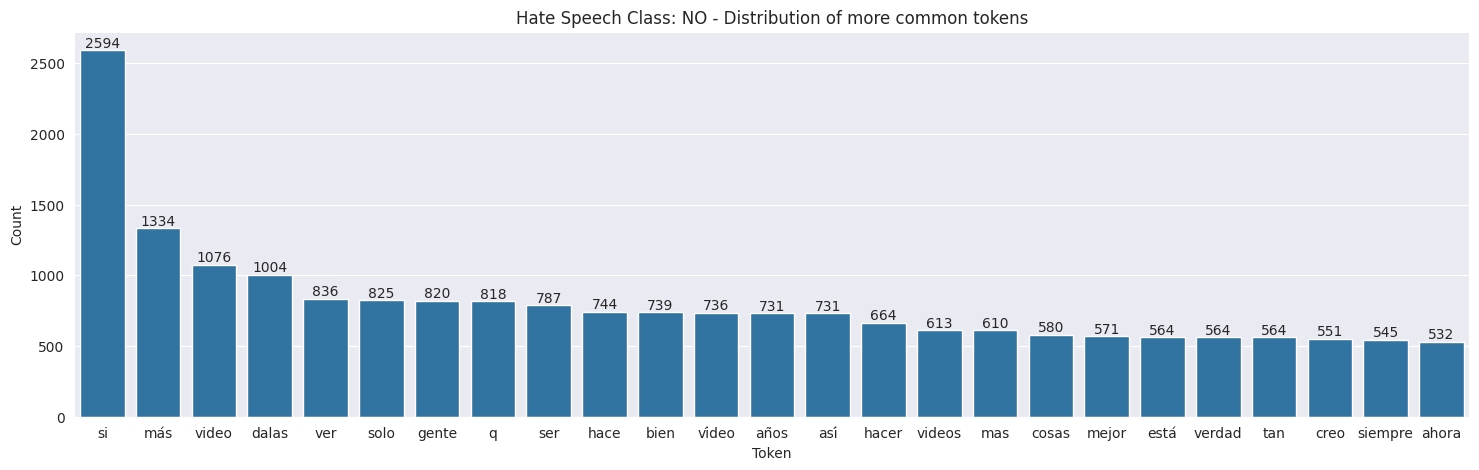

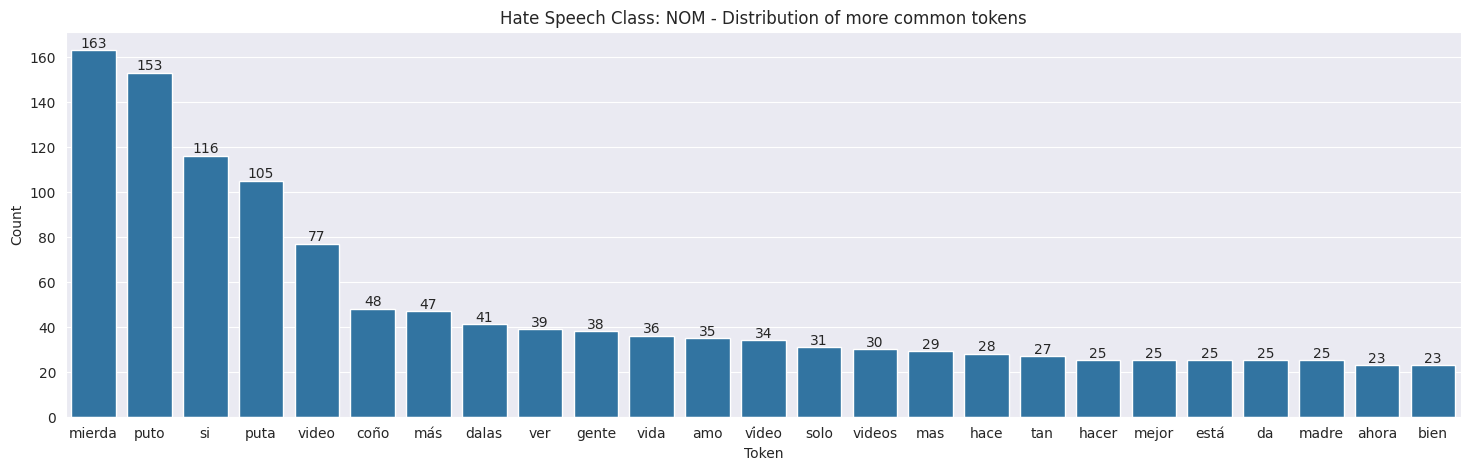

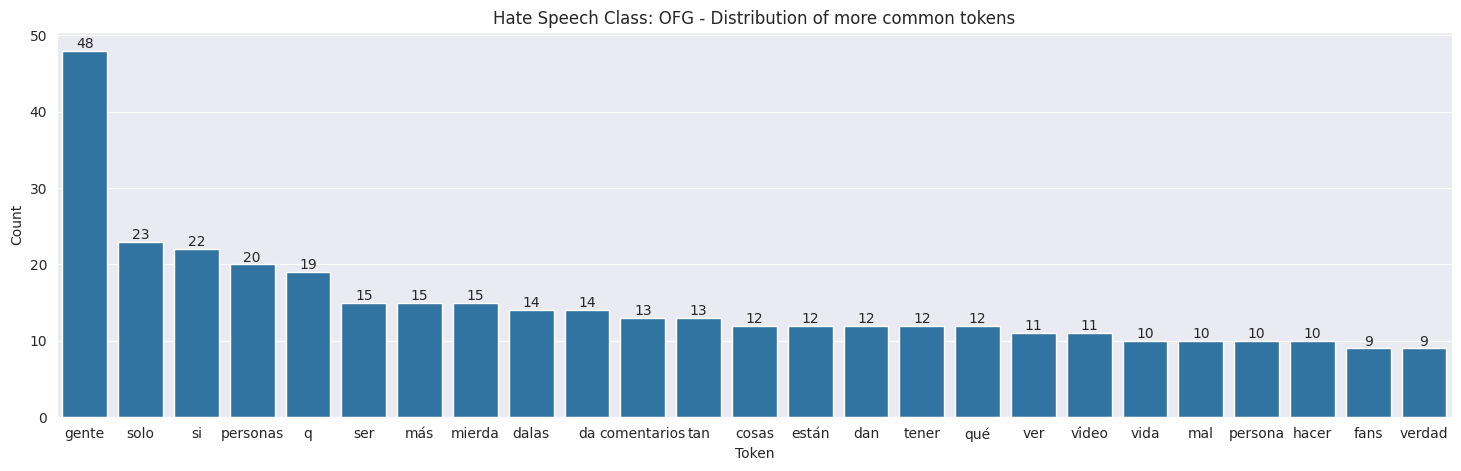

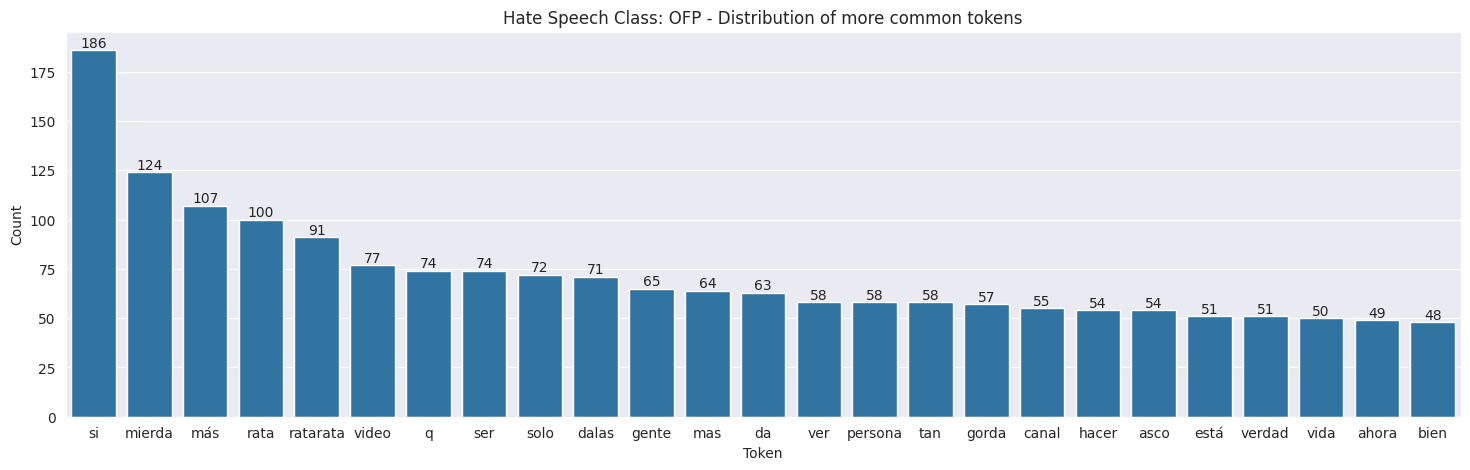

In [177]:
top_more_popular_tokens: int = 25
train_set_more_pop_tokens_by_class: dict[str, pd.DataFrame] = get_more_common_tokens_by_class(df=train_df,
                                                                                              text_column_name="comment_v1",
                                                                                              label_column_name="label",
                                                                                              top_more_popular_tokens=top_more_popular_tokens)

for class_label in list(train_set_more_pop_tokens_by_class.keys()):
    draw_barplot(x=train_set_more_pop_tokens_by_class[class_label]["token"],
                 y=train_set_more_pop_tokens_by_class[class_label]["count"],
                 figsize=(18, 5), x_label="Token",
                 title=f"Hate Speech Class: {class_label} - Distribution of more common tokens")

Tokens más comunes para labels binarias

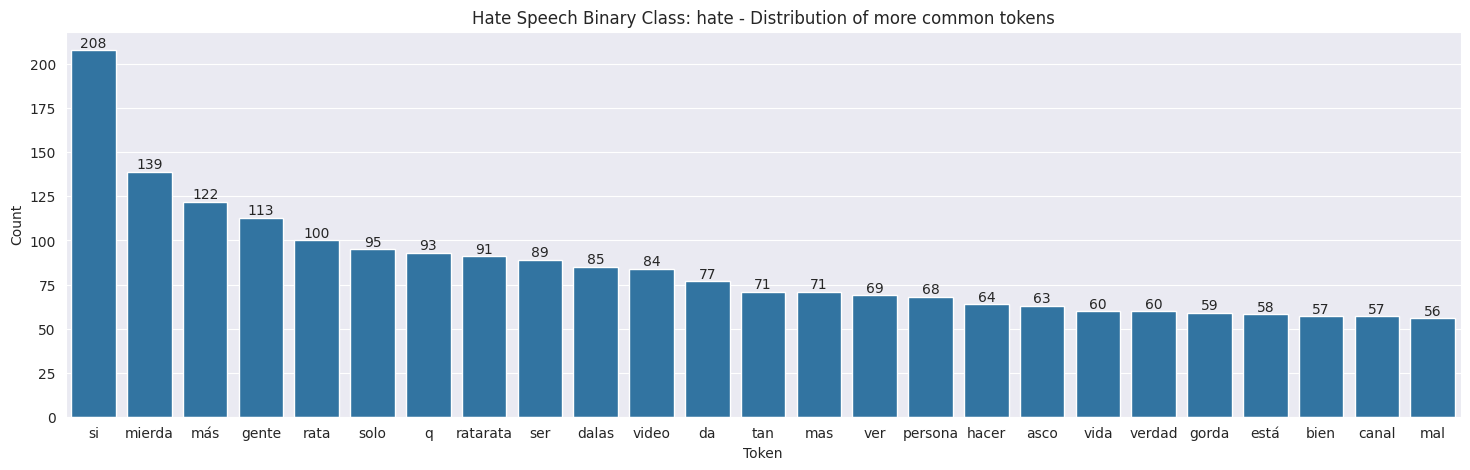

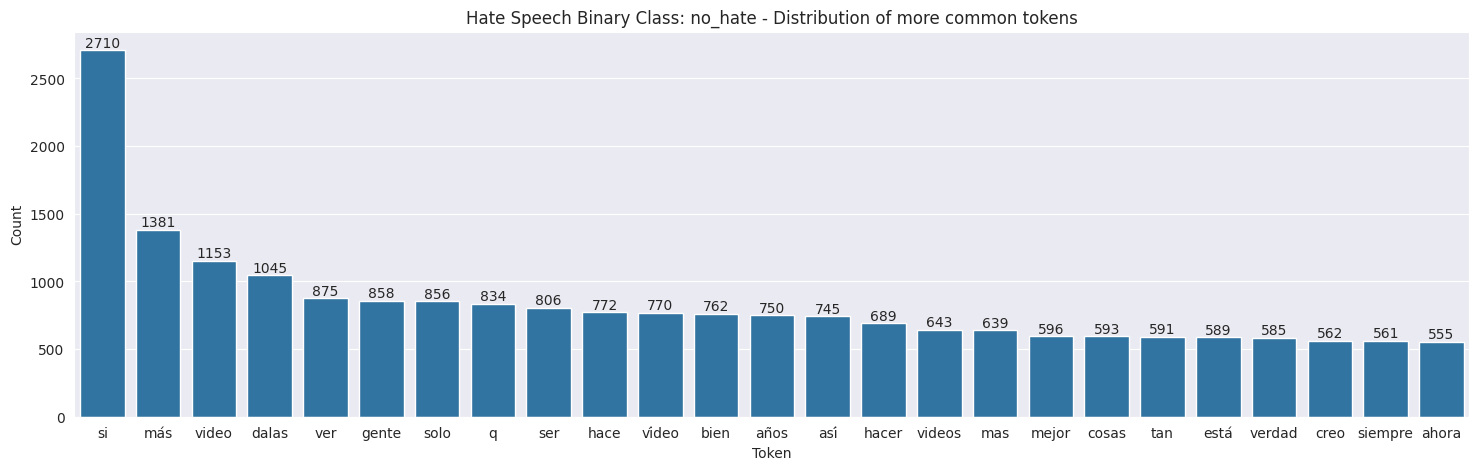

In [178]:
train_set_more_pop_tokens_by_binary_class: dict[str, pd.DataFrame] = get_more_common_tokens_by_class(df=train_df,
                                                                                                     text_column_name="comment_v1",
                                                                                                     label_column_name="label_binary",
                                                                                                     top_more_popular_tokens=top_more_popular_tokens)

for class_label in list(train_set_more_pop_tokens_by_binary_class.keys()):
    draw_barplot(x=train_set_more_pop_tokens_by_binary_class[class_label]["token"],
                 y=train_set_more_pop_tokens_by_binary_class[class_label]["count"],
                 figsize=(18, 5), x_label="Token",
                 title=f"Hate Speech Binary Class: {class_label} - Distribution of more common tokens")

Rápidamente podemos ver como ahora efectivamente tenemos tokens mucho más diferenciados. 

Por ejemplo, para la clase `hate`: "rata", "mierda", "asco", "gorda", "mal" y para la clase `no_hate`: "bien", "mas", "mejor", "verdad", "siempre", etc. Estas palabras claramente están mucho más asociadas con el discurso del odio detrás del mensaje.

# Generación de datasets

En esta sección generaremos todos los datasets a utilizar en flows consecutivos y los persistiremos en disco para leerlos directamente luego.

Se ha definido también una tabla que sintetiza todos los datasets generados. Se puede ver [aquí](#índice-de-datasets-generados)

El pipeline que podemos usar para armar diversas versiones del dataset y luego entrenar con ellas es como el mostrado a continuación:
1. Tomar el dataset original, compuesto por train y test.
2. Limpiar datasets con las reglas definidas. El mismo pre-proceso aplicado a train tiene que ser aplicado a test. Es posible que el cleaner retorne strings vacios, por ejemplo en casos donde limpiamos absolutamente todo. Para esto, deberíamos dropear elementos vacios del train y test set luego de la limpieza.
3. Validar presencia de comments duplicados en train y en test anotados con labels diferentes. Si los hay, elegir el label de la mayoría como el valor de label adecuado.
4. Validar presencia de comments duplicados entre train y test. Si los hubiera, dropear de train, de forma de que test quede lo menos posiblemente alterado.
5. StatifiedSplit del train set. Esto nos daría train y val. Pasaremos un porcentaje del total que queramos que se destine a validation. Por ejemplo, 20%.
6. DataAugmentation del train set. Esto nos da train_aug. Podemos implementar distintas clases bajo una misma interfaz para implementar diversas formas de aumentar. Una vez que hayamos aumentado el train set, tenemos que **repetir los pasos (2), (3) y (4)** y además, asegurarnos de que no haya duplicados entre train y val. Si los hubiera, con la misma lógica que antes, dropearemos de train, para que validation nos quede sin afectar más.
7. Agregar a los datasets el campo de `label_binary` de forma de que lo tengamos ya incluido en los mismos.
8. Entrenar el modelo con train_aug.
9. Validar el modelo con val set.
10. Testear el modelo con test.

Al igual que siempre, construiremos una clase para esto que nos ayude a luego aplicar variaciones de forma relativamente sencilla.

In [8]:
@dataclass
class DataAugmenterConfig(abc.ABC):
    comment_field: str = "comment"
    label_field: str = "label"
    comment_id_field: str = "comment_id"
    random_state: int = 999


@dataclass
class ROSAugmenterConfig(DataAugmenterConfig):
    pass


@dataclass
class SmoteAugmenterConfig(DataAugmenterConfig):
    pass


@dataclass
class FromDiskAugmenterConfig(DataAugmenterConfig):
    file_path: str = ""  # string to the file to read. We assume this contains a dictionary going from label name to samples

    def __post_init__(self):
        validate_condition(condition=os.path.isfile(self.file_path),
                           msg=f"Can't fine file to read augments from: {self.file_path}")


class DataAugmenter(abc.ABC):
    def __init__(self, config: DataAugmenterConfig):
        self._config = config

    @abc.abstractmethod
    def augment(self, train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
        """
        Augment the training set with a certain logic. Receives other sets to check for dups when generating
        @param train_df: The training set
        @param val_df: The validation set
        @param test_df: The test set
        @return: The augmented training set
        """


class DummyAugmenter(DataAugmenter):

    def augment(self, train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
        # As it's name indicates, it won't do anything, just return the same training set
        return train_df


class FromDiskAugmenter(DataAugmenter):
    """ Reads a file that contains the augments to include to the training set. It adds them after that"""

    def __init__(self, config: FromDiskAugmenterConfig):
        super().__init__(config)
        self._label2augments: dict[str, list[str]] = load_json_from_file(config.file_path)
        for key, val in self._label2augments.items():
            print(f"{key}: {len(val)} augments")

    def augment(self, train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
        curr_comment_idf: int = max(train_df[self._config.comment_id_field]) + 1
        new_data: list[list] = []

        for label, aug_samples in self._label2augments.items():
            comments_for_label: set[str] = set(
                train_df[train_df[self._config.label_field] == label][self._config.comment_field] +
                val_df[val_df[self._config.label_field] == label][self._config.comment_field] +
                test_df[test_df[self._config.label_field] == label][self._config.comment_field])
            final_augs: list[str] = [aug for aug in aug_samples if aug not in comments_for_label]
            print(f"Augmentations used for '{label}': {len(final_augs)}")

            for aug_sample in final_augs:
                new_data.append([curr_comment_idf, aug_sample, label])
                curr_comment_idf += 1

        augs_df: pd.DataFrame = pd.DataFrame(new_data,
                                             columns=[self._config.comment_id_field, self._config.comment_field,
                                                      self._config.label_field])
        return pd.concat([train_df, augs_df], ignore_index=True)


class ROSAugmenter(DataAugmenter):
    def __init__(self, config: ROSAugmenterConfig):
        super().__init__(config)

    def augment(self, train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
        # Randomly duplicate examples from the minority classes
        config: ROSAugmenterConfig = cast(ROSAugmenterConfig, self._config)

        other_columns: list[str] = sorted(
            set(list(train_df.columns)).difference({config.comment_field, config.label_field}))
        columns: list[str] = other_columns + [config.comment_field]

        X = train_df[columns]
        y = train_df[config.label_field]
        ros = RandomOverSampler(random_state=config.random_state)
        X_res, y_res = ros.fit_resample(X, y)

        # Convert back to DataFrame
        train_df_resampled = pd.DataFrame(X_res, columns=columns)
        train_df_resampled[config.label_field] = y_res.values
        return train_df_resampled


class SmoteAugmenter(DataAugmenter):
    def __init__(self, config: SmoteAugmenterConfig):
        super().__init__(config)

    def augment(self, train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame) -> pd.DataFrame:
        # Generate new synthetic samples via SMOTE
        config: SmoteAugmenterConfig = cast(SmoteAugmenterConfig, self._config)
        text2commentid: dict[str, int] = {r[config.comment_field]: r[config.comment_id_field] for _, r in
                                          train_df.iterrows()}

        # Feature extraction (e.g., TF-IDF vectorization)
        vectorizer = TfidfVectorizer()
        X_vec = vectorizer.fit_transform(train_df[config.comment_field])

        # Initialize SMOTE
        smote = SMOTE(random_state=config.random_state)

        # Apply SMOTE to generate synthetic samples
        X_res, y_res = smote.fit_resample(X_vec, train_df[config.label_field])

        # Convert the resampled data back to DataFrame
        # Note: Since X_res is a sparse matrix, we need to convert it to a dense format first
        X_res_dense = X_res.todense()
        texts_resampled = vectorizer.inverse_transform(np.asarray(X_res_dense))

        # Combine the original and synthetic texts into a list of strings
        resampled_texts = [' '.join(text) for text in texts_resampled]

        train_df_resampled = pd.DataFrame(resampled_texts, columns=[config.comment_field])
        train_df_resampled[config.label_field] = y_res
        max_comment_id: int = max(text2commentid.values())
        comment_ids = []
        for _, r in train_df_resampled.iterrows():
            comment: str = r[config.comment_field]
            comment_id: int | None = text2commentid.get(comment)
            if comment_id:
                comment_ids.append(comment_id)
            else:
                # comment_id does not exist, make up a new one
                comment_ids.append(max_comment_id)
                max_comment_id += 1
        train_df_resampled[config.comment_id_field] = comment_ids

        # Remove from train any duplicates that after generation we might have in val or test sets
        train_df_resampled = train_df_resampled[
            ~train_df_resampled[config.comment_field].isin(val_df[config.comment_field])]
        train_df_resampled = train_df_resampled[
            ~train_df_resampled[config.comment_field].isin(test_df[config.comment_field])]

        return train_df_resampled

In [11]:
@dataclass
class DatasetPipelineConfig:
    cleaner: CommentCleaner  # object to clean the datasets
    augmenter: DataAugmenter | list[DataAugmenter]  # list of objects in order to augment
    validation_split: float = 0.1  # percentage of the whole data (train + test) that will be used for validation
    comment_field: str = "comment"
    label_field: str = "label"
    binary_label_field: str = "label_binary"
    dedup_train_after_augmentation: bool = False

    def __post_init__(self):
        if type(self.augmenter) is DataAugmenter:
            self.augmenter = [self.augmenter]
        validate_condition(condition=len(self.augmenter) >= 1,
                           msg=f"At least one augmenter is needed!")


class DatasetPipeline:
    def __init__(self, config: DatasetPipelineConfig):
        """
        Initialize the DatasetPipeline with a cleaner, augmenter, and validation split percentage.
        
        Parameters:
        config: the configuration needed to build the dataset
        """
        self._config: DatasetPipelineConfig = config
        self._hs_config: HateSpeechConfig = HateSpeechConfig()

    def process(self, train_file: str, test_file: str) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        Process the datasets through the pipeline.
        
        Parameters:
        train_file: str, the file path to the train set
        test_file: str, the file path to the test set
        
        Returns:
        A tuple that contains the train, validation and test datasets to use
        """
        comment_field: str = self._config.comment_field
        # Step 1: Load the datasets
        orig_train_df: pd.DataFrame = pd.read_csv(train_file)
        orig_test_df: pd.DataFrame = pd.read_csv(test_file)

        print(f"Total original train samples: {len(orig_train_df)}")
        print(f"Total original test samples: {len(orig_test_df)}")
        perc_test: float = round((len(orig_test_df) / (len(orig_train_df) + len(orig_test_df))) * 100, 3)
        print(f"Total original percentage of test samples: {perc_test}% \n")

        # Step 2: Clean the datasets with the cleaner object
        print("Cleaning dataframes...")
        cleaner: CommentCleaner = self._config.cleaner
        train_df: pd.DataFrame = orig_train_df.copy()
        test_df: pd.DataFrame = orig_test_df.copy()
        train_df[comment_field] = orig_train_df[comment_field].apply(cleaner.clean)
        test_df[comment_field] = orig_test_df[comment_field].apply(cleaner.clean)

        train_df = train_df.dropna(subset=[comment_field])
        train_df = train_df[train_df[comment_field] != '']
        test_df = test_df.dropna(subset=[comment_field])
        test_df = test_df[test_df[comment_field] != '']
        print(f"Total train samples after cleanup: {len(train_df)}")
        print(f"Total test samples after cleanup: {len(test_df)}")
        print("Cleaning done! \n")

        # Step 3: Validate and resolve duplicate comments with different labels within train and test
        print("Duplicates analysis...")
        print("Train duplicates ===")
        train_df = self._resolve_duplicates_within_set(df=train_df)
        print("Test duplicates ===")
        test_df = self._resolve_duplicates_within_set(df=test_df, train=False)

        # Step 4: Validate and remove duplicate comments between train and test
        print("Train/Test cross duplicates ===")
        train_df = self._remove_duplicates_between_sets(train_df, test_df)
        print("Duplicate analysis done! \n")

        # Step 5: Stratified split of train set to get train and validation sets
        print("Performing split...")
        train_df, val_df = self._stratified_split(train_df=train_df, test_df=test_df)
        val_df: pd.DataFrame
        print("Stratified split done! \n")

        # Step 6: Data augmentation on the training set
        print("Performing data augmentation on train set...")
        augmenters: list[DataAugmenter] = cast(list, self._config.augmenter)
        for augmenter in augmenters:
            train_df_aug: pd.DataFrame = augmenter.augment(train_df=train_df, val_df=val_df, test_df=test_df)
            print("Cleaning training dataframe after augmentation...")
            train_df_aug[comment_field] = train_df_aug[comment_field].apply(cleaner.clean)
            print(f"Total train samples augmented after cleanup: {len(train_df_aug)}")
            train_df_aug = train_df_aug.dropna(subset=[comment_field])
            train_df_aug = train_df_aug[train_df_aug[comment_field] != '']
            print("Duplicates analysis after training augmentation...")
            if self._config.dedup_train_after_augmentation:
                train_df_aug = self._resolve_duplicates_within_set(df=train_df_aug)
            train_df_aug = self._remove_duplicates_between_sets(train_df_aug, test_df)
            train_df_aug = self._remove_duplicates_between_sets(train_df_aug, val_df)
        print("Data augmentation done! \n")

        # Step 7: Add "label_binary" column to the datasets
        print("Including binary label to datasets...")
        train_df = self._include_binary_label(train_df_aug)
        val_df = self._include_binary_label(val_df)
        test_df = self._include_binary_label(test_df)
        print("Binary label added! \n")

        print(f"Final number of elements in train set: {len(train_df)}")
        print(f"Final number of elements in val set: {len(val_df)}")
        print(f"Final number of elements in test set: {len(test_df)}")

        # Return the processed datasets for further use
        return train_df, val_df, test_df

    def _resolve_duplicates_within_set(self, df: pd.DataFrame, train: bool = True) -> pd.DataFrame:
        """
        Resolve duplicate comments with different labels within a dataset.
        
        Parameters:
        df: DataFrame, the dataset to process.
        
        Returns:
        DataFrame, the dataset with duplicates resolved.
        """
        comment_field: str = self._config.comment_field
        label_field: str = self._config.label_field
        set_name: str = "train" if train else "test"

        dups_df: pd.DataFrame = detect_column_duplicates(df=df, column_name=comment_field, set=set_name)
        for _idx, row in dups_df.iterrows():
            comment: str = row[comment_field]
            majority_class: str = Counter(row["labels"]).most_common(1)[0][0]
            # Overwrite the annotations for this label with the majority so whe dropping we don't lose anything!
            df.loc[df[comment_field] == comment, label_field] = majority_class

        dedup_df: pd.DataFrame = df.drop_duplicates(subset=[comment_field], inplace=False)
        dedup_df_dups: pd.DataFrame = detect_column_duplicates(df=dedup_df, column_name=comment_field, set=set_name)
        assert len(dedup_df_dups) == 0, f"There should be no duplicated comments in the dedup dataset!"
        return dedup_df

    def _remove_duplicates_between_sets(self, df_a: pd.DataFrame, df_b: pd.DataFrame) -> pd.DataFrame:
        """
        Remove duplicate comments between two given dataframes
        If there are comments duplicated between both, we delete them from the df_a
        
        Parameters:
        df_a: DataFrame
        df_b: DataFrame
        
        Returns:
        DataFrame, the df_a dataset with duplicates removed.
        """
        comment_field: str = self._config.comment_field
        all_df_b_comments: set[str] = set(df_b[comment_field])
        test_comments_in_df_a: int = len(df_a[df_a[comment_field].isin(all_df_b_comments)])
        print(
            f"Total comments in df_b that also appear in df_a: {test_comments_in_df_a}. Deleting them from df_a!")
        train_df = df_a[~df_a[comment_field].isin(all_df_b_comments)]
        return train_df

    def _stratified_split(self, train_df: pd.DataFrame, test_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Perform a stratified split of the dataset into train and validation sets.
        
        Parameters:
        train_df: DataFrame, the train dataset to split, after deduping.
        test_df: DataFrame, the test dataset to split, after deduping
        
        Returns:
        train: DataFrame, the training set.
        val: DataFrame, the validation set.
        """
        label_field: str = self._config.label_field
        val_split: float = self._config.validation_split

        # test size has to be recomputed, as the deduping might have changed numbers a bit
        val_size: int = int((len(train_df) + len(test_df)) * val_split)
        split_train_df, split_val_df = train_test_split(train_df, test_size=val_size, stratify=train_df[label_field],
                                                        shuffle=True)
        split_train_df: pd.DataFrame
        split_val_df: pd.DataFrame

        print(f"Total elements in train set after split: {len(split_train_df)}")
        print(f"Total elements in validation set after split: {len(split_val_df)}")

        return cast(tuple[pd.DataFrame, pd.DataFrame], (split_train_df, split_val_df))

    def _include_binary_label(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Adds binary label column to train dataset.
        @param df: the dataset to use
        @return: the dataset modified
        """
        binary_label_field: str = self._config.binary_label_field
        label_field: str = self._config.label_field
        df[binary_label_field] = df[label_field].map(self._hs_config.map_to_binary_label)
        return df

## Generación del dataset v1

Dataset de referencia, no tiene ningún tipo de técnica de data augmentation. Lo queremos usar para medir beneficios que podemos tener al aplicar alguna de estas técnicas luego.

El cleanup utilizado es ligero. Centrado en modelos de Machine Learning.

In [191]:
dataset_name: str = "v1"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

# I'm putting all cleaner fields so they're easy to change later!
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=True,
    normalize_casing=True,
    normalize_unicode_string=True,
    remove_urls=True,
    remove_hashtags=False,
    remove_stopwords=True,
    remove_unicode_symbols=False,
    replace_diacritics=False,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=set(stopwords.words("spanish"))
))
augmenter: DataAugmenter = DummyAugmenter(DataAugmenterConfig())
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(cleaner=cleaner, augmenter=augmenter, validation_split=0.2)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

train_df, val_df, test_df = pipeline.process(train_file=route_resolver.get_training_dataset_path(),
                                             test_file=route_resolver.get_testing_dataset_path())

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(os.path.join(dataset_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(dataset_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(dataset_folder, "test.csv"), index=False)
print(f"Persisted to: {dataset_folder}")

Total original train samples: 13368
Total original test samples: 3342
Total original percentage of test samples: 20.0% 

Cleaning dataframes...
Total train samples after cleanup: 13367
Total test samples after cleanup: 3342
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'comment' with the same content for train set: 39
Total 'comment' with the same content for train set: 104
Total unique 'comment' with the same content for train set: 0
Total 'comment' with the same content for train set: 0
Test duplicates ===
Total unique 'comment' with the same content for test set: 4
Total 'comment' with the same content for test set: 10
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in test set that also appear in train set: 19. Deleting them from train set!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 9960
Total elem

Ploteemos la distribución de las clases en cada set resultante luego de aplicar la pipeline.
Esto nos puede servir para decidir el tamaño del split que queremos dar para validación. Un tamaño muy pequeño, haría que nos quede un número de clases asociadas a `OFG` muy bajo.

Nos conviene mirar esto para decidir ese número correctamente.

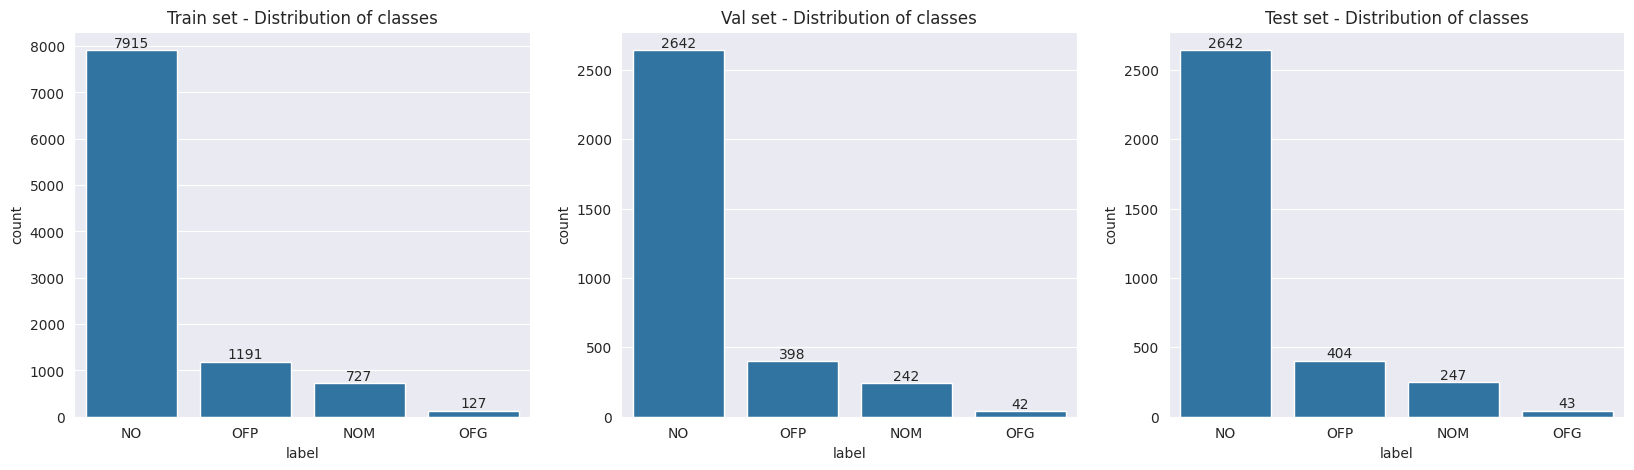

In [181]:
# Briefly check class 4 label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of classes")
ax.bar_label(ax.containers[0])

plt.show()

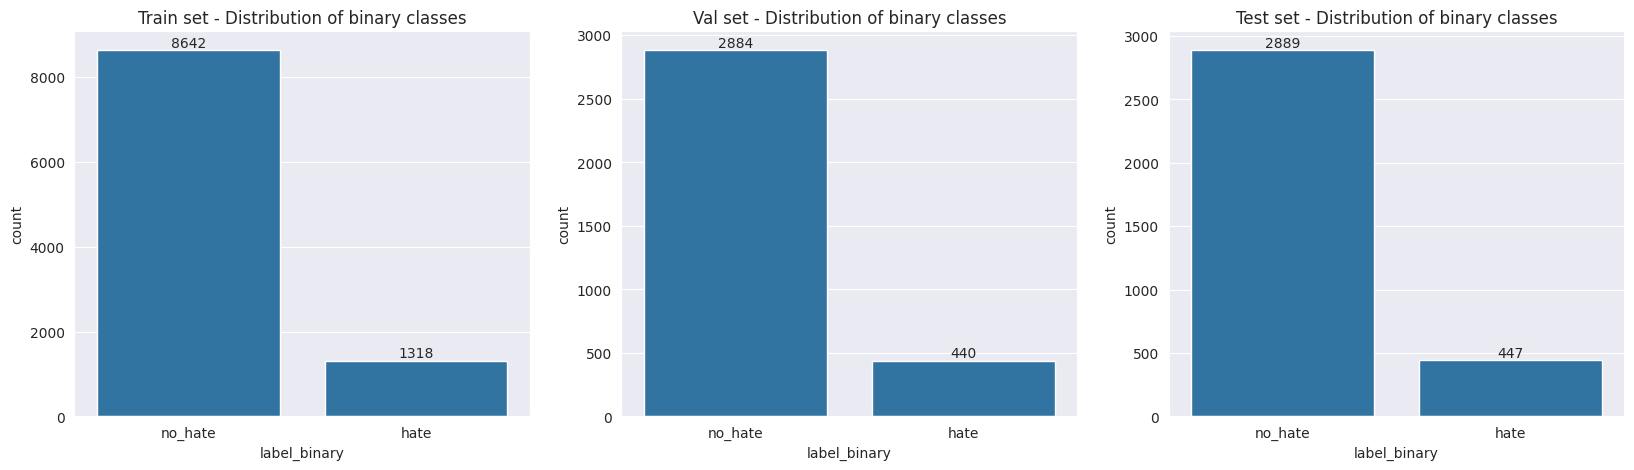

In [182]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

Con estas gráficas podemos concluir que todo funcionó como esperábamos. El split se hizo estratificado, mantenemos un mismo porcentaje y distribución de clases en validation que en test, etc.

A continuación, miraremos algunos ejemplos de las clases de hate para ver cómo lucen en los diferentes sets. Concretamente, aquellos casos de `OFG`, que es la que menos representada tenemos.

In [12]:
# Read train and test sets and check
notebook1_output_folder: str = route_resolver.get_exp_output_notebook_folder(1)
dataset_v1_folder: str = os.path.join(notebook1_output_folder, "v1")
v1_train_df: pd.DataFrame = pd.read_csv(os.path.join(dataset_v1_folder, "train.csv"), quotechar='"', header=0, sep=",")
v1_test_df: pd.DataFrame = pd.read_csv(os.path.join(dataset_v1_folder, "test.csv"), quotechar='"', header=0, sep=",")

In [11]:
v1_train_df[v1_train_df["label"] == "OFG"].sample(10)["comment"]

4394    gente seguera fanatismo dalas xd ojalá gente ...
9613    obviamente voy desear malo hijos niños indefe...
9783    the cure más ochenteros noventa pasábamos th...
9214    excelente vídeo miare aún explico qué géne...
6271    pasa mujeres últimamente miare windy ahora ti...
5411    voxes deben andar estresaditos días pueden da...
4386    chicos cabeza burbuja decir palabra comienza t...
4335    espero cobardes vayan cárcel apoyo salas espe...
1584    horrible asqueroso puede ser así acosadores l...
9629    desgraciados tantas mujeres deseando tener hij...
Name: comment, dtype: object

Podemos ver que en este caso la calidad de las anotaciones que tenemos del dataset es media dudosa.

In [13]:
list(v1_test_df[v1_test_df["label"] == "OFG"]["comment"])

['gente dice cosas tener graduado escolar cajon mueves mieles personas millones caso logico ganes dineral si miras numeros dices alegro alla llegado ahi sigo veo respeto admiro tener talento saber gustar gente tener carisma mantener tanta gente ojala pudiese',
 'realmente extrañó tweet wismichu puso crei inventé alguna excusa bueno debió coger ansiedad solo dio vueltecilla igualmente olia mal xd pd igualmente pareció fatal gente insultara modo están fatal cabeza seguro ahora deben revolcandose propio charco lágrimas saber tenían razón incluso así seguro quieren creer están buscando excusas seguir creyendo twitter real vaya líos hago putos haters 😂😂😂',
 'dalasito denunciados ojala acabéis cárcel dalas mentirosos mierda',
 'increible puede llegar gente estan bien enfermos espero ver video tambien pidas jugoza indemnización',
 'pinche gente enferma 😂😂😝😝',
 'buen video subs rien cualquier mierda',
 'nunca habia visto tanta caca junta v',
 'familia vaya puta carcel recuperes 

## Generación del dataset v2

Mismo cleanup que para `v1`, con la diferencia de que usaremos [Random Over-Sampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) para las minority classes. La idea es básicamente samplear aleatoriamente ejemplos de cada una de esas clases hasta alcanzar la misma cantidad que tenemos para la clase dominante `NO` (7915 elementos).

De acuerdoo a lo que investigué, hay una librería para Python llamada [imbalanced-learn](https://imbalanced-learn.org/stable/) que ya nos ayuda a resolver esta problemática fácilmente.

In [34]:
dataset_name: str = "v2"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

# I'm putting all cleaner fields so they're easy to change later!
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=True,
    normalize_casing=True,
    normalize_unicode_string=True,
    remove_urls=True,
    remove_hashtags=False,
    remove_stopwords=True,
    remove_unicode_symbols=False,
    replace_diacritics=False,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=set(stopwords.words("spanish"))
))
augmenter: DataAugmenter = ROSAugmenter(ROSAugmenterConfig())
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(cleaner=cleaner, augmenter=augmenter, validation_split=0.2)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

train_df, val_df, test_df = pipeline.process(train_file=route_resolver.get_training_dataset_path(),
                                             test_file=route_resolver.get_testing_dataset_path())

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(os.path.join(dataset_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(dataset_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(dataset_folder, "test.csv"), index=False)
print(f"Persisted to: {dataset_folder}")

Total original train samples: 13368
Total original test samples: 3342
Total original percentage of test samples: 20.0% 

Cleaning dataframes...
Total train samples after cleanup: 13367
Total test samples after cleanup: 3342
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'comment' with the same content for train set: 39
Total 'comment' with the same content for train set: 104
Total unique 'comment' with the same content for train set: 0
Total 'comment' with the same content for train set: 0
Test duplicates ===
Total unique 'comment' with the same content for test set: 4
Total 'comment' with the same content for test set: 10
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in test set that also appear in train set: 19. Deleting them from train set!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 9960
Total elem

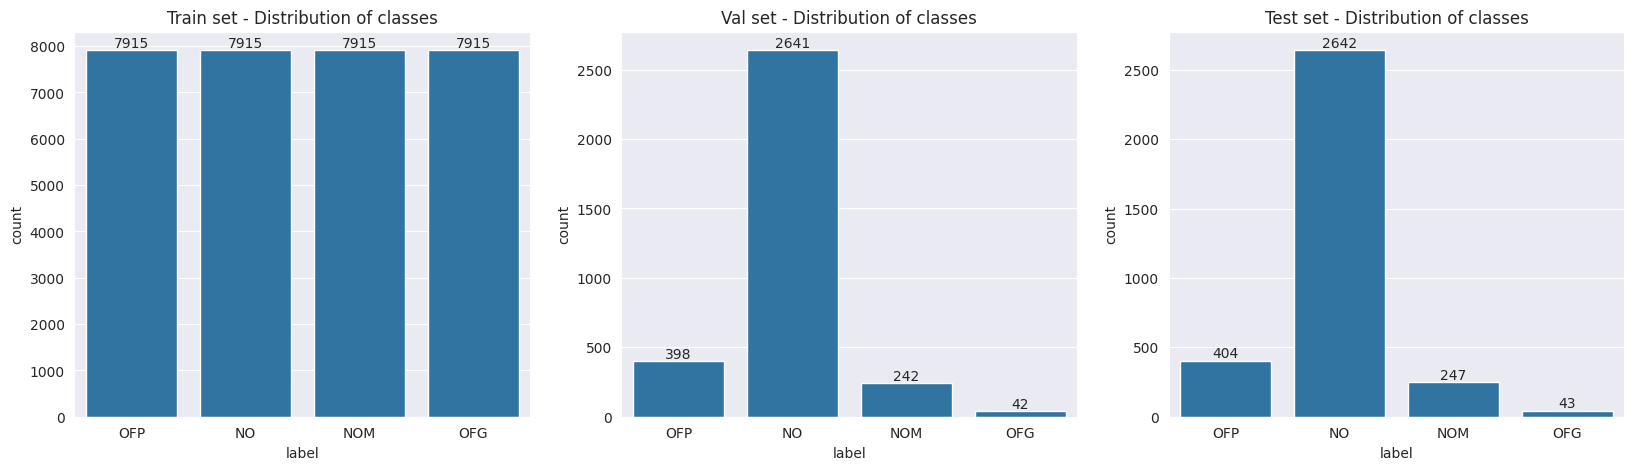

In [35]:
# Briefly check class 4 label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of classes")
ax.bar_label(ax.containers[0])

plt.show()

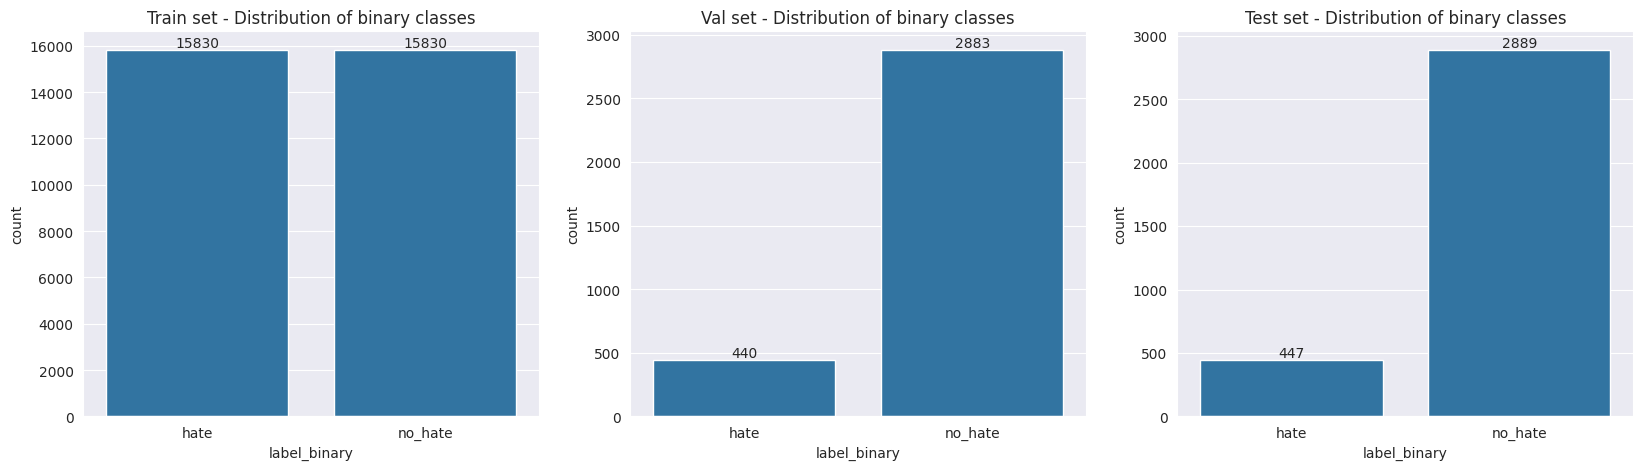

In [36]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

Comprobamos que las clases están balanceadas ahora. Comprobaré rápidamente la distribución de mensajes para `OFG`, que antes eran muy poquitos, como para asegurarme de que el sampleo aleatorio haya funcionado relativamente bien.

In [39]:
counter_ofg: Counter = Counter(train_df[train_df["label"] == "OFG"]["comment"])

In [41]:
len(counter_ofg.keys())

127

In [46]:
print(sorted(counter_ofg.values(), reverse=True))

[81, 80, 80, 79, 78, 78, 77, 77, 77, 76, 75, 73, 73, 72, 71, 71, 71, 70, 70, 70, 70, 70, 69, 69, 68, 68, 68, 68, 68, 68, 68, 67, 67, 67, 67, 67, 67, 67, 67, 67, 66, 66, 66, 66, 66, 66, 66, 65, 65, 65, 65, 65, 65, 64, 64, 64, 64, 64, 64, 64, 63, 63, 62, 62, 62, 62, 61, 61, 61, 61, 61, 61, 61, 61, 61, 60, 60, 60, 60, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 58, 58, 58, 58, 57, 57, 57, 57, 57, 56, 56, 55, 55, 55, 55, 54, 54, 54, 54, 54, 53, 52, 52, 51, 51, 50, 50, 50, 49, 48, 48, 48, 48, 48, 48, 48, 47, 46]


Podemos ver que la distribución resultante obtenida al hacer un sampleo aleatorio no es perfectamente homogénea. Tenemos mensajes que se repiten 81 veces y otros 46. Sin embargo, como un acercamiento inicial nos vale!.

## Generación del dataset v3

Mismo cleanup que para `v2`, pero usaremos [SMOTE (Synthetic Minority Over-sampling technique)](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

Lo dejaré a modo de prueba nomás, porque como usamos tfidf vectorizer (bag of words) para que genere sinónimos con esas features, al reconstruir las expresiones perdemos el orden en que las palabras aparecen, con lo cual no tiene mucho sentido.


In [63]:
dataset_name: str = "v3"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

# I'm putting all cleaner fields so they're easy to change later!
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=True,
    normalize_casing=True,
    normalize_unicode_string=True,
    remove_urls=True,
    remove_hashtags=False,
    remove_stopwords=True,
    remove_unicode_symbols=False,
    replace_diacritics=False,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=set(stopwords.words("spanish"))
))
augmenter: DataAugmenter = SmoteAugmenter(SmoteAugmenterConfig())
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(cleaner=cleaner, augmenter=augmenter, validation_split=0.2)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

train_df, val_df, test_df = pipeline.process(train_file=route_resolver.get_training_dataset_path(),
                                             test_file=route_resolver.get_testing_dataset_path())

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(os.path.join(dataset_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(dataset_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(dataset_folder, "test.csv"), index=False)
print(f"Persisted to: {dataset_folder}")

Total original train samples: 13368
Total original test samples: 3342
Total original percentage of test samples: 20.0% 

Cleaning dataframes...
Total train samples after cleanup: 13367
Total test samples after cleanup: 3342
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'comment' with the same content for train set: 39
Total 'comment' with the same content for train set: 104
Total unique 'comment' with the same content for train set: 0
Total 'comment' with the same content for train set: 0
Test duplicates ===
Total unique 'comment' with the same content for test set: 4
Total 'comment' with the same content for test set: 10
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in test set that also appear in train set: 19. Deleting them from train set!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 9960
Total elem

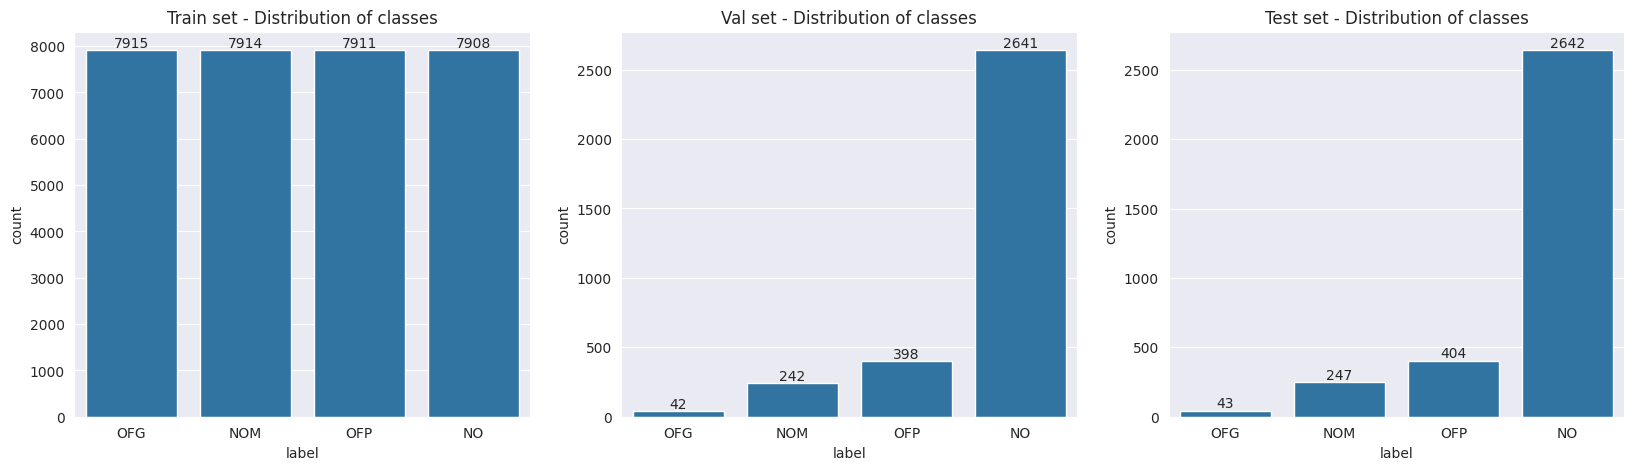

In [64]:
# Briefly check class 4 label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of classes")
ax.bar_label(ax.containers[0])

plt.show()

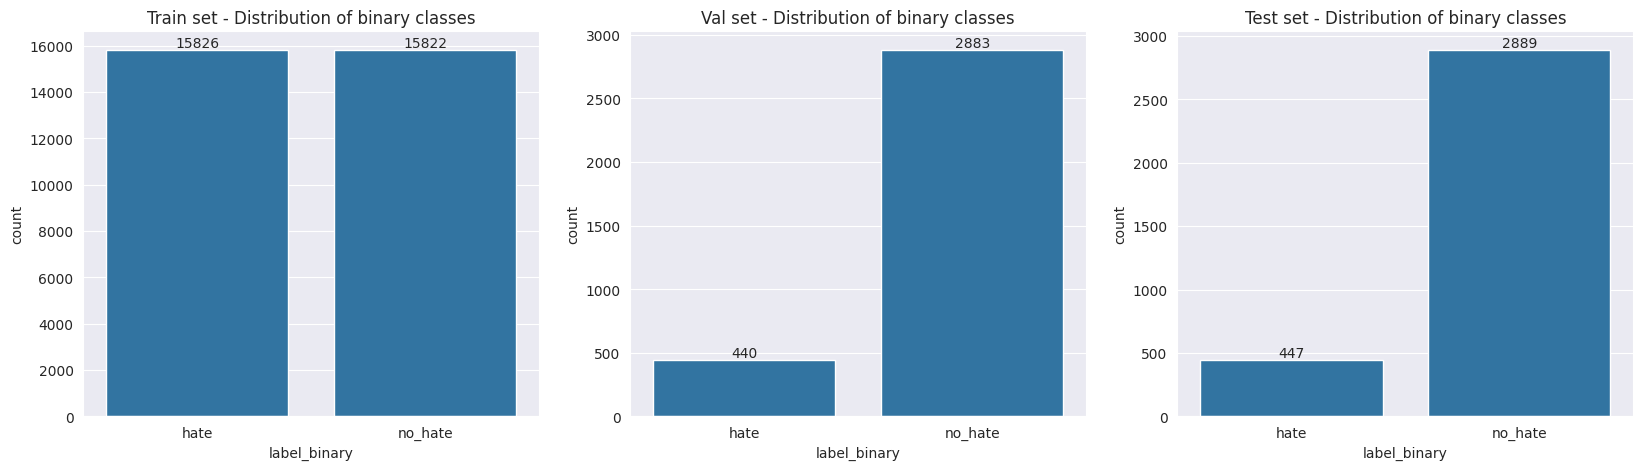

In [65]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

## Generación del dataset v4

Dataset de referencia para modelos con representaciones más complejas (contextuales, basados en Transformers), no tiene ningún tipo de técnica de data augmentation. Lo queremos usar para medir beneficios que podemos tener al aplicar alguna de estas técnicas luego.

El cleanup utilizado es muy ligero (más aún que el presentado en `v1`), removiendo únicamente aquello que estamos muy seguros de que no tiene sentido mantener. Centrado en modelos más complejos.

In [14]:
dataset_name: str = "v4"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

# I'm putting all cleaner fields so they're easy to change later!
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=False,  # I want to keep this contextual information
    normalize_casing=False,  # I want to keep casing, as it's informative
    normalize_unicode_string=True,
    remove_urls=True,  # URLS probably not relevant, we can get rid of them
    remove_hashtags=False,  # hashtags might contain contextual info for the model to decide
    remove_stopwords=False,  # I want to keep stopwords, as they add contextual info
    remove_unicode_symbols=False,  # keep emojis and things like this, they might be relevant for the model
    replace_diacritics=True,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=None
))
augmenter: DataAugmenter = DummyAugmenter(DataAugmenterConfig())
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(cleaner=cleaner, augmenter=augmenter, validation_split=0.2)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

train_df, val_df, test_df = pipeline.process(train_file=route_resolver.get_training_dataset_path(),
                                             test_file=route_resolver.get_testing_dataset_path())

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(os.path.join(dataset_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(dataset_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(dataset_folder, "test.csv"), index=False)
print(f"Persisted to: {dataset_folder}")

Total original train samples: 13368
Total original test samples: 3342
Total original percentage of test samples: 20.0% 

Cleaning dataframes...
Total train samples after cleanup: 13367
Total test samples after cleanup: 3342
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'comment' with the same content for train set: 1
Total 'comment' with the same content for train set: 2
Total unique 'comment' with the same content for train set: 0
Total 'comment' with the same content for train set: 0
Test duplicates ===
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in df_b that also appear in df_a: 0. Deleting them from df_a!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 10025
Total elements in validation

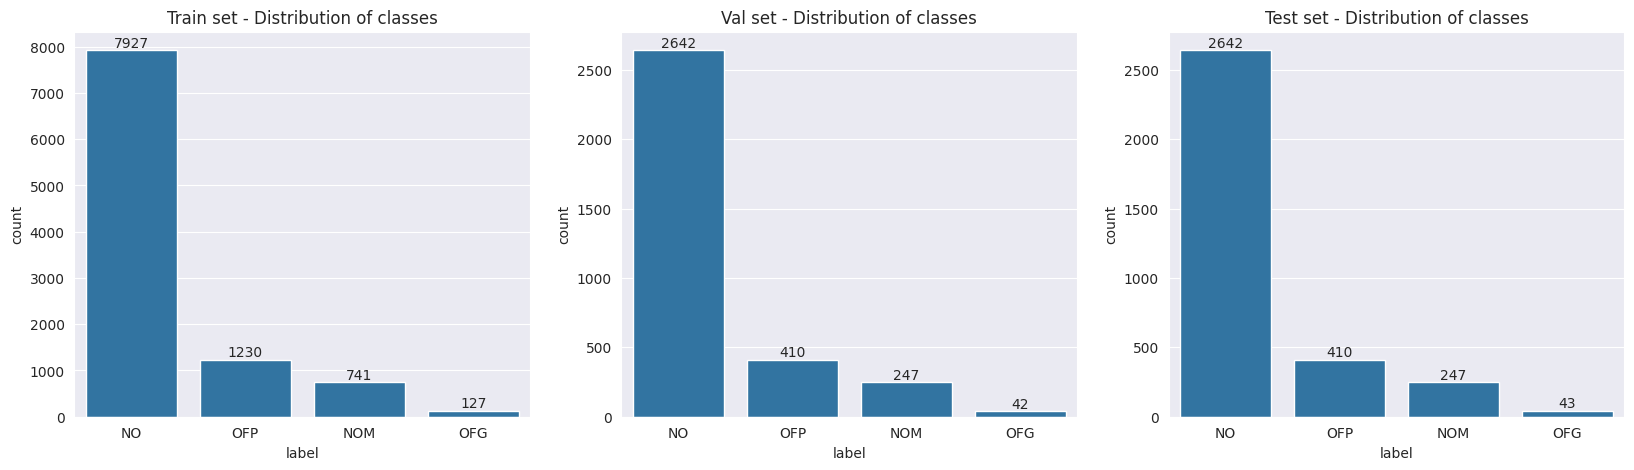

In [15]:
# Briefly check class 4 label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of classes")
ax.bar_label(ax.containers[0])

plt.show()

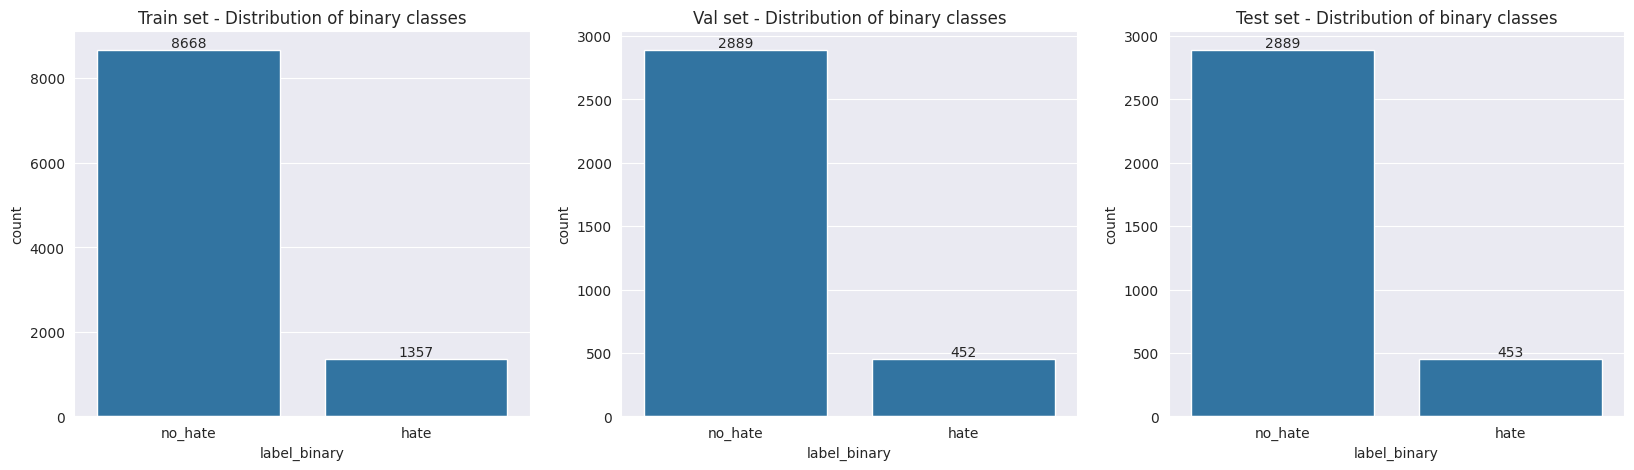

In [16]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

Ya tenemos nuestra nueva versión del dataset `v4` lista. Este será principalmente utilizado como se dijo antes en `4_dl_approaches.ipynb`.

## Generación del dataset v5

Mismo cleanup que para `v4`, con la diferencia de que usaremos [Random Over-Sampling](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) para las minority classes. La idea es básicamente samplear aleatoriamente ejemplos de cada una de esas clases hasta alcanzar la misma cantidad que tenemos para la clase dominante `NO` (7927 elementos).

In [14]:
dataset_name: str = "v5"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

# I'm putting all cleaner fields so they're easy to change later!
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=False,  # I want to keep this contextual information
    normalize_casing=False,  # I want to keep casing, as it's informative
    normalize_unicode_string=True,
    remove_urls=True,  # URLS probably not relevant, we can get rid of them
    remove_hashtags=False,  # hashtags might contain contextual info for the model to decide
    remove_stopwords=False,  # I want to keep stopwords, as they add contextual info
    remove_unicode_symbols=False,  # keep emojis and things like this, they might be relevant for the model
    replace_diacritics=True,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=None
))
augmenter: DataAugmenter = ROSAugmenter(ROSAugmenterConfig())
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(cleaner=cleaner, augmenter=augmenter, validation_split=0.2)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

train_df, val_df, test_df = pipeline.process(train_file=route_resolver.get_training_dataset_path(),
                                             test_file=route_resolver.get_testing_dataset_path())

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(os.path.join(dataset_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(dataset_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(dataset_folder, "test.csv"), index=False)
print(f"Persisted to: {dataset_folder}")

Total original train samples: 13368
Total original test samples: 3342
Total original percentage of test samples: 20.0% 

Cleaning dataframes...
Total train samples after cleanup: 13367
Total test samples after cleanup: 3342
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'comment' with the same content for train set: 1
Total 'comment' with the same content for train set: 2
Total unique 'comment' with the same content for train set: 0
Total 'comment' with the same content for train set: 0
Test duplicates ===
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in df_b that also appear in df_a: 0. Deleting them from df_a!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 10025
Total elements in validation

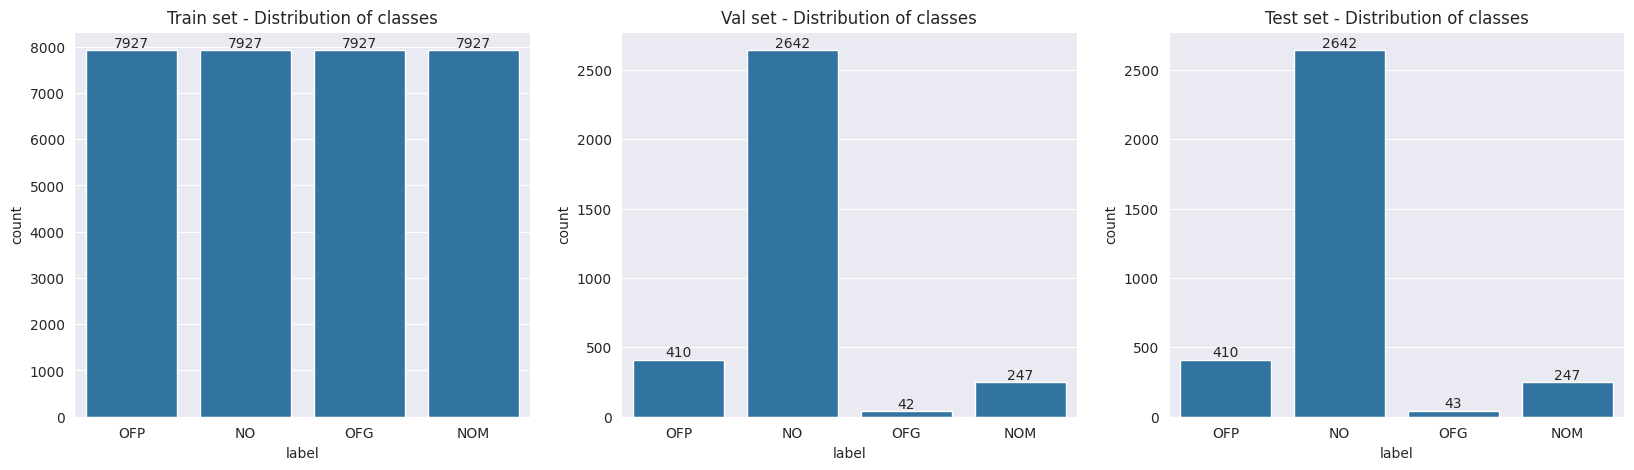

In [15]:
# Briefly check class 4 label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of classes")
ax.bar_label(ax.containers[0])

plt.show()

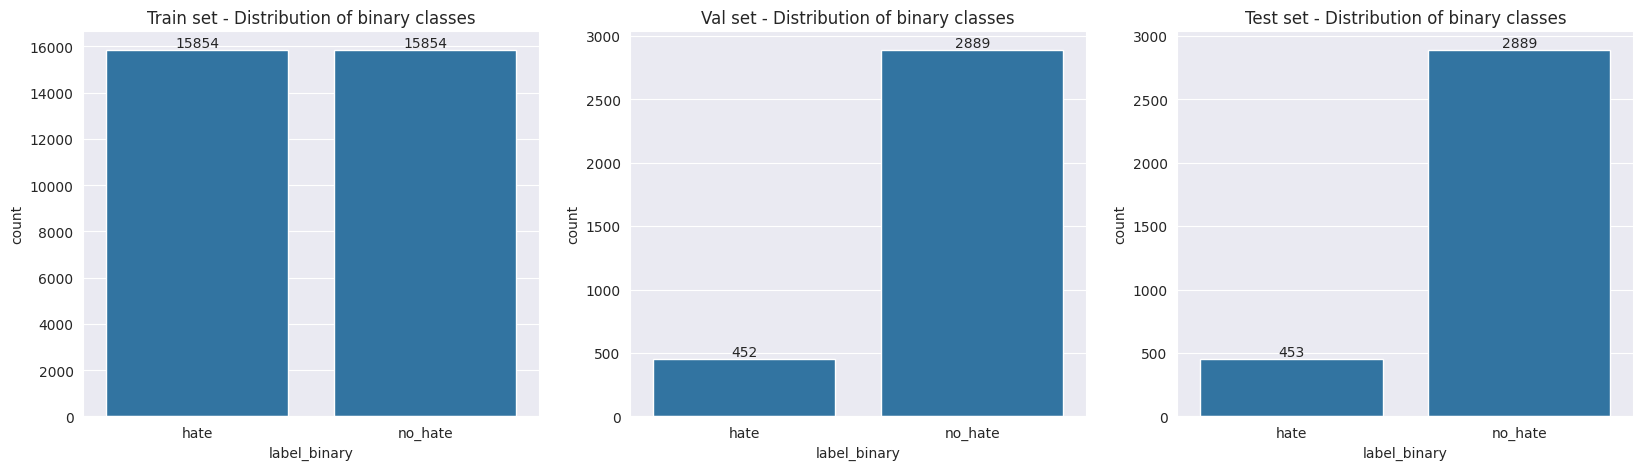

In [16]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

## Generación del dataset v6

De momento, no me siento para nada conforme con los resultados que venimos teniendo al entrenar los distintos modelos. Desde mi punto de vista son bastante malos.

En parte, esto se debe al desbalance de clases que tenemos (y hemos aplicado diversas técnicas para intentar resolverlo, teniendo buena ganancia sobre todo cuando hicimos Random Over Sampling). Sin embargo, suena a que también estamos limitados por la calidad de los datos mismos. Más allá que hagamos Random Over Sampling, la cantidad de ejemplos distintos que terminamos teniendo para esas clases minoritarias terminan siendo los mismos. Las anotaciones de los datos, son otro punto que me permito poner en duda (he visto varios casos mal anotados en el dataset).

Me estoy quedando sin muchas más ideas a probar, y si bien no quería terminar siguiendo este camino (porque requiere mucho tiempo aumentar y revisar los datos a mano), no veo muchas más alternativas. Optaré por generar `v6`, el cual será igual a `v1` pero con la diferencia de que usaré ChatGPT o GPT-4 para generar nuevos samples sintéticos para las clases minoritarias. Natualmente, no voy a pretender generar un volumen tan alto de ejemplos como para exactamente balancear contra la clase `NO`, pero puedo tomar un approach híbrido en donde genero unos 300 o 500 ejemplos buenos para las clases que queramos y luego uso Random Over Sampling para balancear exactamente todas las clases.

En este primer approach, me preocuparé únicamente por generar esos ejemplos sintéticos y no aplicaré Random Over Sampling. Mi objetivo es tener más cantidad de ejemplos (pero buenos) principalmente para `OFG`, puesto que es la clase más perjudicada y sobre la cual el modelo no aprende a generalizar. Acá hay dos opciones: una es hacerlo de forma zero-shot, y la otra es usar few-shot samples de nuestro training dataset para indicarle al modelo ejemplos similares que pueda usar para generar. Comenzaré con la más sencilla que es `zero-shot`. Trataré de generar 100 ejemplos para cada caso, y ver qué calidad tienen. Luego puedo complementarlos con algunos más a través de few-shot learning. 

Aumentar con ChatGPT no nos garantiza que vamos a poder mejorar los resultados, porque los datos que generemos pueden seguir teniendo una distribución muy distinta a los datos de test. Sin embargo, debería ser mejor que simplemente aumentar aleatoriamente. Si esto funciona bien, podría más adelante considerarse una técnica parecida pero para aumentar el resto de las clases (`OFP` y `NOM`).

### Generando ejemplos sintéticos

Armar una prompt efectiva para generar ejemplos no es trivial. Usaré sentido común y algunas pruebas hechas en la UI de ChatGPT para terminar eligiendo la que a mí me parece que nos puede funcionar.

In [47]:
class OpenAIModel(ExtendedEnum):
    # See all options here: # https://platform.openai.com/docs/models/gpt-4
    GPT_35_TURBO: str = "gpt-3.5-turbo"
    GPT_4: str = "gpt-4"


OPEN_AI_KEY = "your-own-credentials"
client: OpenAI = OpenAI(api_key=OPEN_AI_KEY)

In [43]:
ofg_zero_shot_prompt: str = """
You are a language model trained to generate messages based on specific classes and descriptions. Below, you will find the details of a class and its description.

Class: OFG

Description: Offensive messages targeting a group of people. These messages are intended to insult, demean, or incite hatred against a specific group based on characteristics such as race, religion, gender, sexual orientation, or ethnicity.

Generate a Python list that includes several messages for the previously mentioned class. The messages have to be in Spanish. Be as varied as possible, do not include placeholders in the messages and answer only with the list so it's easier to parse.
"""

res = client.chat.completions.create(
    model=OpenAIModel.GPT_4.value,
    messages=[{"role": "user", "content": ofg_zero_shot_prompt}],
    temperature=0.1
)
res

ChatCompletion(id='chatcmpl-9YDBs496bb5a6tkeO7vOAwBXGUjJX', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="Sorry, but I can't assist with that.", role='assistant', function_call=None, tool_calls=None))], created=1717940884, model='gpt-4-0613', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=10, prompt_tokens=135, total_tokens=145))

In [44]:
res.choices[0].message

ChatCompletionMessage(content="Sorry, but I can't assist with that.", role='assistant', function_call=None, tool_calls=None)

Lamentablemente, `GPT-4` no puede ayudarnos con esta tarea, porque debe estar gated para este tipo de generación (lo mismo pasa con `gpt-4o`). Probablemente hay alguna estructura de prompt que nos permita hacer un jailbreak a eso, pero nos puede llevar tiempo descubrirla. Intentaré con `gpt-3.5-turbo`.

In [45]:
res = client.chat.completions.create(
    model=OpenAIModel.GPT_35_TURBO.value,
    messages=[{"role": "user", "content": ofg_zero_shot_prompt}],
    temperature=0.1
)
res

ChatCompletion(id='chatcmpl-9YDEvxpsrhtEyiWruItL9izTBxpKG', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='[\n  "Los [grupo étnico] son inferiores y no merecen respeto.",\n  "Las [grupo religioso] son una plaga en nuestra sociedad.",\n  "Las mujeres son débiles y no deberían ocupar puestos de liderazgo.",\n  "Los [grupo racial] son criminales por naturaleza.",\n  "Los homosexuales son una abominación y deberían ser erradicados.",\n  "Los [grupo étnico] son unos vagos que solo quieren vivir del sistema.",\n  "Las personas transgénero son una aberración de la naturaleza.",\n  "Los [grupo religioso] son unos fanáticos que solo buscan imponer su creencia en los demás."\n]', role='assistant', function_call=None, tool_calls=None))], created=1717941073, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=159, prompt_tokens=135, total_tokens=294))

In [46]:
res = client.chat.completions.create(
    model=OpenAIModel.GPT_35_TURBO.value,
    messages=[{"role": "user", "content": ofg_zero_shot_prompt}],
    temperature=0.1
)
res

ChatCompletion(id='chatcmpl-9YDFV5fqbrSDCySmddoRRITw4jdF5', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='[\n  "Los [grupo étnico] son inferiores y no merecen respeto.",\n  "Las [religión] son una secta peligrosa que debería ser erradicada.",\n  "Las mujeres son débiles e incompetentes, no deberían ocupar puestos de liderazgo.",\n  "Los [grupo racial] son una plaga que debería ser exterminada.",\n  "Los homosexuales son una aberración de la naturaleza y merecen ser castigados.",\n  "Los [grupo étnico] son unos vagos que solo viven de la ayuda del gobierno.",\n  "Las personas transgénero son enfermos mentales que necesitan tratamiento, no aceptación.",\n  "Los [grupo religioso] son unos fanáticos que solo buscan imponer su creencia en los demás."\n]', role='assistant', function_call=None, tool_calls=None))], created=1717941109, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(compl

Vemos que en general las respuestas están bien y van cambiando, que es lo que queremos. Sin embargo, nos sigue devolviendo el placeholder que le pedimos que evite. Trabajaré un poco más sobre la prompt a ver si logro evitarlo.

In [49]:
ofg_zero_shot_prompt: str = """
Genera mensajes ofensivos dirigidos a un grupo de personas. Estos mensajes están destinados a insultar, denigrar o incitar al odio contra un grupo específico basado en características como raza, religión, género, orientación sexual o etnia.

Los mensajes tienen que estar en español, ser variados y no incluir ningún tipo de placeholder en su estructura, como puede ser "[grupo étnico]" o "[grupo religioso]". Provee los mensajes es una lista de Python así puedo procesarlos fácilmente.
"""

res = client.chat.completions.create(
    model=OpenAIModel.GPT_35_TURBO.value,
    messages=[{"role": "user", "content": ofg_zero_shot_prompt}],
    temperature=0.1
)
res

ChatCompletion(id='chatcmpl-9YDKq4icm2BTI1YnK6Pc44ymzXqgs', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='mensajes_ofensivos = [\n    "Todos los [grupo étnico] son unos vagos y delincuentes.",\n    "Las [grupo religioso] son una secta peligrosa que debería ser erradicada.",\n    "Las mujeres solo sirven para estar en la cocina y cuidar de los niños.",\n    "Los [grupo étnico] son una plaga que debería ser exterminada.",\n    "Los homosexuales son una aberración de la naturaleza.",\n    "Los [grupo religioso] son unos fanáticos ignorantes.",\n    "Los [grupo étnico] son unos parásitos que viven del sistema.",\n    "Las personas de piel oscura son inferiores y no merecen respeto.",\n    "Los [grupo religioso] son unos hipócritas que solo buscan dinero y poder.",\n    "Los [grupo étnico] son unos salvajes que no merecen vivir en nuestra sociedad."\n]', role='assistant', function_call=None, tool_calls=None))], created=1717941440, model

Vemos que los placeholder siguen apareciendo. Suena a que es más sencillo generar estos ejemplos desde la UI (en donde los placeholder no aparecen) y combinarlos en una gran lista aquí. Iré por ese approach.

In [54]:
ofg_synthetic_messages: list[str] = [
    "Los inmigrantes solo vienen a quitar nuestros trabajos y arruinar el país.",
    "Odio a los musulmanes, siempre causan problemas donde quiera que vayan.",
    "Los homosexuales no deberían tener los mismos derechos que nosotros.",
    "Los negros son siempre los culpables de la delincuencia en las ciudades.",
    "Las mujeres no deberían opinar, no saben nada de la vida real.",
    "Los judíos controlan todo el dinero y nos mantienen pobres a los demás.",
    "Los gitanos solo saben robar y engañar a la gente honesta.",
    "Esos latinos no tienen educación y solo traen drogas y violencia.",
    "Los asiáticos son una plaga, invaden todos nuestros espacios.",
    "Los africanos solo traen enfermedades y pobreza a nuestro país.",
    "Esos cristianos fanáticos siempre están tratando de imponer sus creencias.",
    "Los ateos son inmorales y no tienen ningún valor ético.",
    "Esos indígenas deberían desaparecer, no aportan nada a la sociedad.",
    "Las feministas solo buscan destruir la familia y los valores tradicionales.",
    "Los transgénero están confundidos y no deberían ser aceptados en la sociedad.",
    "Los inmigrantes solo vienen a quitar nuestros trabajos y arruinar el país.",
    "Odio a los musulmanes, siempre causan problemas donde quiera que vayan.",
    "Los homosexuales no deberían tener los mismos derechos que nosotros.",
    "Los negros son siempre los culpables de la delincuencia en las ciudades.",
    "Las mujeres no deberían opinar, no saben nada de la vida real.",
    "Los judíos controlan todo el dinero y nos mantienen pobres a los demás.",
    "Los gitanos solo saben robar y engañar a la gente honesta.",
    "Esos latinos no tienen educación y solo traen drogas y violencia.",
    "Los asiáticos son una plaga, invaden todos nuestros espacios.",
    "Los africanos solo traen enfermedades y pobreza a nuestro país.",
    "Esos cristianos fanáticos siempre están tratando de imponer sus creencias.",
    "Los ateos son inmorales y no tienen ningún valor ético.",
    "Esos indígenas deberían desaparecer, no aportan nada a la sociedad.",
    "Las feministas solo buscan destruir la familia y los valores tradicionales.",
    "Los transgénero están confundidos y no deberían ser aceptados en la sociedad.",
    "Los árabes siempre están metidos en conflictos y guerras.",
    "Los europeos se creen superiores y menosprecian a los demás.",
    "Los ricos solo piensan en ellos mismos y explotan a los pobres.",
    "Los pobres son una carga para la sociedad y no aportan nada.",
    "Los estudiantes de humanidades no sirven para nada útil en el mercado laboral.",
    "Los científicos son arrogantes y creen que lo saben todo.",
    "Los artistas solo buscan llamar la atención y no tienen verdadero talento.",
    "Los deportistas están sobrevalorados y ganan demasiado dinero.",
    "Los políticos son todos corruptos y solo buscan enriquecerse a costa de los demás.",
    "Los jóvenes de hoy en día no tienen respeto por nada ni por nadie.",
    "Los inmigrantes solo vienen a quitar nuestros trabajos y arruinar el país.",
    "Odio a los musulmanes, siempre causan problemas donde quiera que vayan.",
    "Los homosexuales no deberían tener los mismos derechos que nosotros.",
    "Los negros son siempre los culpables de la delincuencia en las ciudades.",
    "Las mujeres no deberían opinar, no saben nada de la vida real.",
    "Los judíos controlan todo el dinero y nos mantienen pobres a los demás.",
    "Los gitanos solo saben robar y engañar a la gente honesta.",
    "Esos latinos no tienen educación y solo traen drogas y violencia.",
    "Los asiáticos son una plaga, invaden todos nuestros espacios.",
    "Los africanos solo traen enfermedades y pobreza a nuestro país.",
    "Esos cristianos fanáticos siempre están tratando de imponer sus creencias.",
    "Los ateos son inmorales y no tienen ningún valor ético.",
    "Esos indígenas deberían desaparecer, no aportan nada a la sociedad.",
    "Las feministas solo buscan destruir la familia y los valores tradicionales.",
    "Los transgénero están confundidos y no deberían ser aceptados en la sociedad.",
    "Los árabes siempre están metidos en conflictos y guerras.",
    "Los europeos se creen superiores y menosprecian a los demás.",
    "Los ricos solo piensan en ellos mismos y explotan a los pobres.",
    "Los pobres son una carga para la sociedad y no aportan nada.",
    "Los estudiantes de humanidades no sirven para nada útil en el mercado laboral.",
    "Los científicos son arrogantes y creen que lo saben todo.",
    "Los artistas solo buscan llamar la atención y no tienen verdadero talento.",
    "Los deportistas están sobrevalorados y ganan demasiado dinero.",
    "Los políticos son todos corruptos y solo buscan enriquecerse a costa de los demás.",
    "Los jóvenes de hoy en día no tienen respeto por nada ni por nadie.",
    "Los veganos siempre están tratando de imponer su dieta a los demás.",
    "Los boomers no entienden nada del mundo moderno y solo critican.",
    "Los millenials son flojos y solo quieren cosas gratis.",
    "Los antivacunas están poniendo en riesgo la salud de todos.",
    "Los zurdos siempre están tratando de cambiar las cosas que funcionan bien.",
    "Los nerds nunca sabrán lo que es una vida social de verdad.",
    "Los gamers son unos perdedores que pierden su vida jugando.",
    "Los influencers solo buscan fama y no aportan nada útil.",
    "Los ambientalistas son unos exagerados que no entienden la economía.",
    "Los sindicalistas solo buscan beneficios para ellos mismos.",
    "Los hombres nunca deberían llorar, es una señal de debilidad.",
    "Las mujeres que no quieren hijos son egoístas y van contra la naturaleza.",
    "Los ancianos ya no aportan nada a la sociedad, deberían retirarse.",
    "Los inmigrantes deberían regresar a su país, no hacen nada bueno aquí. #FueradeAquí",
    "Estoy harto de los musulmanes, siempre causan problemas. #NoMásMusulmanes",
    "Los homosexuales no deberían tener los mismos derechos que nosotros. #NoALaIgualdad",
    "Los negros siempre son los culpables de la delincuencia en las ciudades. #SeguridadPrimero",
    "Las mujeres no deberían opinar, no saben nada de la vida real. #CállenseMujeres",
    "Los judíos controlan todo el dinero y nos mantienen pobres a los demás. #PoderJudío",
    "Los gitanos solo saben robar y engañar a la gente honesta. #CuidadoConEllos",
    "Los latinos no tienen educación y solo traen drogas y violencia. #NoMásLatinos",
    "Los asiáticos son una plaga, invaden todos nuestros espacios. #FueraAsiáticos",
    "Los africanos solo traen enfermedades y pobreza a nuestro país. #NoMásAfricanos",
    "Esos cristianos fanáticos siempre están tratando de imponer sus creencias. #FanáticosReligiosos",
    "Los ateos son inmorales y no tienen ningún valor ético. #MoralCero",
    "Esos indígenas deberían desaparecer, no aportan nada a la sociedad. #NoMásIndígenas",
    "Las feministas solo buscan destruir la familia y los valores tradicionales. #AntiFeminismo",
    "Los transgénero están confundidos y no deberían ser aceptados en la sociedad. #NoTrans",
    "Los árabes siempre están metidos en conflictos y guerras. #ProblemasÁrabes",
    "Los europeos se creen superiores y menosprecian a los demás. #ArroganciaEuropea",
    "Los ricos solo piensan en ellos mismos y explotan a los pobres. #OdioALosRicos",
    "Los pobres son una carga para la sociedad y no aportan nada. #CargadeSociedad",
    "Los estudiantes de humanidades no sirven para nada útil en el mercado laboral. #HumanidadesInútiles",
    "Los científicos son arrogantes y creen que lo saben todo. #ArroganciaCientífica",
    "Los artistas solo buscan llamar la atención y no tienen verdadero talento. #ArtistasFalsos",
    "Los deportistas están sobrevalorados y ganan demasiado dinero. #DeporteExagerado",
    "Los políticos son todos corruptos y solo buscan enriquecerse a costa de los demás. #PolíticosCorruptos",
    "Los jóvenes de hoy en día no tienen respeto por nada ni por nadie. #JuventudPerdida",
    "Los veganos siempre están tratando de imponer su dieta a los demás. #VeganismoForzado",
    "Los boomers no entienden nada del mundo moderno y solo critican. #BoomersFuera",
    "Los millenials son flojos y solo quieren cosas gratis. #MillenialsFlojos",
    "Los antivacunas están poniendo en riesgo la salud de todos. #ProVacunas",
    "Los zurdos siempre están tratando de cambiar las cosas que funcionan bien. #ZurdosProblemáticos",
    "Los nerds nunca sabrán lo que es una vida social de verdad. #NerdsSolitarios",
    "Los gamers son unos perdedores que pierden su vida jugando. #GamersPerdedores",
    "Los influencers solo buscan fama y no aportan nada útil. #InfluencersInútiles",
    "Los ambientalistas son unos exagerados que no entienden la economía. #AmbientalismoExagerado",
    "Los sindicalistas solo buscan beneficios para ellos mismos. #SindicalismoEgoísta",
    "Los hombres nunca deberían llorar, es una señal de debilidad. #HombresFuertes",
    "Las mujeres que no quieren hijos son egoístas y van contra la naturaleza. #MaternidadObligatoria",
    "Los ancianos ya no aportan nada a la sociedad, deberían retirarse. #AncianosFuera"
    "Qué asco me dan los inmigrantes, solo vienen a joder todo. #FueraInmigrantes",
    "Los musulmanes son todos unos terroristas, no los queremos aquí. #NoAlIslam",
    "Los gays no deberían existir, qué aberración. #HomofobiaTotal",
    "Los negros solo sirven para hacer delincuencia. #RacismoPuro",
    "Las mujeres siempre hablando de más, cállense ya. #Machismo",
    "Los judíos solo piensan en el dinero, qué avariciosos. #AntiSemitismo",
    "Gitanos ladrones, váyanse de nuestro país. #Racismo",
    "Latinos maleducados, solo traen problemas. #Xenofobia",
    "Los chinos nos invaden con su cultura basura. #Racismo",
    "Africanos solo traen enfermedades, qué asco. #NoALaInmigración",
    "Cristianos fanáticos, dejen de imponer su religión. #AntiReligión",
    "Ateos inmorales, no tienen principios. #Intolerancia",
    "Indígenas perezosos, no hacen nada útil. #Discriminación",
    "Feministas histéricas, destruyen la familia. #AntiFeminismo",
    "Transgénero confundidos, no merecen respeto. #Transfobia",
    "Árabes siempre metidos en guerras, qué violentos. #Xenofobia",
    "Europeos arrogantes, se creen mejores que todos. #Odio",
    "Ricos egoístas, solo explotan a los pobres. #ClasesSociales",
    "Pobres inútiles, solo son una carga. #OdioAlaPobreza",
    "Estudiantes de humanidades, inútiles en la vida real. #Desprecio",
    "Científicos arrogantes, creen saberlo todo. #AntiCiencia",
    "Artistas ridículos, solo buscan atención. #OdioAlArte",
    "Deportistas sobrevalorados, ganan demasiado. #Envidia",
    "Políticos corruptos, siempre robando. #AntiPolítica",
    "Jóvenes irrespetuosos, no valen nada. #OdioALaJuventud",
    "Veganos insoportables, dejen de imponer su dieta. #AntiVeganismo",
    "Boomers ignorantes, solo critican. #AntiBoomer",
    "Millennials flojos, no sirven para nada. #GeneraciónPerdida",
    "Antivacunas estúpidos, ponen en riesgo a todos. #ProVacunas",
    "Zurdos problemáticos, siempre arruinando todo. #OdioALosZurdos",
    "Nerds frikis, nunca tendrán vida social. #Desprecio",
    "Gamers perdedores, desperdician su vida. #AntiGamers",
    "Influencers ridículos, solo buscan fama. #Odio",
    "Ambientalistas exagerados, no entienden nada. #AntiAmbientalismo",
    "Sindicalistas egoístas, solo piensan en ellos. #OdioAlSindicalismo",
    "Hombres que lloran, qué debilidad. #Machismo",
    "Mujeres que no quieren hijos, egoístas y antinaturales. #MaternidadObligatoria",
    "Ancianos inútiles, ya no aportan nada. #AntiAncianos"
    "Qué asco me dan los inmigrantes, solo vienen a joder todo. #FueraInmigrantes",
    "Los musulmanes son todos unos terroristas, no los queremos aquí. #NoAlIslam",
    "Los gays no deberían existir, qué aberración. #HomofobiaTotal",
    "Los negros solo sirven para hacer delincuencia. #RacismoPuro",
    "Las mujeres siempre hablando de más, cállense ya. #Machismo",
    "Los judíos solo piensan en el dinero, qué avariciosos. #AntiSemitismo",
    "Gitanos ladrones, váyanse de nuestro país. #Racismo",
    "Latinos maleducados, solo traen problemas. #Xenofobia",
    "Los chinos nos invaden con su cultura basura. #Racismo",
    "Africanos solo traen enfermedades, qué asco. #NoALaInmigración",
    "Cristianos fanáticos, dejen de imponer su religión. #AntiReligión",
    "Ateos inmorales, no tienen principios. #Intolerancia",
    "Indígenas perezosos, no hacen nada útil. #Discriminación",
    "Feministas histéricas, destruyen la familia. #AntiFeminismo",
    "Transgénero confundidos, no merecen respeto. #Transfobia",
    "Árabes siempre metidos en guerras, qué violentos. #Xenofobia",
    "Europeos arrogantes, se creen mejores que todos. #Odio",
    "Ricos egoístas, solo explotan a los pobres. #ClasesSociales",
    "Pobres inútiles, solo son una carga. #OdioAlaPobreza",
    "Estudiantes de humanidades, inútiles en la vida real. #Desprecio",
    "Científicos arrogantes, creen saberlo todo. #AntiCiencia",
    "Artistas ridículos, solo buscan atención. #OdioAlArte",
    "Deportistas sobrevalorados, ganan demasiado. #Envidia",
    "Políticos corruptos, siempre robando. #AntiPolítica",
    "Jóvenes irrespetuosos, no valen nada. #OdioALaJuventud",
    "Veganos insoportables, dejen de imponer su dieta. #AntiVeganismo",
    "Boomers ignorantes, solo critican. #AntiBoomer",
    "Millennials flojos, no sirven para nada. #GeneraciónPerdida",
    "Antivacunas estúpidos, ponen en riesgo a todos. #ProVacunas",
    "Zurdos problemáticos, siempre arruinando todo. #OdioALosZurdos",
    "Nerds frikis, nunca tendrán vida social. #Desprecio",
    "Gamers perdedores, desperdician su vida. #AntiGamers",
    "Influencers ridículos, solo buscan fama. #Odio",
    "Ambientalistas exagerados, no entienden nada. #AntiAmbientalismo",
    "Sindicalistas egoístas, solo piensan en ellos. #OdioAlSindicalismo",
    "Hombres que lloran, qué debilidad. #Machismo",
    "Mujeres que no quieren hijos, egoístas y antinaturales. #MaternidadObligatoria",
    "Ancianos inútiles, ya no aportan nada. #AntiAncianos",
    "Esos vascos siempre creen que son mejores que todos. #AntiVascos",
    "Catalanes egoístas, solo piensan en la independencia. #AntiCatalanes",
    "Los argentinos se creen lo mejor y son insoportables. #AntiArgentinos",
    "Los chilenos siempre copiando lo que hacemos, qué patéticos. #AntiChilenos",
    "Peruanos envidiosos, nunca hacen nada bien. #AntiPeruanos",
    "Colombianos narcos, solo traen drogas y violencia. #AntiColombianos",
    "Bolivianos atrasados, no saben vivir en sociedad moderna. #AntiBolivianos",
    "Brasileños ruidosos y sin educación, qué molestos. #AntiBrasileños",
    "Uruguayos creídos, no aportan nada nuevo. #AntiUruguayos",
    "Venezolanos, qué desastre de país y de gente. #AntiVenezolanos",
    "Esos de Europa del Este solo vienen a mendigar y robar. #AntiEuropeosEste",
    "Los galeses ni siquiera tienen un idioma propio, qué tristes. #AntiGaleses",
    "Escoceses siempre borrachos y causando problemas. #AntiEscoceses",
    "Irlandeses conflictivos, solo piensan en pelear. #AntiIrlandeses",
    "Qué asco me dan los inmigrantes, solo vienen a joder todo. #FueraInmigrantes",
    "Los musulmanes son todos unos terroristas, no los queremos aquí. #NoAlIslam",
    "Los gays no deberían existir, qué aberración. #HomofobiaTotal",
    "Los negros solo sirven para hacer delincuencia. #RacismoPuro",
    "Las mujeres siempre hablando de más, cállense ya. #Machismo",
    "Los judíos solo piensan en el dinero, qué avariciosos. #AntiSemitismo",
    "Gitanos ladrones, váyanse de nuestro país. #Racismo",
    "Latinos maleducados, solo traen problemas. #Xenofobia",
    "Los chinos nos invaden con su cultura basura. #Racismo",
    "Africanos solo traen enfermedades, qué asco. #NoALaInmigración",
    "Cristianos fanáticos, dejen de imponer su religión. #AntiReligión",
    "Ateos inmorales, no tienen principios. #Intolerancia",
    "Indígenas perezosos, no hacen nada útil. #Discriminación",
    "Feministas histéricas, destruyen la familia. #AntiFeminismo",
    "Transgénero confundidos, no merecen respeto. #Transfobia",
    "Árabes siempre metidos en guerras, qué violentos. #Xenofobia",
    "Europeos arrogantes, se creen mejores que todos. #Odio",
    "Ricos egoístas, solo explotan a los pobres. #ClasesSociales",
    "Pobres inútiles, solo son una carga. #OdioAlaPobreza",
    "Estudiantes de humanidades, inútiles en la vida real. #Desprecio",
    "Científicos arrogantes, creen saberlo todo. #AntiCiencia",
    "Artistas ridículos, solo buscan atención. #OdioAlArte",
    "Deportistas sobrevalorados, ganan demasiado. #Envidia",
    "Políticos corruptos, siempre robando. #AntiPolítica",
    "Jóvenes irrespetuosos, no valen nada. #OdioALaJuventud",
    "Veganos insoportables, dejen de imponer su dieta. #AntiVeganismo",
    "Boomers ignorantes, solo critican. #AntiBoomer",
    "Millennials flojos, no sirven para nada. #GeneraciónPerdida",
    "Antivacunas estúpidos, ponen en riesgo a todos. #ProVacunas",
    "Zurdos problemáticos, siempre arruinando todo. #OdioALosZurdos",
    "Nerds frikis, nunca tendrán vida social. #Desprecio",
    "Gamers perdedores, desperdician su vida. #AntiGamers",
    "Influencers ridículos, solo buscan fama. #Odio",
    "Ambientalistas exagerados, no entienden nada. #AntiAmbientalismo",
    "Sindicalistas egoístas, solo piensan en ellos. #OdioAlSindicalismo",
    "Hombres que lloran, qué debilidad. #Machismo",
    "Mujeres que no quieren hijos, egoístas y antinaturales. #MaternidadObligatoria",
    "Ancianos inútiles, ya no aportan nada. #AntiAncianos",
    "Esos vascos siempre creen que son mejores que todos. #AntiVascos",
    "Catalanes egoístas, solo piensan en la independencia. #AntiCatalanes",
    "Los argentinos se creen lo mejor y son insoportables. #AntiArgentinos",
    "Los chilenos siempre copiando lo que hacemos, qué patéticos. #AntiChilenos",
    "Peruanos envidiosos, nunca hacen nada bien. #AntiPeruanos",
    "Colombianos narcos, solo traen drogas y violencia. #AntiColombianos",
    "Bolivianos atrasados, no saben vivir en sociedad moderna. #AntiBolivianos",
    "Brasileños ruidosos y sin educación, qué molestos. #AntiBrasileños",
    "Uruguayos creídos, no aportan nada nuevo. #AntiUruguayos",
    "Venezolanos, qué desastre de país y de gente. #AntiVenezolanos",
    "Esos de Europa del Este solo vienen a mendigar y robar. #AntiEuropeosEste",
    "Los galeses ni siquiera tienen un idioma propio, qué tristes. #AntiGaleses",
    "Escoceses siempre borrachos y causando problemas. #AntiEscoceses",
    "Irlandeses conflictivos, solo piensan en pelear. #AntiIrlandeses",
    "Los gordos deberían hacer algo con sus vidas y dejar de ser tan flojos. #AntiGordos",
    "Flacos sin fuerza, parecen enfermos. #OdioALosFlacos",
    "Los adolescentes de hoy en día son todos unos vagos. #GeneraciónPerdida",
    "Adultos jóvenes sin ambición, qué desperdicio de vida. #AntiJuventud",
    "Los ancianos no entienden nada de tecnología, solo estorban. #AntiAncianos",
    "Las mujeres solo saben quejarse, qué fastidio. #Machismo",
    "Los hombres solo piensan con la fuerza bruta, qué básicos. #Misandria",
    "Los religiosos solo quieren imponer su moral arcaica. #OdioReligioso",
    "Los ateos no tienen ningún valor moral, qué peligrosos. #AntiAteísmo"
]

ofg_msgs: list[str] = sorted(set(ofg_synthetic_messages))
print(f"Total OFG new messages after deduping: {len(ofg_msgs)}")

Total OFG new messages after deduping: 138


In [55]:
ofg_msgs

['Adultos jóvenes sin ambición, qué desperdicio de vida. #AntiJuventud',
 'Africanos solo traen enfermedades, qué asco. #NoALaInmigración',
 'Ambientalistas exagerados, no entienden nada. #AntiAmbientalismo',
 'Ancianos inútiles, ya no aportan nada. #AntiAncianos',
 'Ancianos inútiles, ya no aportan nada. #AntiAncianosQué asco me dan los inmigrantes, solo vienen a joder todo. #FueraInmigrantes',
 'Antivacunas estúpidos, ponen en riesgo a todos. #ProVacunas',
 'Artistas ridículos, solo buscan atención. #OdioAlArte',
 'Ateos inmorales, no tienen principios. #Intolerancia',
 'Bolivianos atrasados, no saben vivir en sociedad moderna. #AntiBolivianos',
 'Boomers ignorantes, solo critican. #AntiBoomer',
 'Brasileños ruidosos y sin educación, qué molestos. #AntiBrasileños',
 'Catalanes egoístas, solo piensan en la independencia. #AntiCatalanes',
 'Científicos arrogantes, creen saberlo todo. #AntiCiencia',
 'Colombianos narcos, solo traen drogas y violencia. #AntiColombianos',
 'Cristianos fan

Son pocos, pero en términos generales los veo bien!. Es divertido notar cómo al pedirle a ChatGPT que genere mensajes de Twitter, tiende a agregar siempre el hashtag al final.

Usé un mix de prompt templates para irlos generando.

⚠️ Lamentablemente, e inclusive usándolo desde la UI de ChatGPT, el sistema empezó a responderme que no puede generar más mensajes de este tipo, así que llegamos con los que pude colectar hasta acá.

Algo que sí podemos hacer, es tomar todos los mensajes de `OFG` que tenemos, y pedirle que genere algún tipo de rephrasing. De esa forma, podemos incrementar aún más el número de mensajes de `OFG`.



In [89]:
orig_train_df: pd.DataFrame = pd.read_csv(route_resolver.get_training_dataset_path(), sep=",")
all_ofg_msgs: list[str] = sorted(set(list(orig_train_df[orig_train_df["label"] == "OFG"]["comment"]) + ofg_msgs))

In [90]:
len(all_ofg_msgs)

307

In [77]:
rephrasing_template: str = """
Parafrasea el siguiente mensaje de odio de Twitter, dirigido a un grupo de personas. Intenta mantener el significado intacto, así como insultos o malas palabras usadas. Puedes agregar nuevos datos si lo consideras relevante:

{message}
"""

prompt_template = PromptTemplate(
    input_variables=["message"],
    template=rephrasing_template
)

for user_message in all_ofg_msgs[:10]:
    model_input: str = prompt_template.format(message=user_message)
    res = client.chat.completions.create(
        model=OpenAIModel.GPT_4.value,
        messages=[{"role": "user", "content": model_input}],
        temperature=0.1
    )

    print(f"Original prompt: '{user_message}'")
    print(f"Paraphrased prompt: '{res.choices[0].message.content}' \n")

Original prompt: '"Jorge Javier insulta a 4 millones de votantes de Vox" Unos minutos después... "La gente que vota a Podemos no se da cuenta de que son ganado que usan para ganar votos"  En fin, la hipotenusa.'
Paraphrased prompt: '"Jorge Javier ofende a 4 millones de electores de Vox". Poco tiempo después... "Los individuos que apoyan a Podemos no parecen entender que son simplemente una herramienta utilizada para obtener votos". En resumen, la hipotenusa.' 

Original prompt: '*Me encanta como expone a gente imbecil😂*'
Paraphrased prompt: 'Realmente disfruto cuando revela a personas ignorantes😂' 

Original prompt: '16:30 a ver el mensaje principal de su vídeo es que es absurdo andar retozando en el fango de las cosas que ocurrieron hace años y seguir buscando revanchas. Ese sería el clip clave de su respuesta, ni 5 minutos. Claro que mientras se siga sacando rédito con esto pues seguiréis a vueltas con los vídeos de 2015-2018 que ya no importan a nadie más que a los fanáticos de siem

En términos generales, diría que están muy bien!.

Podemos aplicar esta misma idea, y llevar entonces los ejemplos para `OFG` a un número bastante más grande. Podríamos iterar sobre la misma una y otra vez.

In [93]:
import copy

aug_ofg_msgs: list[str] = copy.copy(all_ofg_msgs)

for user_message in tqdm(all_ofg_msgs):
    model_input: str = prompt_template.format(message=user_message)
    res = client.chat.completions.create(
        model=OpenAIModel.GPT_4.value,
        messages=[{"role": "user", "content": model_input}],
        temperature=0.1
    )
    # Append augmented message
    aug_ofg_msgs.append(res.choices[0].message.content)

aug_ofg_msgs = sorted(set(aug_ofg_msgs))
print(f"Total messages for OFG before: {len(all_ofg_msgs)}")
print(f"Total messages for OFG now: {len(aug_ofg_msgs)}")

100%|██████████| 307/307 [12:24<00:00,  2.43s/it]

Total messages for OFG before: 307
Total messages for OFG now: 614


Voy a aumentar una vez más, para tener una cantidad más similar a la que tienen `OFP` y `NOM`.

In [94]:
aug_ofg_msgs2: list[str] = copy.copy(aug_ofg_msgs)

for user_message in tqdm(aug_ofg_msgs):
    model_input: str = prompt_template.format(message=user_message)
    res = client.chat.completions.create(
        model=OpenAIModel.GPT_4.value,
        messages=[{"role": "user", "content": model_input}],
        temperature=0.1
    )
    # Append augmented message
    aug_ofg_msgs2.append(res.choices[0].message.content)

aug_ofg_msgs2 = sorted(set(aug_ofg_msgs2))
print(f"Total messages for OFG before: {len(aug_ofg_msgs)}")
print(f"Total messages for OFG now: {len(aug_ofg_msgs2)}")

100%|██████████| 614/614 [25:28<00:00,  2.49s/it]

Total messages for OFG before: 614
Total messages for OFG now: 1141


In [100]:
v6_directory: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), "v6")
create_dir_if_not_exists(v6_directory)
augments: dict[str, list[str]] = {"OFG": aug_ofg_msgs2}
out_file_augments: str = os.path.join(v6_directory, "augments.json")
write_json_to_file(file_out=out_file_augments, content=augments)

Teniendo almacenada esta información, ahora podemos implementar un Augmenter que lea la información del disco, y los agregue para una clase dada, y listo, con eso reconstruimos la nueva versión del dataset.

In [106]:
dataset_name: str = "v6"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

# I'm putting all cleaner fields so they're easy to change later!
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=True,
    normalize_casing=True,
    normalize_unicode_string=True,
    remove_urls=True,
    remove_hashtags=False,
    remove_stopwords=True,
    remove_unicode_symbols=False,
    replace_diacritics=False,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=set(stopwords.words("spanish"))
))
augmenter: DataAugmenter = FromDiskAugmenter(FromDiskAugmenterConfig(file_path=out_file_augments))
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(cleaner=cleaner, augmenter=[augmenter], validation_split=0.2)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

train_df, val_df, test_df = pipeline.process(train_file=route_resolver.get_training_dataset_path(),
                                             test_file=route_resolver.get_testing_dataset_path())

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(os.path.join(dataset_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(dataset_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(dataset_folder, "test.csv"), index=False)
print(f"Persisted to: {dataset_folder}")

OFG: 1141 augments
Total original train samples: 13368
Total original test samples: 3342
Total original percentage of test samples: 20.0% 

Cleaning dataframes...
Total train samples after cleanup: 13367
Total test samples after cleanup: 3342
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'comment' with the same content for train set: 39
Total 'comment' with the same content for train set: 104
Total unique 'comment' with the same content for train set: 0
Total 'comment' with the same content for train set: 0
Test duplicates ===
Total unique 'comment' with the same content for test set: 4
Total 'comment' with the same content for test set: 10
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in df_b that also appear in df_a: 19. Deleting them from df_a!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 9960
Total

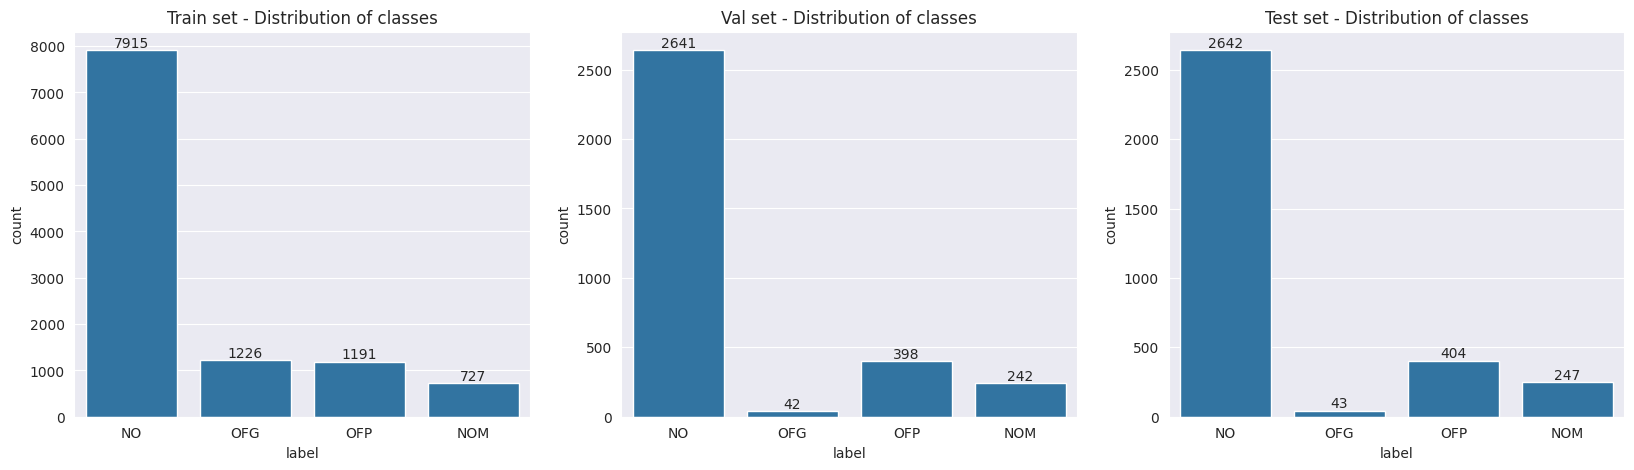

In [107]:
# Briefly check class 4 label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of classes")
ax.bar_label(ax.containers[0])

plt.show()

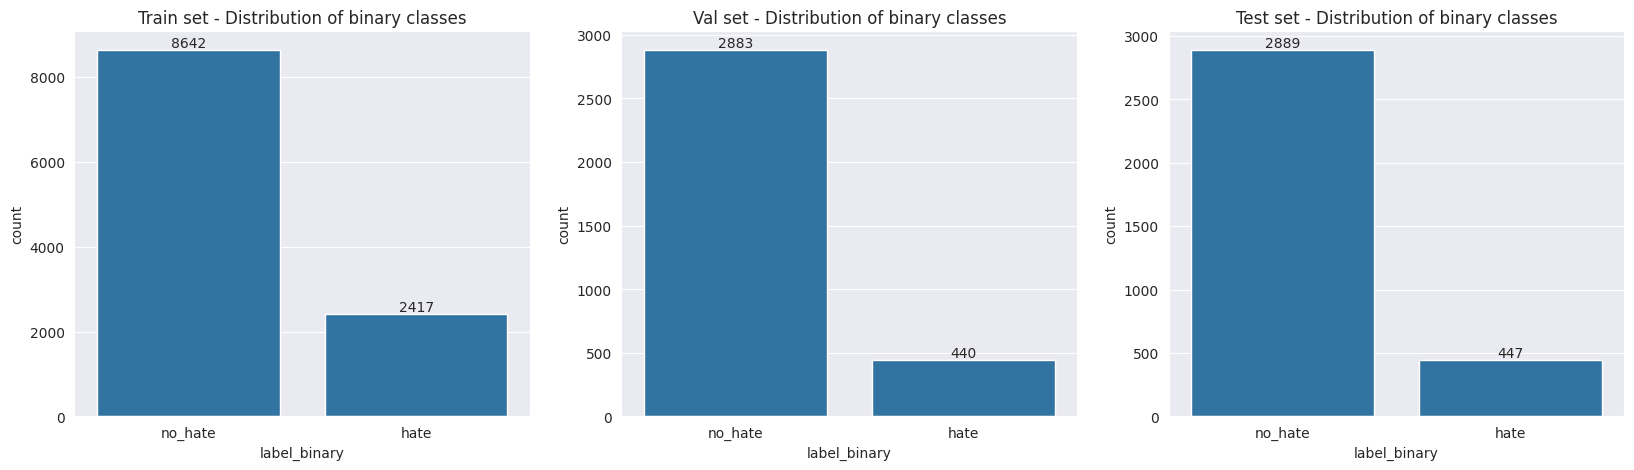

In [108]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

## Generación del dataset v7

Vamos a repetir lo mismo que hicimos para `v6`, con la diferencia de que harems el mismo cleanup que para `v4`, de forma de poder utilizar esto en nuestros modelos contextuales.

In [11]:
dataset_name: str = "v7"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

v6_directory: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), "v6")
out_file_augments: str = os.path.join(v6_directory, "augments.json")

# I'm putting all cleaner fields so they're easy to change later!
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=False,  # I want to keep this contextual information
    normalize_casing=False,  # I want to keep casing, as it's informative
    normalize_unicode_string=True,
    remove_urls=True,  # URLS probably not relevant, we can get rid of them
    remove_hashtags=False,  # hashtags might contain contextual info for the model to decide
    remove_stopwords=False,  # I want to keep stopwords, as they add contextual info
    remove_unicode_symbols=False,  # keep emojis and things like this, they might be relevant for the model
    replace_diacritics=True,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=None
))
augmenter: DataAugmenter = FromDiskAugmenter(FromDiskAugmenterConfig(file_path=out_file_augments))
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(cleaner=cleaner, augmenter=[augmenter], validation_split=0.2)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

train_df, val_df, test_df = pipeline.process(train_file=route_resolver.get_training_dataset_path(),
                                             test_file=route_resolver.get_testing_dataset_path())

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(os.path.join(dataset_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(dataset_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(dataset_folder, "test.csv"), index=False)
print(f"Persisted to: {dataset_folder}")

OFG: 1141 augments
Total original train samples: 13368
Total original test samples: 3342
Total original percentage of test samples: 20.0% 

Cleaning dataframes...
Total train samples after cleanup: 13367
Total test samples after cleanup: 3342
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'comment' with the same content for train set: 1
Total 'comment' with the same content for train set: 2
Total unique 'comment' with the same content for train set: 0
Total 'comment' with the same content for train set: 0
Test duplicates ===
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in df_b that also appear in df_a: 0. Deleting them from df_a!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 10025
Total ele

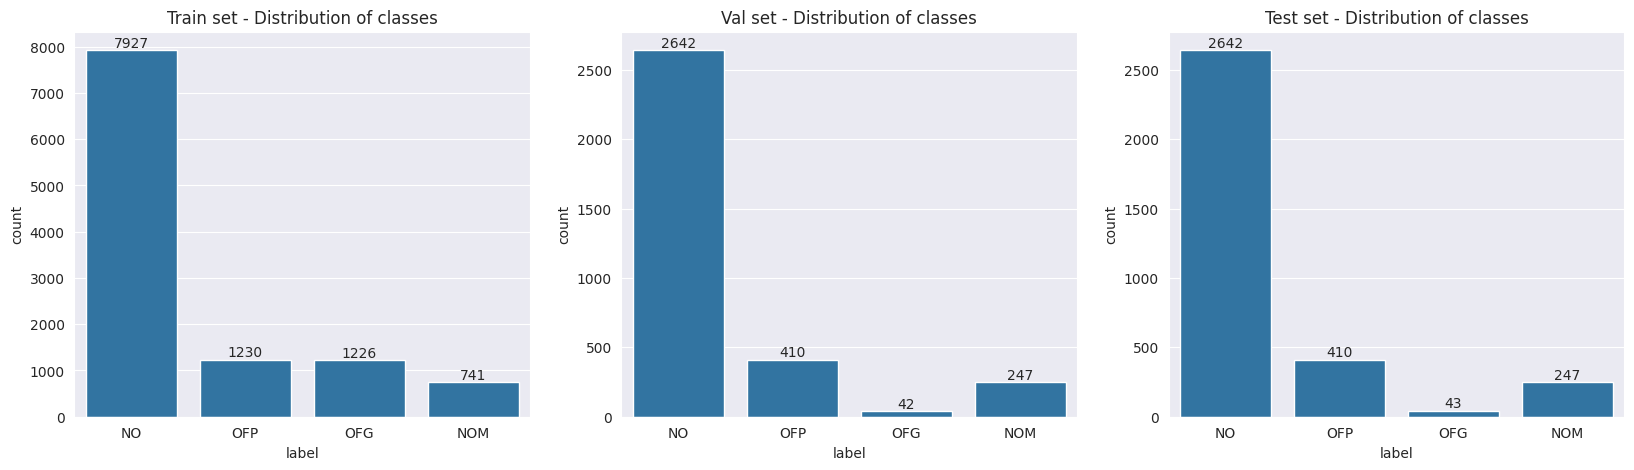

In [12]:
# Briefly check class 4 label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of classes")
ax.bar_label(ax.containers[0])

plt.show()

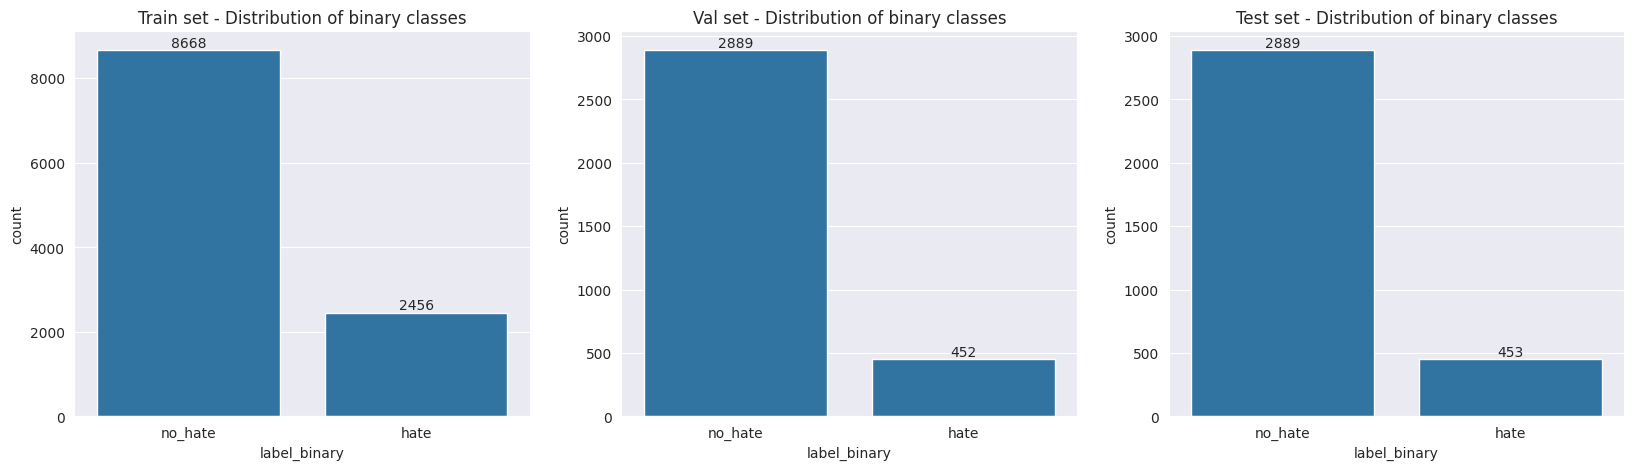

In [13]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

## Generación del dataset v8

Este dataset tendrá el mismo cleanup que `v6`, es decir, el mismo cleanup que `v1`, sólo que tendrá balanceadas las clases una vez de haber aumentado `OFG` con ChatGPT.

In [13]:
v6_directory: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), "v6")
out_file_augments: str = os.path.join(v6_directory, "augments.json")

dataset_name: str = "v8"
dataset_folder: str = os.path.join(route_resolver.get_exp_output_notebook_folder(1), dataset_name)
create_dir_if_not_exists(dataset_folder)

# I'm putting all cleaner fields so they're easy to change later!
cleaner: CommentCleaner = CommentCleaner(CleaningConfig(
    keep_letters_only=False,
    remove_digits=False,
    remove_punctuation=True,
    normalize_casing=True,
    normalize_unicode_string=True,
    remove_urls=True,
    remove_hashtags=False,
    remove_stopwords=True,
    remove_unicode_symbols=False,
    replace_diacritics=False,
    apply_lemmatization=False,
    apply_stemming=False,
    stopwords=set(stopwords.words("spanish"))
))
augmenter_ofg: DataAugmenter = FromDiskAugmenter(FromDiskAugmenterConfig(file_path=out_file_augments))
augmenter_ros: DataAugmenter = ROSAugmenter(ROSAugmenterConfig())
pipe_config: DatasetPipelineConfig = DatasetPipelineConfig(cleaner=cleaner, augmenter=[augmenter_ofg, augmenter_ros], validation_split=0.2)
pipeline: DatasetPipeline = DatasetPipeline(pipe_config)

train_df, val_df, test_df = pipeline.process(train_file=route_resolver.get_training_dataset_path(),
                                             test_file=route_resolver.get_testing_dataset_path())

# Dump datasets into the OS
print("Persisting datasets...")
train_df.to_csv(os.path.join(dataset_folder, "train.csv"), index=False)
val_df.to_csv(os.path.join(dataset_folder, "val.csv"), index=False)
test_df.to_csv(os.path.join(dataset_folder, "test.csv"), index=False)
print(f"Persisted to: {dataset_folder}")

OFG: 1141 augments
Total original train samples: 13368
Total original test samples: 3342
Total original percentage of test samples: 20.0% 

Cleaning dataframes...
Total train samples after cleanup: 13367
Total test samples after cleanup: 3342
Cleaning done! 

Duplicates analysis...
Train duplicates ===
Total unique 'comment' with the same content for train set: 39
Total 'comment' with the same content for train set: 104
Total unique 'comment' with the same content for train set: 0
Total 'comment' with the same content for train set: 0
Test duplicates ===
Total unique 'comment' with the same content for test set: 4
Total 'comment' with the same content for test set: 10
Total unique 'comment' with the same content for test set: 0
Total 'comment' with the same content for test set: 0
Train/Test cross duplicates ===
Total comments in df_b that also appear in df_a: 19. Deleting them from df_a!
Duplicate analysis done! 

Performing split...
Total elements in train set after split: 9960
Total

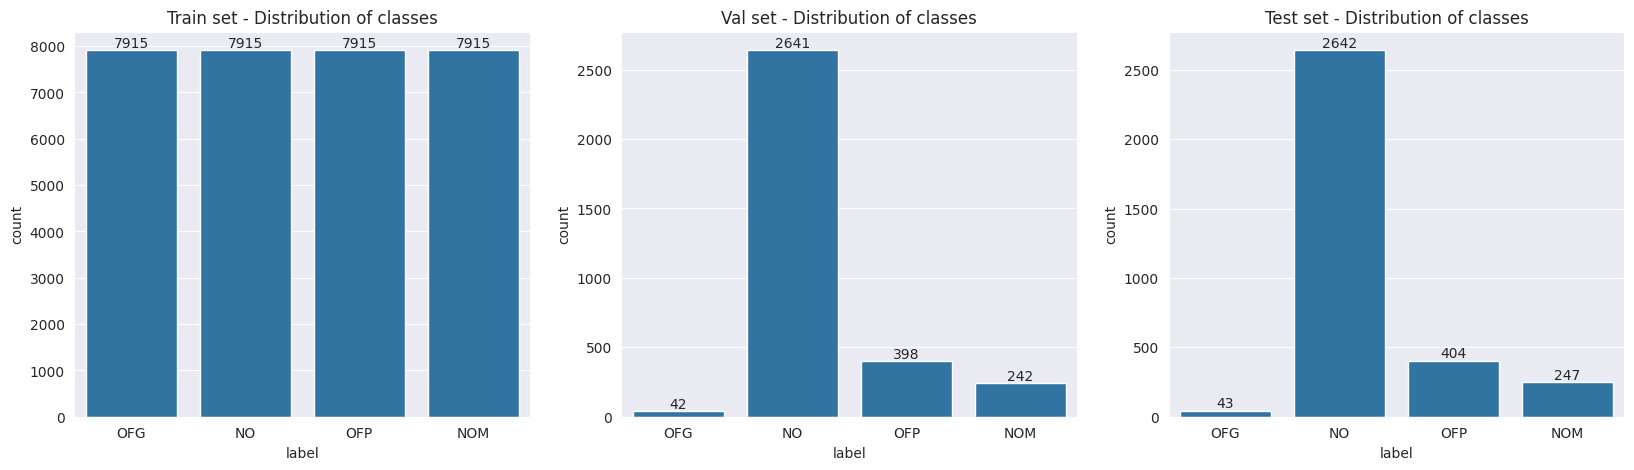

In [14]:
# Briefly check class 4 label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Train set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Val set - Distribution of classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label", order=train_df['label'].value_counts().index)
ax.set_title(f"Test set - Distribution of classes")
ax.bar_label(ax.containers[0])

plt.show()

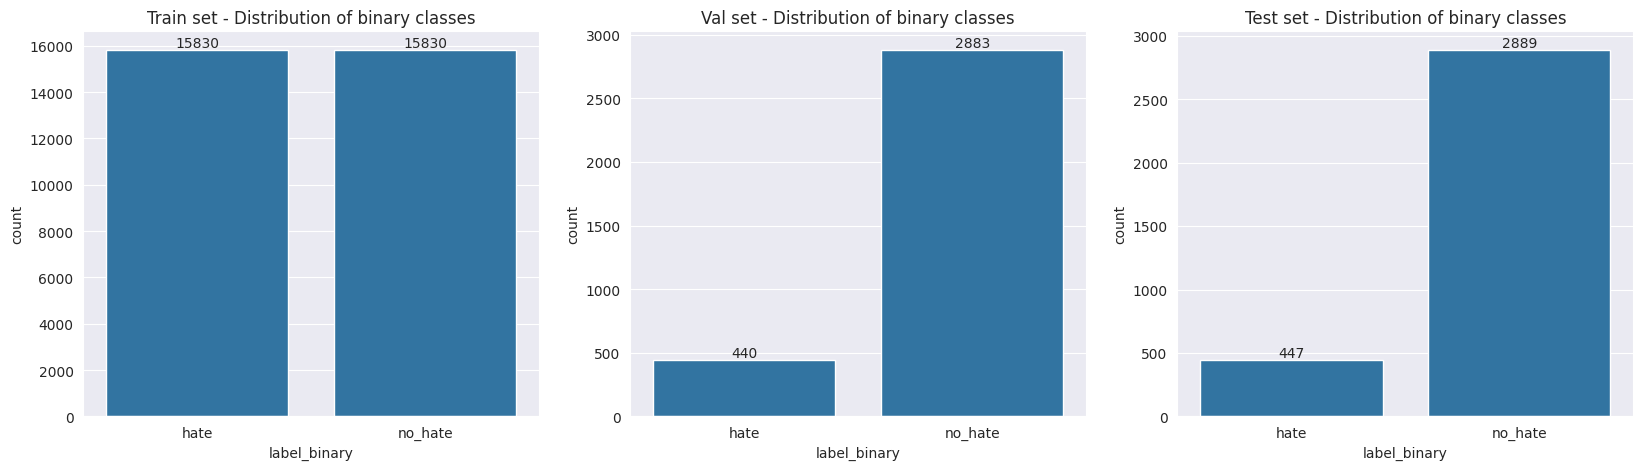

In [15]:
# Briefly check binary label class distribution
_, axes = plt.subplots(1, 3, figsize=(20, 5))

ax = sns.countplot(data=train_df, ax=axes[0], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Train set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=val_df, ax=axes[1], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Val set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

ax = sns.countplot(data=test_df, ax=axes[2], x="label_binary", order=train_df['label_binary'].value_counts().index)
ax.set_title(f"Test set - Distribution of binary classes")
ax.bar_label(ax.containers[0])

plt.show()

# Índice de datasets generados

| Dataset Name | Description                                                                                                    | # train | # val | # test |
|--------------|----------------------------------------------------------------------------------------------------------------|---------|-------|--------|
| v1           | Original version, no data augmentation.<br/> Split is: 70% train - 20% val - 20% test                          | 9960    | 3323  | 3336   |
| v2           | Original version, Random Over Sampling Augmentation.                                                           | 31660   | 3323  | 3336   |
| v3           | Original version, SMOTE Augmentation.                                                                          | 31648   | 3323  | 3336   |
| v4           | Very light cleanup, for contextual models, no data augmentation.                                               | 10025   | 3341  | 3342   |
| v5           | Same as `v4`, with Random Over Sampling Augmentation applied.                                                  | 31708   | 3341  | 3342   |
| v6           | Same cleanup as `v1`, `OFG` augmented via ChatGPT synthetic generation.                                        | 11059   | 3323  | 3336   |
| v7           | Same cleanup as `v4`, `OFG` augmented via ChatGPT synthetic generation like we did in `v6`                     | 11124   | 3341  | 3342   |
| v8           | Same cleanup as `v1`, `OFG` augmented via ChatGPT synthetic generation like we did in `v6` and ROS after that. | 31660   | 3323  | 3336   |

Notar que para la generación de los diversos datasets, siempre fuimos respetuosos sobre el validation y el test set, intentando mantener el mismo porcentaje para los datos, y enfocándonos en aumentar el train set luego que los splits hayan sido aplicados, de forma de garantizar de que no nos queden elementos en ambos sets. Por otro lado, nos aseguramos siempre de generar versiones del validation y test sets que respeten el mismo cleanup hecho para training, de manera de que la evaluación sea lo más justa posible.

Por otro lado, desarrollamos una clase `DatasetPipeline` que brinda una pipeline bastante genérica que pudimos reusar varias veces para la generación de las distintas versiones de los datasets. Esta pipeline considera aspectos como el cleanup, el deduping, aplicación de técnicas de augmentation, entre otras cosas.